<a href="https://colab.research.google.com/github/akimi-yano/Animal_Image_Classification/blob/main/Animal_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

opencv_pytorch_project_1_classification_path = kagglehub.competition_download('opencv-pytorch-project-1-classification')

print('Data source import complete.')


100%|██████████| 188M/188M [00:11<00:00, 16.6MB/s]

Extracting files...


Data source import complete.


In [3]:
! pip install -q kaggle

In [39]:
from google.colab import files
files.upload()

{}

In [5]:
!mkdir -p ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
!ls ~/.kaggle

kaggle.json


In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
! kaggle competitions download -c opencv-pytorch-project-1-classification

100% 187M/188M [00:09<00:00, 23.2MB/s]
100% 188M/188M [00:09<00:00, 21.0MB/s]


In [10]:
!unzip opencv-pytorch-project-1-classification.zip -d dataset/

Archive:  opencv-pytorch-project-1-classification.zip
  inflating: dataset/dataset/Test/100000.jpg  
  inflating: dataset/dataset/Test/100100.jpg  
  inflating: dataset/dataset/Test/100200.jpg  
  inflating: dataset/dataset/Test/100300.jpg  
  inflating: dataset/dataset/Test/100400.jpg  
  inflating: dataset/dataset/Test/100500.jpg  
  inflating: dataset/dataset/Test/100600.jpg  
  inflating: dataset/dataset/Test/100700.jpg  
  inflating: dataset/dataset/Test/100800.jpg  
  inflating: dataset/dataset/Test/100900.jpg  
  inflating: dataset/dataset/Test/101000.jpg  
  inflating: dataset/dataset/Test/101100.jpg  
  inflating: dataset/dataset/Test/101200.jpg  
  inflating: dataset/dataset/Test/101300.jpg  
  inflating: dataset/dataset/Test/101400.jpg  
  inflating: dataset/dataset/Test/101500.jpg  
  inflating: dataset/dataset/Test/101600.jpg  
  inflating: dataset/dataset/Test/101700.jpg  
  inflating: dataset/dataset/Test/101800.jpg  
  inflating: dataset/dataset/Test/101900.jpg  
  infl

In [11]:
import os
data_root = './dataset/dataset'
os.path.exists(data_root)
for elem in os.walk(data_root):
  print(elem)

('./dataset/dataset', ['Valid', 'Test', 'Train'], [])
('./dataset/dataset/Valid', ['cat', 'dog', 'panda'], [])
('./dataset/dataset/Valid/cat', [], ['cats_00015.jpg', 'cats_00022.jpg', 'cats_00141.jpg', 'cats_00601.jpg', 'cats_00514.jpg', 'cats_00634.jpg', 'cats_00046.jpg', 'cats_00414.jpg', 'cats_00403.jpg', 'cats_00529.jpg', 'cats_00539.jpg', 'cats_00520.jpg', 'cats_00224.jpg', 'cats_00290.jpg', 'cats_00408.jpg', 'cats_00032.jpg', 'cats_00715.jpg', 'cats_00329.jpg', 'cats_00049.jpg', 'cats_00606.jpg', 'cats_00565.jpg', 'cats_00241.jpg', 'cats_00605.jpg', 'cats_00150.jpg', 'cats_00746.jpg', 'cats_00247.jpg', 'cats_00105.jpg', 'cats_00217.jpg', 'cats_00698.jpg', 'cats_00084.jpg', 'cats_00407.jpg', 'cats_00679.jpg', 'cats_00292.jpg', 'cats_00336.jpg', 'cats_00439.jpg', 'cats_00783.jpg', 'cats_00553.jpg', 'cats_00167.jpg', 'cats_00713.jpg', 'cats_00740.jpg', 'cats_00505.jpg', 'cats_00689.jpg', 'cats_00412.jpg', 'cats_00463.jpg', 'cats_00039.jpg', 'cats_00425.jpg', 'cats_00477.jpg', 'cats_

## <font style="color:blue">Import Libraries </font>

In [12]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 45.8 MB/s eta 0:00:00


In [13]:
import os
import time
from dataclasses import dataclass
from typing import List, Union, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy



# Text formatting
bold = "\033[1m"
end = "\033[0m"

plt.style.use('ggplot')
block_plot=False

%matplotlib inline

### <font style="color:green">Compulsary Preprocessing Transforms</font>

In [14]:
def image_preprocess_transforms(img_size):
    preprocess = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ]
    )

    return preprocess

### <font style="color:green">Common Image Transforms</font>

In [15]:
def image_common_transforms(img_size=(224, 224), mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms(img_size)

    common_transforms = transforms.Compose(
        [
            preprocess,
            transforms.Normalize(mean, std),
        ]
    )

    return common_transforms

### <font style="color:green">Mean and STD</font>

In [16]:
def get_mean_std(data_root, img_size=(224, 224), num_workers=4):
    transform = image_preprocess_transforms(img_size=img_size)

    loader = data_loader(data_root, transform)

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3))  # E[batch_i]
        batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3))  #  E[batch_i**2]

    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)

    # var[X] = E[X**2] - E[X]**2

    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2

    var = (batch_mean_sqrd / len(loader)) - (mean**2)

    std = var**0.5
    print("mean: {}, std: {}".format(mean, std))

    return mean, std

### <font style="color:green">Data Loader for Full Data</font>

In [17]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
    )

    return loader

## <font style="color:green">Prepare Data</font>


In [18]:
def data_augmentation_preprocess(img_size, mean, std):
    preprocess = image_preprocess_transforms(img_size)

    transform = transforms.Compose([
        # Data Augmentation
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
        transforms.RandomRotation(degrees=15),  # Rotate images by up to 15 degrees
        transforms.RandomResizedCrop(size=img_size[0], scale=(0.8, 1.0)),  # Randomly crop and resize images
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
        transforms.RandomGrayscale(p=0.1),      # Occasionally convert to grayscale

        # Do the same pre processing as the non data aug datasets
        preprocess,
        transforms.Normalize(mean, std),
    ])
    return transform

def get_data(batch_size, data_root, img_size=(224, 224), num_workers=4, data_augmentation=False):
    train_data_path = os.path.join(data_root, "Train")

    mean, std = get_mean_std(data_root=train_data_path, img_size=img_size, num_workers=num_workers)

    common_transforms = image_common_transforms(img_size, mean, std)

    # If data_augmentation is true data augmentation will be applied.
    if data_augmentation:
        train_transforms = data_augmentation_preprocess(img_size, mean, std) # Notes: define the data_augmentation_preprocess function and inlcude the img_size
    # Else simply do common transforms
    else:
        train_transforms = common_transforms

    # Train dataloader
    train_loader = data_loader(
        train_data_path,
        train_transforms,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    # Valid dataloader
    valid_data_path = os.path.join(data_root, "Valid")

    valid_loader = data_loader(
        valid_data_path,
        common_transforms,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader

### <font style="color:green">System Configuration</font>

Fix the seed (e.g., `21`) to get a reproducible result.

In [19]:
@dataclass
class SystemConfig:
    """
    Describes the common system setting needed for reproducible training
    """

    seed: int = 21  # Seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # Enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # Make cudnn deterministic (reproducible training)

### <font style="color:green">Training Configuration</font>

In [20]:
@dataclass
class TrainingConfig:
    """
    Describes configuration of the training process
    """

    num_classes: int = 3
    batch_size: int = 32
    img_size: Tuple = (200, 200)
    epochs_count: int = 100
    init_learning_rate: float = 1e-4
    # data_root: str = "/kaggle/input/opencv-pytorch-classification-project-1/dataset"
    # data_root: str = "/kaggle/input/opencv-pytorch-project-1-classification/dataset"
    data_root: str = "./dataset/dataset"
    num_workers: int = 2
    device: str = "cuda"

    # For tensorboard logging and saving checkpoints
    save_model_name: str = "cat_dog_panda_classifier.pt"
    root_log_dir: str = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir: str = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir: str = "version_0"
    checkpoint_dir: str = "version_0"

### <font style="color:green">System Setup</font>

In [21]:
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">Training Function</font>

In [22]:
def train(
    train_config: TrainingConfig,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int,
) -> Tuple[float, float]:

    # Change model in training mode.
    model.train()

    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    mean_metric = MeanMetric()

    device = train_config.device

    status = f"Train:\t{bold}Epoch: {epoch_idx}/{total_epochs}{end}"

    prog_bar = tqdm(train_loader, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    prog_bar.set_description(status)

    for data, target in prog_bar:
        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)
        print("Using device is: ", device)

        # Reset parameters gradient to zero.
        optimizer.zero_grad()

        # Forward pass to the model.
        output = model(data)

        # Cross Entropy loss
        loss = F.cross_entropy(output, target)

        # Find gradients w.r.t training parameters.
        loss.backward()

        # Update parameters using gradients.
        optimizer.step()

        # Batch Loss.
        mean_metric(loss.item(), weight=data.shape[0])

        # Get the index of the max probability.
        pred_idx = output.detach().argmax(dim=1)

        # Batch accuracy.
        acc_metric(pred_idx.cpu(), target.cpu())

        # Update progress bar description.
        step_status = status + f" Train Loss: {mean_metric.compute():.4f}, Train Acc: {acc_metric.compute():.4f}"
        prog_bar.set_description(step_status)

    epoch_loss = mean_metric.compute()
    epoch_acc = acc_metric.compute()

    prog_bar.close()

    return epoch_loss, epoch_acc

## <font style="color:blue">Validation Function</font>

In [23]:
def validate(
    train_config: TrainingConfig,
    model: nn.Module,
    valid_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int
) -> Tuple[float, float]:

    # Change model in evaluation mode.
    model.eval()

    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    mean_metric = MeanMetric()

    device = train_config.device

    status = f"Valid:\t{bold}Epoch: {epoch_idx}/{total_epochs}{end}"

    prog_bar = tqdm(valid_loader, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    prog_bar.set_description(status)

    for data, target in prog_bar:
        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)

        # Get the model's predicted logits.
        with torch.no_grad():
            output = model(data)

        # Compute the CE-Loss.
        valid_loss = F.cross_entropy(output, target).item()

        # Batch validation loss.
        mean_metric(valid_loss, weight=data.shape[0])

        # Get the index of the max probability.
        pred_idx = output.detach().argmax(dim=1)

        # Batch accuracy.
        acc_metric(pred_idx.cpu(), target.cpu())

        # Update progress bar description.
        step_status = status + f" Valid Loss: {mean_metric.compute():.4f}, Valid Acc: {acc_metric.compute():.4f}"
        prog_bar.set_description(step_status)

    valid_loss = mean_metric.compute()
    valid_acc = acc_metric.compute()

    prog_bar.close()

    return valid_loss, valid_acc

## <font style="color:blue">Save & Load Model</font>

In [24]:
def save_model(model, device, model_dir="models", model_file_name="cat_dog_panda_classifier.pt"):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # Make sure you transfer the model to cpu.
    if device == "cuda":
        model.to("cpu")

    # Save the 'state_dict'
    torch.save(model.state_dict(), model_path)

    if device == "cuda":
        model.to("cuda")

    return

In [25]:
def load_model(model, model_dir="models", model_file_name="cat_dog_panda_classifier.pt", device=torch.device("cpu")):
    model_path = os.path.join(model_dir, model_file_name)

    # Load model parameters by using 'load_state_dict'.
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

## <font style="color:blue">Logging Setup</font>


In [26]:
def setup_log_directory(training_config=TrainingConfig()):
    """Tensorboard Log and Model checkpoint directory Setup"""

    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir.
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]

        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir

    # Update the training config default directory.
    training_config.log_dir = os.path.join(training_config.root_log_dir, version_name)
    training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version.
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_dir}")

    return training_config, version_name

## <font style="color:blue">Plot Loss and Accuracy</font>


In [27]:
def plot_loss_accuracy(
    train_loss,
    val_loss,
    train_acc,
    val_acc,
    colors,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(20, 10),
    sub_plot1=(1, 2, 1),
    sub_plot2=(1, 2, 2),
):
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = min(train_loss[i])
        min_val_loss = min(val_loss[i])

        plt.plot(x_train, train_loss[i], linestyle="-", color=f"tab:{colors[i]}", label=f"TRAIN LOSS ({min_train_loss:.4})")
        plt.plot(x_val, val_loss[i], linestyle="--", color=f"tab:{colors[i]}", label=f"VALID LOSS ({min_val_loss:.4})")


    plt.xlabel("epoch no.")
    plt.ylabel("loss")
    plt.legend(loc=loss_legend_loc)
    plt.title("Training and Validation Loss")
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = max(train_acc[i])
        max_val_acc = max(val_acc[i])

        plt.plot(
            x_train,
            train_acc[i],
            linestyle="-",
            color=f"tab:{colors[i]}",
            label=f"TRAIN ACC ({max_train_acc:.4})",
        )

        plt.plot(
            x_val,
            val_acc[i],
            linestyle="--",
            color=f"tab:{colors[i]}",
            label=f"VALID ACC ({max_val_acc:.4})",
        )


    plt.xlabel("epoch no.")
    plt.ylabel("accuracy")
    plt.legend(loc=acc_legend_loc)
    plt.title("Training and Validation Accuracy")
    fig.savefig("sample_loss_acc_plot.png")
    plt.show()

    return

## <font style="color:blue">Main Function for Training</font>

In [28]:
def main(model, summary_writer, scheduler=None, system_config=SystemConfig(), training_config=TrainingConfig(), data_augmentation=True):

    # Setup system configuration.
    setup_system(system_config)

    # Initialize data loader
    train_loader, valid_loader = get_data(
        batch_size=training_config.batch_size,
        data_root=training_config.data_root,
        img_size=training_config.img_size,
        num_workers=training_config.num_workers,
        data_augmentation=data_augmentation,
    )

    # Number of epochs to train.
    NUM_EPOCHS = training_config.epochs_count

    # Set acceleration device.
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Send model to device (GPU/CPU)
    model.to(device)

    # Initialize Adam optimizer.
    optimizer = optim.Adam(model.parameters(), lr=training_config.init_learning_rate, weight_decay=1e-4)

    best_loss = torch.tensor(np.inf)

    # Epoch train & valid loss accumulator.
    epoch_train_loss = []
    epoch_valid_loss = []

    # Epoch train & valid accuracy accumulator.
    epoch_train_acc = []
    epoch_valid_acc = []

    # Trainig time measurement
    t_begin = time.time()

    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train(training_config, model, optimizer, train_loader, epoch + 1, NUM_EPOCHS)
        val_loss, val_accuracy = validate(training_config, model, valid_loader, epoch + 1, NUM_EPOCHS)

        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)

        epoch_valid_loss.append(val_loss)
        epoch_valid_acc.append(val_accuracy)

        summary_writer.add_scalar("Loss/Train", train_loss, epoch)
        summary_writer.add_scalar("Accuracy/Train", train_acc, epoch)

        summary_writer.add_scalar("Loss/Validation", val_loss, epoch)
        summary_writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

        if val_loss < best_loss:
            best_loss = val_loss
            print(f"\nModel Improved... Saving Model ... ", end="")
            torch.save(model.state_dict(), os.path.join(training_config.checkpoint_dir, training_config.save_model_name))
            print("Done.\n")

        print(f"{'='*72}\n")

    print(f"Total time: {(time.time() - t_begin):.2f}s, Best Loss: {best_loss:.3f}")

    return epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc

## <font style="color:red">Define Model</font>

In [29]:
from torchvision import models
from collections import OrderedDict

class MyModel(nn.Module):
    def __init__(self, num_classes=3, pretrained=False):
        super(MyModel, self).__init__()

        # Feature extraction layers (Conv2d -> BatchNorm -> ReLU -> MaxPooling)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Global Average Pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512, 2048),        # Fully connected layer 1
            nn.BatchNorm1d(2048),        # Batch normalization
            nn.ReLU(),                   # ReLU activation
            nn.Dropout(0.5),             # Dropout for regularization
            nn.Linear(2048, 256),        # Fully connected layer 2
            nn.BatchNorm1d(256),         # Batch normalization
            nn.ReLU(),                   # ReLU activation
            nn.Dropout(0.5),             # Dropout for regularization
            nn.Linear(256, num_classes), # Output layer for num_classes
            nn.LogSoftmax(dim=1)         # LogSoftmax for classification
        )

    def forward(self, x):

        # Pass through feature extraction layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor

        # Pass through fully connected layers
        x = self.fc(x)
        return x


## <font style="color:blue">Training</font>


In [30]:
model = MyModel()
print(model)

training_config = TrainingConfig()

# Model checkpoint log dir setup.
training_config, current_version_name = setup_log_directory(training_config)

# Tensorboard log dir setup.
summary_writer = SummaryWriter(training_config.log_dir)

MyModel(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): B

In [31]:
# Train and Validate
train_loss, train_acc, val_loss, val_acc = main(
    model,
    summary_writer=summary_writer,
    scheduler=None,
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=True,
)

mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2681, 0.2595, 0.2594])


Train:	Epoch: 1/100:   0%|          | 0/66 [00:00<?, ?it/s]

Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 1.2478, Train Acc: 0.3594:   3%|▎         | 2/66 [00:02<00:54,  1.17it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 1.0606, Train Acc: 0.4922:   6%|▌         | 4/66 [00:02<00:23,  2.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 1.0265, Train Acc: 0.4948:   9%|▉         | 6/66 [00:02<00:14,  4.10it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9700, Train Acc: 0.5312:  12%|█▏        | 8/66 [00:02<00:11,  5.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9641, Train Acc: 0.5375:  15%|█▌        | 10/66 [00:03<00:09,  6.06it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9530, Train Acc: 0.5573:  18%|█▊        | 12/66 [00:03<00:08,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9261, Train Acc: 0.5692:  21%|██        | 14/66 [00:03<00:07,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9290, Train Acc: 0.5664:  24%|██▍       | 16/66 [00:04<00:07,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9192, Train Acc: 0.5694:  27%|██▋       | 18/66 [00:04<00:06,  6.88it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9067, Train Acc: 0.5781:  30%|███       | 20/66 [00:04<00:06,  6.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9119, Train Acc: 0.5753:  33%|███▎      | 22/66 [00:04<00:06,  6.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9106, Train Acc: 0.5729:  36%|███▋      | 24/66 [00:05<00:05,  7.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9097, Train Acc: 0.5733:  39%|███▉      | 26/66 [00:05<00:05,  6.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9114, Train Acc: 0.5737:  42%|████▏     | 28/66 [00:05<00:05,  6.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9195, Train Acc: 0.5677:  45%|████▌     | 30/66 [00:06<00:05,  6.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9283, Train Acc: 0.5654:  48%|████▊     | 32/66 [00:06<00:04,  6.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9254, Train Acc: 0.5616:  52%|█████▏    | 34/66 [00:06<00:04,  6.88it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9294, Train Acc: 0.5573:  55%|█████▍    | 36/66 [00:06<00:04,  6.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9282, Train Acc: 0.5551:  58%|█████▊    | 38/66 [00:07<00:04,  6.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9287, Train Acc: 0.5547:  61%|██████    | 40/66 [00:07<00:03,  6.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9352, Train Acc: 0.5499:  64%|██████▎   | 42/66 [00:07<00:03,  6.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9311, Train Acc: 0.5490:  67%|██████▋   | 44/66 [00:08<00:03,  6.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9330, Train Acc: 0.5462:  70%|██████▉   | 46/66 [00:08<00:02,  6.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9329, Train Acc: 0.5462:  73%|███████▎  | 48/66 [00:08<00:02,  6.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9279, Train Acc: 0.5481:  76%|███████▌  | 50/66 [00:08<00:02,  6.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9299, Train Acc: 0.5499:  79%|███████▉  | 52/66 [00:09<00:02,  6.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9302, Train Acc: 0.5492:  82%|████████▏ | 54/66 [00:09<00:01,  6.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9303, Train Acc: 0.5491:  85%|████████▍ | 56/66 [00:09<00:01,  6.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9241, Train Acc: 0.5560:  88%|████████▊ | 58/66 [00:10<00:01,  6.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9205, Train Acc: 0.5557:  91%|█████████ | 60/66 [00:10<00:00,  6.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9158, Train Acc: 0.5559:  94%|█████████▍| 62/66 [00:10<00:00,  6.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9164, Train Acc: 0.5542:  97%|█████████▋| 64/66 [00:10<00:00,  6.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 1/100 Train Loss: 0.9175, Train Acc: 0.5543: 100%|██████████| 66/66 [00:11<00:00,  5.88it/s]


Using device is:  cuda


Valid:	Epoch: 1/100 Valid Loss: 0.8051, Valid Acc: 0.5967: 100%|██████████| 10/10 [00:00<00:00, 12.32it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 2/100 Train Loss: 0.8315, Train Acc: 0.5625:   2%|▏         | 1/66 [00:00<00:32,  1.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.9499, Train Acc: 0.5000:   5%|▍         | 3/66 [00:00<00:14,  4.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8942, Train Acc: 0.5188:   8%|▊         | 5/66 [00:01<00:11,  5.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8587, Train Acc: 0.5536:  11%|█         | 7/66 [00:01<00:09,  6.17it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8454, Train Acc: 0.5799:  14%|█▎        | 9/66 [00:01<00:08,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8517, Train Acc: 0.5767:  17%|█▋        | 11/66 [00:01<00:08,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8778, Train Acc: 0.5721:  20%|█▉        | 13/66 [00:02<00:07,  6.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8855, Train Acc: 0.5667:  23%|██▎       | 15/66 [00:02<00:07,  6.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.9056, Train Acc: 0.5515:  26%|██▌       | 17/66 [00:02<00:07,  6.86it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.9078, Train Acc: 0.5493:  29%|██▉       | 19/66 [00:03<00:06,  6.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.9048, Train Acc: 0.5461:  32%|███▏      | 21/66 [00:03<00:06,  6.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.9012, Train Acc: 0.5448:  35%|███▍      | 23/66 [00:03<00:06,  6.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8883, Train Acc: 0.5537:  38%|███▊      | 25/66 [00:03<00:05,  6.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8863, Train Acc: 0.5567:  41%|████      | 27/66 [00:04<00:05,  6.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8836, Train Acc: 0.5582:  44%|████▍     | 29/66 [00:04<00:05,  6.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8815, Train Acc: 0.5575:  47%|████▋     | 31/66 [00:04<00:05,  6.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8749, Train Acc: 0.5644:  50%|█████     | 33/66 [00:05<00:04,  6.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8767, Train Acc: 0.5652:  53%|█████▎    | 35/66 [00:05<00:04,  6.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8732, Train Acc: 0.5642:  56%|█████▌    | 37/66 [00:05<00:04,  6.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8660, Train Acc: 0.5673:  59%|█████▉    | 39/66 [00:06<00:04,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8624, Train Acc: 0.5678:  62%|██████▏   | 41/66 [00:06<00:03,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8612, Train Acc: 0.5690:  65%|██████▌   | 43/66 [00:06<00:03,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8582, Train Acc: 0.5715:  68%|██████▊   | 45/66 [00:07<00:03,  5.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8555, Train Acc: 0.5711:  71%|███████   | 47/66 [00:07<00:03,  6.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8544, Train Acc: 0.5708:  74%|███████▍  | 49/66 [00:07<00:02,  6.06it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8518, Train Acc: 0.5717:  77%|███████▋  | 51/66 [00:08<00:02,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8501, Train Acc: 0.5702:  80%|████████  | 53/66 [00:08<00:02,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8523, Train Acc: 0.5682:  83%|████████▎ | 55/66 [00:08<00:01,  5.88it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8467, Train Acc: 0.5735:  86%|████████▋ | 57/66 [00:08<00:01,  6.03it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8462, Train Acc: 0.5731:  89%|████████▉ | 59/66 [00:09<00:01,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8427, Train Acc: 0.5758:  92%|█████████▏| 61/66 [00:09<00:00,  6.03it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8405, Train Acc: 0.5774:  95%|█████████▌| 63/66 [00:09<00:00,  6.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8435, Train Acc: 0.5755:  98%|█████████▊| 65/66 [00:10<00:00,  5.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 2/100 Train Loss: 0.8435, Train Acc: 0.5752: 100%|██████████| 66/66 [00:10<00:00,  6.32it/s]
Valid:	Epoch: 2/100 Valid Loss: 0.8670, Valid Acc: 0.5600: 100%|██████████| 10/10 [00:00<00:00, 10.70it/s]


Train:	Epoch: 3/100 Train Loss: 0.8004, Train Acc: 0.6250:   2%|▏         | 1/66 [00:00<00:37,  1.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7415, Train Acc: 0.6250:   5%|▍         | 3/66 [00:00<00:18,  3.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7394, Train Acc: 0.6062:   8%|▊         | 5/66 [00:01<00:13,  4.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7753, Train Acc: 0.6071:  11%|█         | 7/66 [00:01<00:11,  5.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.8005, Train Acc: 0.5764:  14%|█▎        | 9/66 [00:02<00:11,  5.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7866, Train Acc: 0.5938:  17%|█▋        | 11/66 [00:02<00:10,  5.03it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.8001, Train Acc: 0.5889:  20%|█▉        | 13/66 [00:02<00:10,  4.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7814, Train Acc: 0.5979:  23%|██▎       | 15/66 [00:03<00:09,  5.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7833, Train Acc: 0.5882:  26%|██▌       | 17/66 [00:03<00:08,  5.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7566, Train Acc: 0.6151:  29%|██▉       | 19/66 [00:03<00:07,  6.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7706, Train Acc: 0.6042:  32%|███▏      | 21/66 [00:04<00:07,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7719, Train Acc: 0.5978:  35%|███▍      | 23/66 [00:04<00:06,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7612, Train Acc: 0.6087:  38%|███▊      | 25/66 [00:04<00:06,  6.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7705, Train Acc: 0.6053:  41%|████      | 27/66 [00:04<00:05,  6.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7668, Train Acc: 0.6045:  44%|████▍     | 29/66 [00:05<00:05,  6.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7699, Train Acc: 0.6038:  47%|████▋     | 31/66 [00:05<00:05,  6.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7646, Train Acc: 0.6013:  50%|█████     | 33/66 [00:05<00:04,  6.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7703, Train Acc: 0.6009:  53%|█████▎    | 35/66 [00:06<00:04,  6.88it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7690, Train Acc: 0.6030:  56%|█████▌    | 37/66 [00:06<00:04,  6.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7710, Train Acc: 0.6010:  59%|█████▉    | 39/66 [00:06<00:03,  6.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7726, Train Acc: 0.6037:  62%|██████▏   | 41/66 [00:06<00:03,  6.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7674, Train Acc: 0.6090:  65%|██████▌   | 43/66 [00:07<00:03,  6.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7723, Train Acc: 0.6069:  68%|██████▊   | 45/66 [00:07<00:03,  6.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7798, Train Acc: 0.6037:  71%|███████   | 47/66 [00:07<00:02,  6.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7754, Train Acc: 0.6065:  74%|███████▍  | 49/66 [00:08<00:02,  6.88it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7742, Train Acc: 0.6097:  77%|███████▋  | 51/66 [00:08<00:02,  6.86it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7739, Train Acc: 0.6144:  80%|████████  | 53/66 [00:08<00:01,  6.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7653, Train Acc: 0.6199:  83%|████████▎ | 55/66 [00:08<00:01,  6.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7639, Train Acc: 0.6206:  86%|████████▋ | 57/66 [00:09<00:01,  6.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7638, Train Acc: 0.6218:  89%|████████▉ | 59/66 [00:09<00:01,  6.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7695, Train Acc: 0.6189:  92%|█████████▏| 61/66 [00:09<00:00,  6.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7681, Train Acc: 0.6195:  95%|█████████▌| 63/66 [00:10<00:00,  6.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7660, Train Acc: 0.6207:  98%|█████████▊| 65/66 [00:10<00:00,  6.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 3/100 Train Loss: 0.7650, Train Acc: 0.6229: 100%|██████████| 66/66 [00:10<00:00,  6.25it/s]
Valid:	Epoch: 3/100 Valid Loss: 0.7173, Valid Acc: 0.6933: 100%|██████████| 10/10 [00:00<00:00, 12.29it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 4/100 Train Loss: 0.9067, Train Acc: 0.5312:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7647, Train Acc: 0.6250:   5%|▍         | 3/66 [00:00<00:14,  4.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7456, Train Acc: 0.6000:   8%|▊         | 5/66 [00:01<00:10,  5.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7225, Train Acc: 0.6205:  11%|█         | 7/66 [00:01<00:09,  6.12it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7234, Train Acc: 0.6354:  14%|█▎        | 9/66 [00:01<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7293, Train Acc: 0.6335:  17%|█▋        | 11/66 [00:01<00:08,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7306, Train Acc: 0.6274:  20%|█▉        | 13/66 [00:02<00:07,  6.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7410, Train Acc: 0.6313:  23%|██▎       | 15/66 [00:02<00:07,  6.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7345, Train Acc: 0.6324:  26%|██▌       | 17/66 [00:02<00:07,  6.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7218, Train Acc: 0.6398:  29%|██▉       | 19/66 [00:03<00:06,  6.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7269, Train Acc: 0.6369:  32%|███▏      | 21/66 [00:03<00:06,  6.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7220, Train Acc: 0.6427:  35%|███▍      | 23/66 [00:03<00:06,  6.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7199, Train Acc: 0.6450:  38%|███▊      | 25/66 [00:04<00:06,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7079, Train Acc: 0.6505:  41%|████      | 27/66 [00:04<00:05,  6.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7006, Train Acc: 0.6552:  44%|████▍     | 29/66 [00:04<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7123, Train Acc: 0.6492:  47%|████▋     | 31/66 [00:04<00:05,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7113, Train Acc: 0.6534:  50%|█████     | 33/66 [00:05<00:04,  6.75it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7117, Train Acc: 0.6527:  53%|█████▎    | 35/66 [00:05<00:04,  6.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7045, Train Acc: 0.6562:  56%|█████▌    | 37/66 [00:05<00:04,  6.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7105, Train Acc: 0.6538:  59%|█████▉    | 39/66 [00:06<00:03,  6.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7066, Train Acc: 0.6547:  62%|██████▏   | 41/66 [00:06<00:03,  6.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7096, Train Acc: 0.6519:  65%|██████▌   | 43/66 [00:06<00:03,  6.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7118, Train Acc: 0.6486:  68%|██████▊   | 45/66 [00:06<00:03,  6.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7098, Train Acc: 0.6463:  71%|███████   | 47/66 [00:07<00:02,  6.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7108, Train Acc: 0.6473:  74%|███████▍  | 49/66 [00:07<00:02,  6.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7097, Train Acc: 0.6477:  77%|███████▋  | 51/66 [00:07<00:02,  6.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7058, Train Acc: 0.6509:  80%|████████  | 53/66 [00:08<00:01,  6.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7085, Train Acc: 0.6455:  83%|████████▎ | 55/66 [00:08<00:01,  6.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7056, Train Acc: 0.6480:  86%|████████▋ | 57/66 [00:08<00:01,  6.75it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7039, Train Acc: 0.6483:  89%|████████▉ | 59/66 [00:09<00:01,  6.75it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7046, Train Acc: 0.6496:  92%|█████████▏| 61/66 [00:09<00:00,  6.77it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7062, Train Acc: 0.6478:  95%|█████████▌| 63/66 [00:09<00:00,  6.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7033, Train Acc: 0.6481:  98%|█████████▊| 65/66 [00:09<00:00,  6.86it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 4/100 Train Loss: 0.7039, Train Acc: 0.6481: 100%|██████████| 66/66 [00:10<00:00,  6.57it/s]
Valid:	Epoch: 4/100 Valid Loss: 0.6435, Valid Acc: 0.6933: 100%|██████████| 10/10 [00:00<00:00, 12.39it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 5/100 Train Loss: 0.6902, Train Acc: 0.5938:   2%|▏         | 1/66 [00:00<00:32,  1.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.7470, Train Acc: 0.6458:   5%|▍         | 3/66 [00:00<00:14,  4.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6851, Train Acc: 0.6625:   8%|▊         | 5/66 [00:01<00:10,  5.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.7082, Train Acc: 0.6429:  11%|█         | 7/66 [00:01<00:09,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.7132, Train Acc: 0.6319:  14%|█▎        | 9/66 [00:01<00:08,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.7133, Train Acc: 0.6392:  17%|█▋        | 11/66 [00:01<00:08,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6981, Train Acc: 0.6442:  20%|█▉        | 13/66 [00:02<00:07,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.7024, Train Acc: 0.6396:  23%|██▎       | 15/66 [00:02<00:07,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.7071, Train Acc: 0.6415:  26%|██▌       | 17/66 [00:02<00:07,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.7213, Train Acc: 0.6365:  29%|██▉       | 19/66 [00:03<00:06,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.7090, Train Acc: 0.6399:  32%|███▏      | 21/66 [00:03<00:06,  6.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6979, Train Acc: 0.6440:  35%|███▍      | 23/66 [00:03<00:06,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.7016, Train Acc: 0.6513:  38%|███▊      | 25/66 [00:04<00:05,  6.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6945, Train Acc: 0.6620:  41%|████      | 27/66 [00:04<00:05,  6.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6909, Train Acc: 0.6649:  44%|████▍     | 29/66 [00:04<00:05,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6861, Train Acc: 0.6724:  47%|████▋     | 31/66 [00:04<00:05,  6.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6929, Train Acc: 0.6714:  50%|█████     | 33/66 [00:05<00:04,  6.77it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6895, Train Acc: 0.6759:  53%|█████▎    | 35/66 [00:05<00:04,  6.75it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6925, Train Acc: 0.6740:  56%|█████▌    | 37/66 [00:05<00:04,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6899, Train Acc: 0.6755:  59%|█████▉    | 39/66 [00:06<00:03,  6.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6839, Train Acc: 0.6761:  62%|██████▏   | 41/66 [00:06<00:03,  6.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6799, Train Acc: 0.6744:  65%|██████▌   | 43/66 [00:06<00:03,  6.82it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6797, Train Acc: 0.6743:  68%|██████▊   | 45/66 [00:06<00:03,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6840, Train Acc: 0.6709:  71%|███████   | 47/66 [00:07<00:02,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6802, Train Acc: 0.6722:  74%|███████▍  | 49/66 [00:07<00:02,  6.82it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6791, Train Acc: 0.6710:  77%|███████▋  | 51/66 [00:07<00:02,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6786, Train Acc: 0.6710:  80%|████████  | 53/66 [00:08<00:01,  6.82it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6802, Train Acc: 0.6716:  83%|████████▎ | 55/66 [00:08<00:01,  6.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6832, Train Acc: 0.6705:  86%|████████▋ | 57/66 [00:08<00:01,  6.82it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6867, Train Acc: 0.6679:  89%|████████▉ | 59/66 [00:09<00:01,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6826, Train Acc: 0.6696:  92%|█████████▏| 61/66 [00:09<00:00,  6.82it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6820, Train Acc: 0.6706:  95%|█████████▌| 63/66 [00:09<00:00,  6.75it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6802, Train Acc: 0.6712:  98%|█████████▊| 65/66 [00:09<00:00,  6.88it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 5/100 Train Loss: 0.6800, Train Acc: 0.6705: 100%|██████████| 66/66 [00:10<00:00,  6.58it/s]
Valid:	Epoch: 5/100 Valid Loss: 0.6399, Valid Acc: 0.7600: 100%|██████████| 10/10 [00:00<00:00, 12.61it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 6/100 Train Loss: 0.7390, Train Acc: 0.6250:   2%|▏         | 1/66 [00:00<00:33,  1.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6587, Train Acc: 0.6771:   5%|▍         | 3/66 [00:00<00:14,  4.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6462, Train Acc: 0.6938:   8%|▊         | 5/66 [00:01<00:10,  5.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6600, Train Acc: 0.6786:  11%|█         | 7/66 [00:01<00:09,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6494, Train Acc: 0.6875:  14%|█▎        | 9/66 [00:01<00:08,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6602, Train Acc: 0.6847:  17%|█▋        | 11/66 [00:01<00:08,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6582, Train Acc: 0.6827:  20%|█▉        | 13/66 [00:02<00:07,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6594, Train Acc: 0.6750:  23%|██▎       | 15/66 [00:02<00:07,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6525, Train Acc: 0.6838:  26%|██▌       | 17/66 [00:02<00:07,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6485, Train Acc: 0.6793:  29%|██▉       | 19/66 [00:03<00:07,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6647, Train Acc: 0.6711:  32%|███▏      | 21/66 [00:03<00:07,  6.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6629, Train Acc: 0.6698:  35%|███▍      | 23/66 [00:03<00:06,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6591, Train Acc: 0.6687:  38%|███▊      | 25/66 [00:04<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6578, Train Acc: 0.6690:  41%|████      | 27/66 [00:04<00:05,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6618, Train Acc: 0.6681:  44%|████▍     | 29/66 [00:04<00:05,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6695, Train Acc: 0.6643:  47%|████▋     | 31/66 [00:05<00:05,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6673, Train Acc: 0.6657:  50%|█████     | 33/66 [00:05<00:04,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6683, Train Acc: 0.6652:  53%|█████▎    | 35/66 [00:05<00:04,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6639, Train Acc: 0.6672:  56%|█████▌    | 37/66 [00:05<00:04,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6626, Train Acc: 0.6675:  59%|█████▉    | 39/66 [00:06<00:04,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6604, Train Acc: 0.6715:  62%|██████▏   | 41/66 [00:06<00:03,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6569, Train Acc: 0.6715:  65%|██████▌   | 43/66 [00:06<00:03,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6571, Train Acc: 0.6687:  68%|██████▊   | 45/66 [00:07<00:03,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6523, Train Acc: 0.6742:  71%|███████   | 47/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6480, Train Acc: 0.6779:  74%|███████▍  | 49/66 [00:07<00:02,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6490, Train Acc: 0.6783:  77%|███████▋  | 51/66 [00:08<00:02,  6.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6505, Train Acc: 0.6769:  80%|████████  | 53/66 [00:08<00:01,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6512, Train Acc: 0.6773:  83%|████████▎ | 55/66 [00:08<00:01,  6.77it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6486, Train Acc: 0.6782:  86%|████████▋ | 57/66 [00:08<00:01,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6509, Train Acc: 0.6780:  89%|████████▉ | 59/66 [00:09<00:01,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6515, Train Acc: 0.6783:  92%|█████████▏| 61/66 [00:09<00:00,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6479, Train Acc: 0.6815:  95%|█████████▌| 63/66 [00:09<00:00,  6.77it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6463, Train Acc: 0.6812:  98%|█████████▊| 65/66 [00:10<00:00,  6.82it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 6/100 Train Loss: 0.6452, Train Acc: 0.6814: 100%|██████████| 66/66 [00:10<00:00,  6.44it/s]
Valid:	Epoch: 6/100 Valid Loss: 0.5721, Valid Acc: 0.7033: 100%|██████████| 10/10 [00:00<00:00, 12.14it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 7/100 Train Loss: 0.4925, Train Acc: 0.7500:   2%|▏         | 1/66 [00:00<00:32,  2.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.5529, Train Acc: 0.7188:   5%|▍         | 3/66 [00:00<00:14,  4.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.5670, Train Acc: 0.7312:   8%|▊         | 5/66 [00:01<00:10,  5.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.5942, Train Acc: 0.7411:  11%|█         | 7/66 [00:01<00:09,  6.17it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6244, Train Acc: 0.7257:  14%|█▎        | 9/66 [00:01<00:08,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6196, Train Acc: 0.7301:  17%|█▋        | 11/66 [00:01<00:08,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6273, Train Acc: 0.7163:  20%|█▉        | 13/66 [00:02<00:07,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6226, Train Acc: 0.7125:  23%|██▎       | 15/66 [00:02<00:07,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6141, Train Acc: 0.7077:  26%|██▌       | 17/66 [00:02<00:07,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6168, Train Acc: 0.7072:  29%|██▉       | 19/66 [00:03<00:06,  6.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6257, Train Acc: 0.7024:  32%|███▏      | 21/66 [00:03<00:06,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6327, Train Acc: 0.7024:  35%|███▍      | 23/66 [00:03<00:06,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6322, Train Acc: 0.7038:  38%|███▊      | 25/66 [00:04<00:06,  6.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6305, Train Acc: 0.7037:  41%|████      | 27/66 [00:04<00:05,  6.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6229, Train Acc: 0.7080:  44%|████▍     | 29/66 [00:04<00:05,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6232, Train Acc: 0.7046:  47%|████▋     | 31/66 [00:04<00:05,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6247, Train Acc: 0.7036:  50%|█████     | 33/66 [00:05<00:04,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6224, Train Acc: 0.7036:  53%|█████▎    | 35/66 [00:05<00:04,  6.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6298, Train Acc: 0.7019:  56%|█████▌    | 37/66 [00:05<00:04,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6318, Train Acc: 0.7003:  59%|█████▉    | 39/66 [00:06<00:04,  6.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6345, Train Acc: 0.6997:  62%|██████▏   | 41/66 [00:06<00:03,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6316, Train Acc: 0.7028:  65%|██████▌   | 43/66 [00:06<00:03,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6272, Train Acc: 0.7042:  68%|██████▊   | 45/66 [00:07<00:03,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6283, Train Acc: 0.7015:  71%|███████   | 47/66 [00:07<00:02,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6309, Train Acc: 0.7003:  74%|███████▍  | 49/66 [00:07<00:02,  6.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6305, Train Acc: 0.6998:  77%|███████▋  | 51/66 [00:07<00:02,  6.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6338, Train Acc: 0.6975:  80%|████████  | 53/66 [00:08<00:01,  6.75it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6317, Train Acc: 0.6994:  83%|████████▎ | 55/66 [00:08<00:01,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6280, Train Acc: 0.7012:  86%|████████▋ | 57/66 [00:08<00:01,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6281, Train Acc: 0.7013:  89%|████████▉ | 59/66 [00:09<00:01,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6269, Train Acc: 0.7029:  92%|█████████▏| 61/66 [00:09<00:00,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6237, Train Acc: 0.7049:  95%|█████████▌| 63/66 [00:09<00:00,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6233, Train Acc: 0.7053:  98%|█████████▊| 65/66 [00:09<00:00,  6.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 7/100 Train Loss: 0.6231, Train Acc: 0.7057: 100%|██████████| 66/66 [00:10<00:00,  6.53it/s]
Valid:	Epoch: 7/100 Valid Loss: 0.7350, Valid Acc: 0.6200: 100%|██████████| 10/10 [00:00<00:00, 12.27it/s]


Train:	Epoch: 8/100 Train Loss: 0.4178, Train Acc: 0.8438:   2%|▏         | 1/66 [00:00<00:32,  1.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.5303, Train Acc: 0.7917:   5%|▍         | 3/66 [00:00<00:14,  4.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6095, Train Acc: 0.7500:   8%|▊         | 5/66 [00:01<00:10,  5.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6161, Train Acc: 0.7143:  11%|█         | 7/66 [00:01<00:09,  6.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6240, Train Acc: 0.7083:  14%|█▎        | 9/66 [00:01<00:08,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6196, Train Acc: 0.7045:  17%|█▋        | 11/66 [00:01<00:08,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6217, Train Acc: 0.7019:  20%|█▉        | 13/66 [00:02<00:07,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6189, Train Acc: 0.6958:  23%|██▎       | 15/66 [00:02<00:07,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6328, Train Acc: 0.6875:  26%|██▌       | 17/66 [00:02<00:07,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6288, Train Acc: 0.6908:  29%|██▉       | 19/66 [00:03<00:07,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6282, Train Acc: 0.6860:  32%|███▏      | 21/66 [00:03<00:06,  6.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6278, Train Acc: 0.6943:  35%|███▍      | 23/66 [00:03<00:06,  6.77it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6261, Train Acc: 0.6850:  38%|███▊      | 25/66 [00:04<00:06,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6295, Train Acc: 0.6863:  41%|████      | 27/66 [00:04<00:05,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6276, Train Acc: 0.6886:  44%|████▍     | 29/66 [00:04<00:05,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6357, Train Acc: 0.6845:  47%|████▋     | 31/66 [00:04<00:05,  6.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6285, Train Acc: 0.6856:  50%|█████     | 33/66 [00:05<00:04,  6.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6276, Train Acc: 0.6830:  53%|█████▎    | 35/66 [00:05<00:04,  6.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6277, Train Acc: 0.6807:  56%|█████▌    | 37/66 [00:05<00:04,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6256, Train Acc: 0.6843:  59%|█████▉    | 39/66 [00:06<00:03,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6231, Train Acc: 0.6860:  62%|██████▏   | 41/66 [00:06<00:03,  6.75it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6203, Train Acc: 0.6890:  65%|██████▌   | 43/66 [00:06<00:03,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6203, Train Acc: 0.6889:  68%|██████▊   | 45/66 [00:07<00:03,  6.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6211, Train Acc: 0.6882:  71%|███████   | 47/66 [00:07<00:02,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6182, Train Acc: 0.6907:  74%|███████▍  | 49/66 [00:07<00:02,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6174, Train Acc: 0.6918:  77%|███████▋  | 51/66 [00:07<00:02,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6164, Train Acc: 0.6928:  80%|████████  | 53/66 [00:08<00:01,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6167, Train Acc: 0.6938:  83%|████████▎ | 55/66 [00:08<00:01,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6162, Train Acc: 0.6952:  86%|████████▋ | 57/66 [00:08<00:01,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6158, Train Acc: 0.6954:  89%|████████▉ | 59/66 [00:09<00:01,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6177, Train Acc: 0.6942:  92%|█████████▏| 61/66 [00:09<00:00,  6.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6147, Train Acc: 0.6939:  95%|█████████▌| 63/66 [00:09<00:00,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6137, Train Acc: 0.6952:  98%|█████████▊| 65/66 [00:10<00:00,  6.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 8/100 Train Loss: 0.6146, Train Acc: 0.6952: 100%|██████████| 66/66 [00:10<00:00,  6.51it/s]
Valid:	Epoch: 8/100 Valid Loss: 0.9848, Valid Acc: 0.4967: 100%|██████████| 10/10 [00:00<00:00, 12.06it/s]


Train:	Epoch: 9/100 Train Loss: 0.5304, Train Acc: 0.7188:   2%|▏         | 1/66 [00:00<00:33,  1.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6405, Train Acc: 0.6667:   5%|▍         | 3/66 [00:00<00:14,  4.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6030, Train Acc: 0.7000:   8%|▊         | 5/66 [00:01<00:10,  5.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6047, Train Acc: 0.7098:  11%|█         | 7/66 [00:01<00:09,  6.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6225, Train Acc: 0.7049:  14%|█▎        | 9/66 [00:01<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6282, Train Acc: 0.6903:  17%|█▋        | 11/66 [00:01<00:08,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6160, Train Acc: 0.6947:  20%|█▉        | 13/66 [00:02<00:07,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6002, Train Acc: 0.7125:  23%|██▎       | 15/66 [00:02<00:07,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6112, Train Acc: 0.7059:  26%|██▌       | 17/66 [00:02<00:07,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6080, Train Acc: 0.7089:  29%|██▉       | 19/66 [00:03<00:07,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6152, Train Acc: 0.7083:  32%|███▏      | 21/66 [00:03<00:06,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6081, Train Acc: 0.7147:  35%|███▍      | 23/66 [00:03<00:06,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6091, Train Acc: 0.7113:  38%|███▊      | 25/66 [00:04<00:06,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6065, Train Acc: 0.7106:  41%|████      | 27/66 [00:04<00:05,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5987, Train Acc: 0.7112:  44%|████▍     | 29/66 [00:04<00:05,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6056, Train Acc: 0.7077:  47%|████▋     | 31/66 [00:04<00:05,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5975, Train Acc: 0.7121:  50%|█████     | 33/66 [00:05<00:04,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.6015, Train Acc: 0.7125:  53%|█████▎    | 35/66 [00:05<00:04,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5931, Train Acc: 0.7154:  56%|█████▌    | 37/66 [00:05<00:04,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5890, Train Acc: 0.7163:  59%|█████▉    | 39/66 [00:06<00:04,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5877, Train Acc: 0.7195:  62%|██████▏   | 41/66 [00:06<00:03,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5911, Train Acc: 0.7202:  65%|██████▌   | 43/66 [00:06<00:03,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5894, Train Acc: 0.7201:  68%|██████▊   | 45/66 [00:07<00:03,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5862, Train Acc: 0.7227:  71%|███████   | 47/66 [00:07<00:02,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5857, Train Acc: 0.7207:  74%|███████▍  | 49/66 [00:07<00:02,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5904, Train Acc: 0.7194:  77%|███████▋  | 51/66 [00:07<00:02,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5921, Train Acc: 0.7182:  80%|████████  | 53/66 [00:08<00:01,  6.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5931, Train Acc: 0.7159:  83%|████████▎ | 55/66 [00:08<00:01,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5949, Train Acc: 0.7144:  86%|████████▋ | 57/66 [00:08<00:01,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5952, Train Acc: 0.7145:  89%|████████▉ | 59/66 [00:09<00:01,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5985, Train Acc: 0.7100:  92%|█████████▏| 61/66 [00:09<00:00,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5973, Train Acc: 0.7113:  95%|█████████▌| 63/66 [00:09<00:00,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5976, Train Acc: 0.7120:  98%|█████████▊| 65/66 [00:10<00:00,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 9/100 Train Loss: 0.5975, Train Acc: 0.7129: 100%|██████████| 66/66 [00:10<00:00,  6.47it/s]
Valid:	Epoch: 9/100 Valid Loss: 0.6191, Valid Acc: 0.6867: 100%|██████████| 10/10 [00:00<00:00, 12.01it/s]


Train:	Epoch: 10/100 Train Loss: 0.4845, Train Acc: 0.7500:   2%|▏         | 1/66 [00:00<00:32,  1.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.6184, Train Acc: 0.6979:   5%|▍         | 3/66 [00:00<00:14,  4.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5682, Train Acc: 0.7312:   8%|▊         | 5/66 [00:01<00:10,  5.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5451, Train Acc: 0.7455:  11%|█         | 7/66 [00:01<00:09,  6.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5486, Train Acc: 0.7326:  14%|█▎        | 9/66 [00:01<00:08,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5761, Train Acc: 0.7102:  17%|█▋        | 11/66 [00:01<00:08,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5595, Train Acc: 0.7284:  20%|█▉        | 13/66 [00:02<00:07,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5884, Train Acc: 0.7104:  23%|██▎       | 15/66 [00:02<00:07,  6.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5932, Train Acc: 0.7132:  26%|██▌       | 17/66 [00:02<00:07,  6.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5904, Train Acc: 0.7138:  29%|██▉       | 19/66 [00:03<00:06,  6.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5746, Train Acc: 0.7247:  32%|███▏      | 21/66 [00:03<00:06,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5726, Train Acc: 0.7228:  35%|███▍      | 23/66 [00:03<00:06,  6.77it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5683, Train Acc: 0.7225:  38%|███▊      | 25/66 [00:04<00:06,  6.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5617, Train Acc: 0.7269:  41%|████      | 27/66 [00:04<00:05,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5674, Train Acc: 0.7252:  44%|████▍     | 29/66 [00:04<00:05,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5699, Train Acc: 0.7228:  47%|████▋     | 31/66 [00:04<00:05,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5715, Train Acc: 0.7254:  50%|█████     | 33/66 [00:05<00:04,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5738, Train Acc: 0.7241:  53%|█████▎    | 35/66 [00:05<00:04,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5698, Train Acc: 0.7289:  56%|█████▌    | 37/66 [00:05<00:04,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5682, Train Acc: 0.7300:  59%|█████▉    | 39/66 [00:06<00:04,  6.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5679, Train Acc: 0.7309:  62%|██████▏   | 41/66 [00:06<00:03,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5668, Train Acc: 0.7311:  65%|██████▌   | 43/66 [00:06<00:03,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5612, Train Acc: 0.7347:  68%|██████▊   | 45/66 [00:07<00:03,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5594, Train Acc: 0.7347:  71%|███████   | 47/66 [00:07<00:02,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5551, Train Acc: 0.7372:  74%|███████▍  | 49/66 [00:07<00:02,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5588, Train Acc: 0.7341:  77%|███████▋  | 51/66 [00:07<00:02,  6.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5563, Train Acc: 0.7376:  80%|████████  | 53/66 [00:08<00:01,  6.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5565, Train Acc: 0.7364:  83%|████████▎ | 55/66 [00:08<00:01,  6.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5595, Train Acc: 0.7374:  86%|████████▋ | 57/66 [00:08<00:01,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5574, Train Acc: 0.7383:  89%|████████▉ | 59/66 [00:09<00:01,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5568, Train Acc: 0.7367:  92%|█████████▏| 61/66 [00:09<00:00,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5549, Train Acc: 0.7381:  95%|█████████▌| 63/66 [00:09<00:00,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5547, Train Acc: 0.7385:  98%|█████████▊| 65/66 [00:10<00:00,  6.77it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 10/100 Train Loss: 0.5571, Train Acc: 0.7390: 100%|██████████| 66/66 [00:10<00:00,  6.48it/s]
Valid:	Epoch: 10/100 Valid Loss: 0.6139, Valid Acc: 0.7033: 100%|██████████| 10/10 [00:00<00:00, 11.76it/s]


Train:	Epoch: 11/100 Train Loss: 0.4114, Train Acc: 0.8750:   2%|▏         | 1/66 [00:00<00:32,  2.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5543, Train Acc: 0.7500:   5%|▍         | 3/66 [00:00<00:14,  4.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.6200, Train Acc: 0.7250:   8%|▊         | 5/66 [00:01<00:11,  5.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5724, Train Acc: 0.7634:  11%|█         | 7/66 [00:01<00:09,  6.07it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5884, Train Acc: 0.7569:  14%|█▎        | 9/66 [00:01<00:08,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5944, Train Acc: 0.7557:  17%|█▋        | 11/66 [00:02<00:08,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.6207, Train Acc: 0.7260:  20%|█▉        | 13/66 [00:02<00:07,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.6212, Train Acc: 0.7229:  23%|██▎       | 15/66 [00:02<00:07,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.6281, Train Acc: 0.7169:  26%|██▌       | 17/66 [00:02<00:07,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.6240, Train Acc: 0.7138:  29%|██▉       | 19/66 [00:03<00:07,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.6072, Train Acc: 0.7247:  32%|███▏      | 21/66 [00:03<00:06,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.6007, Train Acc: 0.7255:  35%|███▍      | 23/66 [00:03<00:06,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.6008, Train Acc: 0.7262:  38%|███▊      | 25/66 [00:04<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5942, Train Acc: 0.7257:  41%|████      | 27/66 [00:04<00:05,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5904, Train Acc: 0.7263:  44%|████▍     | 29/66 [00:04<00:05,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5832, Train Acc: 0.7298:  47%|████▋     | 31/66 [00:05<00:05,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5984, Train Acc: 0.7206:  50%|█████     | 33/66 [00:05<00:04,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5988, Train Acc: 0.7205:  53%|█████▎    | 35/66 [00:05<00:04,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5949, Train Acc: 0.7247:  56%|█████▌    | 37/66 [00:05<00:04,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5988, Train Acc: 0.7212:  59%|█████▉    | 39/66 [00:06<00:04,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5968, Train Acc: 0.7210:  62%|██████▏   | 41/66 [00:06<00:03,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5930, Train Acc: 0.7224:  65%|██████▌   | 43/66 [00:06<00:03,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5911, Train Acc: 0.7236:  68%|██████▊   | 45/66 [00:07<00:03,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5904, Train Acc: 0.7234:  71%|███████   | 47/66 [00:07<00:02,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5880, Train Acc: 0.7226:  74%|███████▍  | 49/66 [00:07<00:02,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5829, Train Acc: 0.7249:  77%|███████▋  | 51/66 [00:08<00:02,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5824, Train Acc: 0.7229:  80%|████████  | 53/66 [00:08<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5753, Train Acc: 0.7267:  83%|████████▎ | 55/66 [00:08<00:01,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5706, Train Acc: 0.7286:  86%|████████▋ | 57/66 [00:08<00:01,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5699, Train Acc: 0.7288:  89%|████████▉ | 59/66 [00:09<00:01,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5699, Train Acc: 0.7285:  92%|█████████▏| 61/66 [00:09<00:00,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5682, Train Acc: 0.7297:  95%|█████████▌| 63/66 [00:09<00:00,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5700, Train Acc: 0.7264:  98%|█████████▊| 65/66 [00:10<00:00,  6.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 11/100 Train Loss: 0.5716, Train Acc: 0.7252: 100%|██████████| 66/66 [00:10<00:00,  6.45it/s]
Valid:	Epoch: 11/100 Valid Loss: 0.5555, Valid Acc: 0.7367: 100%|██████████| 10/10 [00:00<00:00, 11.54it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 12/100 Train Loss: 0.4474, Train Acc: 0.8125:   2%|▏         | 1/66 [00:00<00:35,  1.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5385, Train Acc: 0.7917:   5%|▍         | 3/66 [00:00<00:15,  4.17it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5213, Train Acc: 0.7937:   8%|▊         | 5/66 [00:01<00:11,  5.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5489, Train Acc: 0.7679:  11%|█         | 7/66 [00:01<00:09,  6.03it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5520, Train Acc: 0.7639:  14%|█▎        | 9/66 [00:01<00:08,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5548, Train Acc: 0.7472:  17%|█▋        | 11/66 [00:02<00:08,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5485, Train Acc: 0.7428:  20%|█▉        | 13/66 [00:02<00:08,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5573, Train Acc: 0.7375:  23%|██▎       | 15/66 [00:02<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5489, Train Acc: 0.7445:  26%|██▌       | 17/66 [00:02<00:07,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5465, Train Acc: 0.7385:  29%|██▉       | 19/66 [00:03<00:07,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5527, Train Acc: 0.7381:  32%|███▏      | 21/66 [00:03<00:06,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5498, Train Acc: 0.7418:  35%|███▍      | 23/66 [00:03<00:06,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5538, Train Acc: 0.7437:  38%|███▊      | 25/66 [00:04<00:06,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5569, Train Acc: 0.7396:  41%|████      | 27/66 [00:04<00:05,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5676, Train Acc: 0.7371:  44%|████▍     | 29/66 [00:04<00:05,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5622, Train Acc: 0.7429:  47%|████▋     | 31/66 [00:05<00:05,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5672, Train Acc: 0.7415:  50%|█████     | 33/66 [00:05<00:04,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5688, Train Acc: 0.7384:  53%|█████▎    | 35/66 [00:05<00:04,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5701, Train Acc: 0.7390:  56%|█████▌    | 37/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5689, Train Acc: 0.7412:  59%|█████▉    | 39/66 [00:06<00:04,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5754, Train Acc: 0.7363:  62%|██████▏   | 41/66 [00:06<00:03,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5774, Train Acc: 0.7355:  65%|██████▌   | 43/66 [00:06<00:03,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5754, Train Acc: 0.7396:  68%|██████▊   | 45/66 [00:07<00:03,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5756, Train Acc: 0.7387:  71%|███████   | 47/66 [00:07<00:02,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5708, Train Acc: 0.7398:  74%|███████▍  | 49/66 [00:07<00:02,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5673, Train Acc: 0.7408:  77%|███████▋  | 51/66 [00:08<00:02,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5659, Train Acc: 0.7423:  80%|████████  | 53/66 [00:08<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5686, Train Acc: 0.7409:  83%|████████▎ | 55/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5646, Train Acc: 0.7434:  86%|████████▋ | 57/66 [00:08<00:01,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5635, Train Acc: 0.7442:  89%|████████▉ | 59/66 [00:09<00:01,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5604, Train Acc: 0.7433:  92%|█████████▏| 61/66 [00:09<00:00,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5593, Train Acc: 0.7445:  95%|█████████▌| 63/66 [00:09<00:00,  6.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5613, Train Acc: 0.7433:  98%|█████████▊| 65/66 [00:10<00:00,  6.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 12/100 Train Loss: 0.5627, Train Acc: 0.7429: 100%|██████████| 66/66 [00:10<00:00,  6.41it/s]
Valid:	Epoch: 12/100 Valid Loss: 0.6105, Valid Acc: 0.7400: 100%|██████████| 10/10 [00:00<00:00, 11.86it/s]


Train:	Epoch: 13/100 Train Loss: 0.6361, Train Acc: 0.7500:   2%|▏         | 1/66 [00:00<00:36,  1.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5545, Train Acc: 0.7083:   5%|▍         | 3/66 [00:00<00:15,  4.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5376, Train Acc: 0.7312:   8%|▊         | 5/66 [00:01<00:11,  5.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5772, Train Acc: 0.7098:  11%|█         | 7/66 [00:01<00:09,  5.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5916, Train Acc: 0.7118:  14%|█▎        | 9/66 [00:01<00:09,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5995, Train Acc: 0.7159:  17%|█▋        | 11/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.6037, Train Acc: 0.7188:  20%|█▉        | 13/66 [00:02<00:08,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5933, Train Acc: 0.7271:  23%|██▎       | 15/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5889, Train Acc: 0.7206:  26%|██▌       | 17/66 [00:02<00:07,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5812, Train Acc: 0.7171:  29%|██▉       | 19/66 [00:03<00:07,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5728, Train Acc: 0.7232:  32%|███▏      | 21/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5630, Train Acc: 0.7283:  35%|███▍      | 23/66 [00:03<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5642, Train Acc: 0.7262:  38%|███▊      | 25/66 [00:04<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5721, Train Acc: 0.7257:  41%|████      | 27/66 [00:04<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5618, Train Acc: 0.7349:  44%|████▍     | 29/66 [00:04<00:05,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5534, Train Acc: 0.7429:  47%|████▋     | 31/66 [00:05<00:05,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5589, Train Acc: 0.7396:  50%|█████     | 33/66 [00:05<00:04,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5541, Train Acc: 0.7437:  53%|█████▎    | 35/66 [00:05<00:04,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5500, Train Acc: 0.7475:  56%|█████▌    | 37/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5506, Train Acc: 0.7468:  59%|█████▉    | 39/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5475, Train Acc: 0.7500:  62%|██████▏   | 41/66 [00:06<00:03,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5396, Train Acc: 0.7551:  65%|██████▌   | 43/66 [00:06<00:03,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5402, Train Acc: 0.7549:  68%|██████▊   | 45/66 [00:07<00:03,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5429, Train Acc: 0.7513:  71%|███████   | 47/66 [00:07<00:02,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5416, Train Acc: 0.7513:  74%|███████▍  | 49/66 [00:07<00:02,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5385, Train Acc: 0.7531:  77%|███████▋  | 51/66 [00:08<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5386, Train Acc: 0.7512:  80%|████████  | 53/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5437, Train Acc: 0.7489:  83%|████████▎ | 55/66 [00:08<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5441, Train Acc: 0.7500:  86%|████████▋ | 57/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5434, Train Acc: 0.7495:  89%|████████▉ | 59/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5397, Train Acc: 0.7515:  92%|█████████▏| 61/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5458, Train Acc: 0.7475:  95%|█████████▌| 63/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5505, Train Acc: 0.7462:  98%|█████████▊| 65/66 [00:10<00:00,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 13/100 Train Loss: 0.5496, Train Acc: 0.7476: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]
Valid:	Epoch: 13/100 Valid Loss: 1.1383, Valid Acc: 0.6233: 100%|██████████| 10/10 [00:00<00:00, 11.96it/s]


Train:	Epoch: 14/100 Train Loss: 0.4139, Train Acc: 0.8125:   2%|▏         | 1/66 [00:00<00:32,  1.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4330, Train Acc: 0.8333:   5%|▍         | 3/66 [00:00<00:14,  4.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4425, Train Acc: 0.8062:   8%|▊         | 5/66 [00:01<00:11,  5.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4752, Train Acc: 0.7812:  11%|█         | 7/66 [00:01<00:09,  5.97it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4954, Train Acc: 0.7569:  14%|█▎        | 9/66 [00:01<00:09,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4952, Train Acc: 0.7614:  17%|█▋        | 11/66 [00:02<00:08,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5014, Train Acc: 0.7572:  20%|█▉        | 13/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4900, Train Acc: 0.7708:  23%|██▎       | 15/66 [00:02<00:08,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5002, Train Acc: 0.7629:  26%|██▌       | 17/66 [00:02<00:07,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4922, Train Acc: 0.7697:  29%|██▉       | 19/66 [00:03<00:07,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4862, Train Acc: 0.7753:  32%|███▏      | 21/66 [00:03<00:06,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4906, Train Acc: 0.7745:  35%|███▍      | 23/66 [00:03<00:06,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4880, Train Acc: 0.7725:  38%|███▊      | 25/66 [00:04<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4920, Train Acc: 0.7743:  41%|████      | 27/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.4933, Train Acc: 0.7737:  44%|████▍     | 29/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5012, Train Acc: 0.7702:  47%|████▋     | 31/66 [00:05<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5061, Train Acc: 0.7633:  50%|█████     | 33/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5138, Train Acc: 0.7616:  53%|█████▎    | 35/66 [00:05<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5097, Train Acc: 0.7635:  56%|█████▌    | 37/66 [00:06<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5129, Train Acc: 0.7620:  59%|█████▉    | 39/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5221, Train Acc: 0.7591:  62%|██████▏   | 41/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5191, Train Acc: 0.7609:  65%|██████▌   | 43/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5179, Train Acc: 0.7604:  68%|██████▊   | 45/66 [00:07<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5134, Train Acc: 0.7653:  71%|███████   | 47/66 [00:07<00:02,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5108, Train Acc: 0.7659:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5098, Train Acc: 0.7647:  77%|███████▋  | 51/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5085, Train Acc: 0.7659:  80%|████████  | 53/66 [00:08<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5058, Train Acc: 0.7653:  83%|████████▎ | 55/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5069, Train Acc: 0.7637:  86%|████████▋ | 57/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5116, Train Acc: 0.7617:  89%|████████▉ | 59/66 [00:09<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5128, Train Acc: 0.7608:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5128, Train Acc: 0.7614:  95%|█████████▌| 63/66 [00:09<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5154, Train Acc: 0.7591:  98%|█████████▊| 65/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 14/100 Train Loss: 0.5137, Train Acc: 0.7605: 100%|██████████| 66/66 [00:10<00:00,  6.34it/s]
Valid:	Epoch: 14/100 Valid Loss: 0.5668, Valid Acc: 0.7367: 100%|██████████| 10/10 [00:00<00:00, 12.03it/s]


Train:	Epoch: 15/100 Train Loss: 0.3598, Train Acc: 0.8438:   2%|▏         | 1/66 [00:00<00:34,  1.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.4232, Train Acc: 0.7917:   5%|▍         | 3/66 [00:00<00:14,  4.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5609, Train Acc: 0.7125:   8%|▊         | 5/66 [00:01<00:11,  5.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5287, Train Acc: 0.7366:  11%|█         | 7/66 [00:01<00:09,  5.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5286, Train Acc: 0.7396:  14%|█▎        | 9/66 [00:01<00:09,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5095, Train Acc: 0.7557:  17%|█▋        | 11/66 [00:02<00:08,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5194, Train Acc: 0.7548:  20%|█▉        | 13/66 [00:02<00:08,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5208, Train Acc: 0.7542:  23%|██▎       | 15/66 [00:02<00:07,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5063, Train Acc: 0.7721:  26%|██▌       | 17/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5013, Train Acc: 0.7714:  29%|██▉       | 19/66 [00:03<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.4937, Train Acc: 0.7753:  32%|███▏      | 21/66 [00:03<00:06,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.4907, Train Acc: 0.7745:  35%|███▍      | 23/66 [00:03<00:06,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.4982, Train Acc: 0.7650:  38%|███▊      | 25/66 [00:04<00:06,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.4968, Train Acc: 0.7685:  41%|████      | 27/66 [00:04<00:05,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.4917, Train Acc: 0.7705:  44%|████▍     | 29/66 [00:04<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.4932, Train Acc: 0.7692:  47%|████▋     | 31/66 [00:05<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.4878, Train Acc: 0.7737:  50%|█████     | 33/66 [00:05<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.4947, Train Acc: 0.7714:  53%|█████▎    | 35/66 [00:05<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.4982, Train Acc: 0.7677:  56%|█████▌    | 37/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5087, Train Acc: 0.7628:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5085, Train Acc: 0.7668:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5100, Train Acc: 0.7660:  65%|██████▌   | 43/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5113, Train Acc: 0.7688:  68%|██████▊   | 45/66 [00:07<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5151, Train Acc: 0.7646:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5125, Train Acc: 0.7653:  74%|███████▍  | 49/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5114, Train Acc: 0.7665:  77%|███████▋  | 51/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5120, Train Acc: 0.7642:  80%|████████  | 53/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5138, Train Acc: 0.7631:  83%|████████▎ | 55/66 [00:08<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5131, Train Acc: 0.7637:  86%|████████▋ | 57/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5130, Train Acc: 0.7638:  89%|████████▉ | 59/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5149, Train Acc: 0.7613:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5132, Train Acc: 0.7614:  95%|█████████▌| 63/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5105, Train Acc: 0.7625:  98%|█████████▊| 65/66 [00:10<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 15/100 Train Loss: 0.5091, Train Acc: 0.7638: 100%|██████████| 66/66 [00:10<00:00,  6.33it/s]
Valid:	Epoch: 15/100 Valid Loss: 0.9810, Valid Acc: 0.6500: 100%|██████████| 10/10 [00:00<00:00, 11.84it/s]


Train:	Epoch: 16/100 Train Loss: 0.4789, Train Acc: 0.7500:   2%|▏         | 1/66 [00:00<00:33,  1.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4810, Train Acc: 0.7708:   5%|▍         | 3/66 [00:00<00:14,  4.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4656, Train Acc: 0.7937:   8%|▊         | 5/66 [00:01<00:11,  5.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4798, Train Acc: 0.7857:  11%|█         | 7/66 [00:01<00:09,  5.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4702, Train Acc: 0.7778:  14%|█▎        | 9/66 [00:01<00:09,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4721, Train Acc: 0.7784:  17%|█▋        | 11/66 [00:02<00:08,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4777, Train Acc: 0.7716:  20%|█▉        | 13/66 [00:02<00:08,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4778, Train Acc: 0.7729:  23%|██▎       | 15/66 [00:02<00:07,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4871, Train Acc: 0.7647:  26%|██▌       | 17/66 [00:02<00:07,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4823, Train Acc: 0.7697:  29%|██▉       | 19/66 [00:03<00:07,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4865, Train Acc: 0.7693:  32%|███▏      | 21/66 [00:03<00:06,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4796, Train Acc: 0.7717:  35%|███▍      | 23/66 [00:03<00:06,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4722, Train Acc: 0.7788:  38%|███▊      | 25/66 [00:04<00:06,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4705, Train Acc: 0.7801:  41%|████      | 27/66 [00:04<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4714, Train Acc: 0.7802:  44%|████▍     | 29/66 [00:04<00:05,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4720, Train Acc: 0.7782:  47%|████▋     | 31/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4678, Train Acc: 0.7831:  50%|█████     | 33/66 [00:05<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4653, Train Acc: 0.7875:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4640, Train Acc: 0.7897:  56%|█████▌    | 37/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4655, Train Acc: 0.7893:  59%|█████▉    | 39/66 [00:06<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4743, Train Acc: 0.7889:  62%|██████▏   | 41/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4724, Train Acc: 0.7900:  65%|██████▌   | 43/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4679, Train Acc: 0.7924:  68%|██████▊   | 45/66 [00:07<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4740, Train Acc: 0.7886:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4727, Train Acc: 0.7870:  74%|███████▍  | 49/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4726, Train Acc: 0.7862:  77%|███████▋  | 51/66 [00:08<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4761, Train Acc: 0.7866:  80%|████████  | 53/66 [00:08<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4796, Train Acc: 0.7818:  83%|████████▎ | 55/66 [00:08<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4847, Train Acc: 0.7796:  86%|████████▋ | 57/66 [00:09<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4849, Train Acc: 0.7807:  89%|████████▉ | 59/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4874, Train Acc: 0.7772:  92%|█████████▏| 61/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4890, Train Acc: 0.7753:  95%|█████████▌| 63/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4875, Train Acc: 0.7764:  98%|█████████▊| 65/66 [00:10<00:00,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 16/100 Train Loss: 0.4874, Train Acc: 0.7771: 100%|██████████| 66/66 [00:10<00:00,  6.33it/s]
Valid:	Epoch: 16/100 Valid Loss: 0.8804, Valid Acc: 0.6733: 100%|██████████| 10/10 [00:00<00:00, 12.16it/s]


Train:	Epoch: 17/100 Train Loss: 0.8424, Train Acc: 0.5938:   2%|▏         | 1/66 [00:00<00:32,  1.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5992, Train Acc: 0.7292:   5%|▍         | 3/66 [00:00<00:14,  4.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5616, Train Acc: 0.7437:   8%|▊         | 5/66 [00:01<00:11,  5.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5487, Train Acc: 0.7545:  11%|█         | 7/66 [00:01<00:10,  5.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5376, Train Acc: 0.7639:  14%|█▎        | 9/66 [00:01<00:09,  6.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5187, Train Acc: 0.7727:  17%|█▋        | 11/66 [00:02<00:08,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5462, Train Acc: 0.7596:  20%|█▉        | 13/66 [00:02<00:08,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5348, Train Acc: 0.7604:  23%|██▎       | 15/66 [00:02<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5158, Train Acc: 0.7684:  26%|██▌       | 17/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5152, Train Acc: 0.7730:  29%|██▉       | 19/66 [00:03<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5073, Train Acc: 0.7723:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5100, Train Acc: 0.7704:  35%|███▍      | 23/66 [00:03<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.5017, Train Acc: 0.7738:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4969, Train Acc: 0.7743:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4960, Train Acc: 0.7769:  44%|████▍     | 29/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4905, Train Acc: 0.7782:  47%|████▋     | 31/66 [00:05<00:05,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4854, Train Acc: 0.7812:  50%|█████     | 33/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4872, Train Acc: 0.7795:  53%|█████▎    | 35/66 [00:05<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4886, Train Acc: 0.7804:  56%|█████▌    | 37/66 [00:05<00:04,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4926, Train Acc: 0.7796:  59%|█████▉    | 39/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4946, Train Acc: 0.7767:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4943, Train Acc: 0.7762:  65%|██████▌   | 43/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4922, Train Acc: 0.7785:  68%|██████▊   | 45/66 [00:07<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4912, Train Acc: 0.7766:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4893, Train Acc: 0.7768:  74%|███████▍  | 49/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4891, Train Acc: 0.7782:  77%|███████▋  | 51/66 [00:08<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4866, Train Acc: 0.7795:  80%|████████  | 53/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4854, Train Acc: 0.7812:  83%|████████▎ | 55/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4847, Train Acc: 0.7807:  86%|████████▋ | 57/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4880, Train Acc: 0.7786:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4881, Train Acc: 0.7772:  92%|█████████▏| 61/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4863, Train Acc: 0.7788:  95%|█████████▌| 63/66 [00:09<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4831, Train Acc: 0.7808:  98%|█████████▊| 65/66 [00:10<00:00,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 17/100 Train Loss: 0.4825, Train Acc: 0.7810: 100%|██████████| 66/66 [00:10<00:00,  6.36it/s]
Valid:	Epoch: 17/100 Valid Loss: 0.5397, Valid Acc: 0.7433: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 18/100 Train Loss: 0.3631, Train Acc: 0.8750:   2%|▏         | 1/66 [00:00<00:34,  1.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.5447, Train Acc: 0.7708:   5%|▍         | 3/66 [00:00<00:14,  4.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4790, Train Acc: 0.8000:   8%|▊         | 5/66 [00:01<00:11,  5.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4975, Train Acc: 0.7946:  11%|█         | 7/66 [00:01<00:09,  6.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4756, Train Acc: 0.8090:  14%|█▎        | 9/66 [00:01<00:09,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4590, Train Acc: 0.8153:  17%|█▋        | 11/66 [00:02<00:08,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4523, Train Acc: 0.8149:  20%|█▉        | 13/66 [00:02<00:08,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4552, Train Acc: 0.8125:  23%|██▎       | 15/66 [00:02<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4517, Train Acc: 0.8162:  26%|██▌       | 17/66 [00:02<00:07,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4495, Train Acc: 0.8207:  29%|██▉       | 19/66 [00:03<00:07,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4493, Train Acc: 0.8229:  32%|███▏      | 21/66 [00:03<00:06,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4413, Train Acc: 0.8247:  35%|███▍      | 23/66 [00:03<00:06,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4422, Train Acc: 0.8213:  38%|███▊      | 25/66 [00:04<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4570, Train Acc: 0.8079:  41%|████      | 27/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4610, Train Acc: 0.8071:  44%|████▍     | 29/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4597, Train Acc: 0.8065:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4573, Train Acc: 0.8049:  50%|█████     | 33/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4535, Train Acc: 0.8080:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4506, Train Acc: 0.8074:  56%|█████▌    | 37/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4511, Train Acc: 0.8069:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4517, Train Acc: 0.8049:  62%|██████▏   | 41/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4607, Train Acc: 0.7994:  65%|██████▌   | 43/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4576, Train Acc: 0.8000:  68%|██████▊   | 45/66 [00:07<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4593, Train Acc: 0.7999:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4626, Train Acc: 0.7966:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4582, Train Acc: 0.7990:  77%|███████▋  | 51/66 [00:08<00:02,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4664, Train Acc: 0.7954:  80%|████████  | 53/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4709, Train Acc: 0.7926:  83%|████████▎ | 55/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4707, Train Acc: 0.7906:  86%|████████▋ | 57/66 [00:09<00:01,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4718, Train Acc: 0.7892:  89%|████████▉ | 59/66 [00:09<00:01,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4712, Train Acc: 0.7874:  92%|█████████▏| 61/66 [00:09<00:00,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4728, Train Acc: 0.7857:  95%|█████████▌| 63/66 [00:09<00:00,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4741, Train Acc: 0.7837:  98%|█████████▊| 65/66 [00:10<00:00,  6.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 18/100 Train Loss: 0.4724, Train Acc: 0.7843: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]
Valid:	Epoch: 18/100 Valid Loss: 0.9965, Valid Acc: 0.6067: 100%|██████████| 10/10 [00:00<00:00, 12.45it/s]


Train:	Epoch: 19/100 Train Loss: 0.5384, Train Acc: 0.8125:   2%|▏         | 1/66 [00:00<00:32,  2.03it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.5499, Train Acc: 0.7604:   5%|▍         | 3/66 [00:00<00:14,  4.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.6164, Train Acc: 0.7437:   8%|▊         | 5/66 [00:01<00:11,  5.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.5718, Train Acc: 0.7411:  11%|█         | 7/66 [00:01<00:09,  6.03it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.5669, Train Acc: 0.7535:  14%|█▎        | 9/66 [00:01<00:09,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.5583, Train Acc: 0.7528:  17%|█▋        | 11/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.5281, Train Acc: 0.7620:  20%|█▉        | 13/66 [00:02<00:08,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.5213, Train Acc: 0.7625:  23%|██▎       | 15/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.5185, Train Acc: 0.7647:  26%|██▌       | 17/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.5063, Train Acc: 0.7730:  29%|██▉       | 19/66 [00:03<00:07,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.5086, Train Acc: 0.7693:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.5031, Train Acc: 0.7731:  35%|███▍      | 23/66 [00:03<00:06,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4939, Train Acc: 0.7775:  38%|███▊      | 25/66 [00:04<00:06,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4931, Train Acc: 0.7789:  41%|████      | 27/66 [00:04<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4956, Train Acc: 0.7780:  44%|████▍     | 29/66 [00:04<00:05,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4871, Train Acc: 0.7792:  47%|████▋     | 31/66 [00:05<00:05,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4818, Train Acc: 0.7860:  50%|█████     | 33/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4761, Train Acc: 0.7911:  53%|█████▎    | 35/66 [00:05<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4757, Train Acc: 0.7889:  56%|█████▌    | 37/66 [00:05<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4756, Train Acc: 0.7925:  59%|█████▉    | 39/66 [00:06<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4687, Train Acc: 0.7965:  62%|██████▏   | 41/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4651, Train Acc: 0.7994:  65%|██████▌   | 43/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4648, Train Acc: 0.8000:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4605, Train Acc: 0.8019:  71%|███████   | 47/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4589, Train Acc: 0.8029:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4618, Train Acc: 0.8015:  77%|███████▋  | 51/66 [00:08<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4657, Train Acc: 0.8007:  80%|████████  | 53/66 [00:08<00:01,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4672, Train Acc: 0.8006:  83%|████████▎ | 55/66 [00:08<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4664, Train Acc: 0.8004:  86%|████████▋ | 57/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4666, Train Acc: 0.7998:  89%|████████▉ | 59/66 [00:09<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4683, Train Acc: 0.7987:  92%|█████████▏| 61/66 [00:09<00:00,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4684, Train Acc: 0.7976:  95%|█████████▌| 63/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4712, Train Acc: 0.7966:  98%|█████████▊| 65/66 [00:10<00:00,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 19/100 Train Loss: 0.4706, Train Acc: 0.7971: 100%|██████████| 66/66 [00:10<00:00,  6.40it/s]
Valid:	Epoch: 19/100 Valid Loss: 0.7413, Valid Acc: 0.6833: 100%|██████████| 10/10 [00:00<00:00, 12.35it/s]


Train:	Epoch: 20/100 Train Loss: 0.4432, Train Acc: 0.7500:   2%|▏         | 1/66 [00:00<00:32,  1.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4459, Train Acc: 0.7917:   5%|▍         | 3/66 [00:00<00:14,  4.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4606, Train Acc: 0.7812:   8%|▊         | 5/66 [00:01<00:11,  5.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4432, Train Acc: 0.7812:  11%|█         | 7/66 [00:01<00:09,  6.07it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4426, Train Acc: 0.7882:  14%|█▎        | 9/66 [00:01<00:08,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4394, Train Acc: 0.7926:  17%|█▋        | 11/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4434, Train Acc: 0.7812:  20%|█▉        | 13/66 [00:02<00:08,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4534, Train Acc: 0.7792:  23%|██▎       | 15/66 [00:02<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4434, Train Acc: 0.7849:  26%|██▌       | 17/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4450, Train Acc: 0.7845:  29%|██▉       | 19/66 [00:03<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4519, Train Acc: 0.7812:  32%|███▏      | 21/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4448, Train Acc: 0.7880:  35%|███▍      | 23/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4512, Train Acc: 0.7850:  38%|███▊      | 25/66 [00:04<00:06,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4510, Train Acc: 0.7847:  41%|████      | 27/66 [00:04<00:05,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4478, Train Acc: 0.7888:  44%|████▍     | 29/66 [00:04<00:05,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4459, Train Acc: 0.7893:  47%|████▋     | 31/66 [00:05<00:05,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4528, Train Acc: 0.7860:  50%|█████     | 33/66 [00:05<00:04,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4506, Train Acc: 0.7884:  53%|█████▎    | 35/66 [00:05<00:04,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4524, Train Acc: 0.7872:  56%|█████▌    | 37/66 [00:05<00:04,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4541, Train Acc: 0.7869:  59%|█████▉    | 39/66 [00:06<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4569, Train Acc: 0.7866:  62%|██████▏   | 41/66 [00:06<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4552, Train Acc: 0.7885:  65%|██████▌   | 43/66 [00:06<00:03,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4530, Train Acc: 0.7903:  68%|██████▊   | 45/66 [00:07<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4488, Train Acc: 0.7919:  71%|███████   | 47/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4510, Train Acc: 0.7934:  74%|███████▍  | 49/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4530, Train Acc: 0.7935:  77%|███████▋  | 51/66 [00:08<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4540, Train Acc: 0.7936:  80%|████████  | 53/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4581, Train Acc: 0.7909:  83%|████████▎ | 55/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4600, Train Acc: 0.7895:  86%|████████▋ | 57/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4619, Train Acc: 0.7887:  89%|████████▉ | 59/66 [00:09<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4657, Train Acc: 0.7864:  92%|█████████▏| 61/66 [00:09<00:00,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4693, Train Acc: 0.7857:  95%|█████████▌| 63/66 [00:09<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4691, Train Acc: 0.7865:  98%|█████████▊| 65/66 [00:10<00:00,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 20/100 Train Loss: 0.4689, Train Acc: 0.7862: 100%|██████████| 66/66 [00:10<00:00,  6.40it/s]
Valid:	Epoch: 20/100 Valid Loss: 0.7472, Valid Acc: 0.6233: 100%|██████████| 10/10 [00:00<00:00, 11.89it/s]


Train:	Epoch: 21/100 Train Loss: 0.6001, Train Acc: 0.7500:   2%|▏         | 1/66 [00:00<00:31,  2.03it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4859, Train Acc: 0.8333:   5%|▍         | 3/66 [00:00<00:14,  4.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4864, Train Acc: 0.8438:   8%|▊         | 5/66 [00:01<00:11,  5.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.5055, Train Acc: 0.8214:  11%|█         | 7/66 [00:01<00:09,  5.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4953, Train Acc: 0.8229:  14%|█▎        | 9/66 [00:01<00:09,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4846, Train Acc: 0.8267:  17%|█▋        | 11/66 [00:02<00:08,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4973, Train Acc: 0.8125:  20%|█▉        | 13/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4939, Train Acc: 0.8062:  23%|██▎       | 15/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4919, Train Acc: 0.8051:  26%|██▌       | 17/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4781, Train Acc: 0.8109:  29%|██▉       | 19/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4771, Train Acc: 0.8080:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4869, Train Acc: 0.8098:  35%|███▍      | 23/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4805, Train Acc: 0.8100:  38%|███▊      | 25/66 [00:04<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4741, Train Acc: 0.8137:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4778, Train Acc: 0.8103:  44%|████▍     | 29/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4856, Train Acc: 0.8044:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4813, Train Acc: 0.8030:  50%|█████     | 33/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4729, Train Acc: 0.8062:  53%|█████▎    | 35/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4669, Train Acc: 0.8091:  56%|█████▌    | 37/66 [00:05<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4583, Train Acc: 0.8141:  59%|█████▉    | 39/66 [00:06<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4654, Train Acc: 0.8125:  62%|██████▏   | 41/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4667, Train Acc: 0.8081:  65%|██████▌   | 43/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4658, Train Acc: 0.8090:  68%|██████▊   | 45/66 [00:07<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4613, Train Acc: 0.8098:  71%|███████   | 47/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4594, Train Acc: 0.8112:  74%|███████▍  | 49/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4581, Train Acc: 0.8094:  77%|███████▋  | 51/66 [00:08<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4562, Train Acc: 0.8096:  80%|████████  | 53/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4571, Train Acc: 0.8085:  83%|████████▎ | 55/66 [00:08<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4571, Train Acc: 0.8076:  86%|████████▋ | 57/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4575, Train Acc: 0.8056:  89%|████████▉ | 59/66 [00:09<00:01,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4576, Train Acc: 0.8038:  92%|█████████▏| 61/66 [00:09<00:00,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4551, Train Acc: 0.8031:  95%|█████████▌| 63/66 [00:09<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4554, Train Acc: 0.8014:  98%|█████████▊| 65/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 21/100 Train Loss: 0.4551, Train Acc: 0.8010: 100%|██████████| 66/66 [00:10<00:00,  6.35it/s]
Valid:	Epoch: 21/100 Valid Loss: 0.4964, Valid Acc: 0.7633: 100%|██████████| 10/10 [00:00<00:00, 12.23it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 22/100 Train Loss: 0.4447, Train Acc: 0.7500:   2%|▏         | 1/66 [00:00<00:32,  1.97it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4684, Train Acc: 0.7812:   5%|▍         | 3/66 [00:00<00:14,  4.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4481, Train Acc: 0.7875:   8%|▊         | 5/66 [00:01<00:11,  5.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4158, Train Acc: 0.8080:  11%|█         | 7/66 [00:01<00:09,  5.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4050, Train Acc: 0.8229:  14%|█▎        | 9/66 [00:01<00:09,  6.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4107, Train Acc: 0.8295:  17%|█▋        | 11/66 [00:02<00:08,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4139, Train Acc: 0.8269:  20%|█▉        | 13/66 [00:02<00:08,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4214, Train Acc: 0.8229:  23%|██▎       | 15/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4272, Train Acc: 0.8162:  26%|██▌       | 17/66 [00:02<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4310, Train Acc: 0.8191:  29%|██▉       | 19/66 [00:03<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4249, Train Acc: 0.8229:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4228, Train Acc: 0.8247:  35%|███▍      | 23/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4231, Train Acc: 0.8213:  38%|███▊      | 25/66 [00:04<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4244, Train Acc: 0.8113:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4261, Train Acc: 0.8114:  44%|████▍     | 29/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4202, Train Acc: 0.8165:  47%|████▋     | 31/66 [00:05<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4149, Train Acc: 0.8201:  50%|█████     | 33/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4153, Train Acc: 0.8170:  53%|█████▎    | 35/66 [00:05<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4185, Train Acc: 0.8133:  56%|█████▌    | 37/66 [00:05<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4286, Train Acc: 0.8093:  59%|█████▉    | 39/66 [00:06<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4250, Train Acc: 0.8102:  62%|██████▏   | 41/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4309, Train Acc: 0.8081:  65%|██████▌   | 43/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4250, Train Acc: 0.8104:  68%|██████▊   | 45/66 [00:07<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4237, Train Acc: 0.8085:  71%|███████   | 47/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4255, Train Acc: 0.8061:  74%|███████▍  | 49/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4234, Train Acc: 0.8094:  77%|███████▋  | 51/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4238, Train Acc: 0.8096:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4212, Train Acc: 0.8125:  83%|████████▎ | 55/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4201, Train Acc: 0.8114:  86%|████████▋ | 57/66 [00:09<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4179, Train Acc: 0.8114:  89%|████████▉ | 59/66 [00:09<00:01,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4167, Train Acc: 0.8125:  92%|█████████▏| 61/66 [00:09<00:00,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4232, Train Acc: 0.8080:  95%|█████████▌| 63/66 [00:09<00:00,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4250, Train Acc: 0.8062:  98%|█████████▊| 65/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 22/100 Train Loss: 0.4268, Train Acc: 0.8048: 100%|██████████| 66/66 [00:10<00:00,  6.35it/s]
Valid:	Epoch: 22/100 Valid Loss: 0.4001, Valid Acc: 0.8233: 100%|██████████| 10/10 [00:00<00:00, 11.89it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 23/100 Train Loss: 0.4409, Train Acc: 0.7812:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3738, Train Acc: 0.8333:   5%|▍         | 3/66 [00:00<00:14,  4.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4154, Train Acc: 0.8438:   8%|▊         | 5/66 [00:01<00:11,  5.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4260, Train Acc: 0.8259:  11%|█         | 7/66 [00:01<00:09,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3987, Train Acc: 0.8299:  14%|█▎        | 9/66 [00:01<00:09,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3866, Train Acc: 0.8352:  17%|█▋        | 11/66 [00:02<00:08,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3851, Train Acc: 0.8293:  20%|█▉        | 13/66 [00:02<00:08,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3829, Train Acc: 0.8292:  23%|██▎       | 15/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3873, Train Acc: 0.8290:  26%|██▌       | 17/66 [00:02<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3982, Train Acc: 0.8207:  29%|██▉       | 19/66 [00:03<00:07,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3954, Train Acc: 0.8170:  32%|███▏      | 21/66 [00:03<00:06,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3897, Train Acc: 0.8220:  35%|███▍      | 23/66 [00:03<00:06,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3924, Train Acc: 0.8200:  38%|███▊      | 25/66 [00:04<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3872, Train Acc: 0.8229:  41%|████      | 27/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3903, Train Acc: 0.8200:  44%|████▍     | 29/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3967, Train Acc: 0.8155:  47%|████▋     | 31/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4018, Train Acc: 0.8116:  50%|█████     | 33/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4050, Train Acc: 0.8107:  53%|█████▎    | 35/66 [00:05<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4055, Train Acc: 0.8117:  56%|█████▌    | 37/66 [00:06<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4071, Train Acc: 0.8117:  59%|█████▉    | 39/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4059, Train Acc: 0.8133:  62%|██████▏   | 41/66 [00:06<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4053, Train Acc: 0.8118:  65%|██████▌   | 43/66 [00:06<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3990, Train Acc: 0.8153:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3982, Train Acc: 0.8152:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3982, Train Acc: 0.8157:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4003, Train Acc: 0.8156:  77%|███████▋  | 51/66 [00:08<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3984, Train Acc: 0.8184:  80%|████████  | 53/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3968, Train Acc: 0.8199:  83%|████████▎ | 55/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3964, Train Acc: 0.8202:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3986, Train Acc: 0.8183:  89%|████████▉ | 59/66 [00:09<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.3976, Train Acc: 0.8197:  92%|█████████▏| 61/66 [00:09<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4022, Train Acc: 0.8155:  95%|█████████▌| 63/66 [00:09<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4030, Train Acc: 0.8168:  98%|█████████▊| 65/66 [00:10<00:00,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 23/100 Train Loss: 0.4046, Train Acc: 0.8157: 100%|██████████| 66/66 [00:10<00:00,  6.33it/s]
Valid:	Epoch: 23/100 Valid Loss: 0.4626, Valid Acc: 0.8167: 100%|██████████| 10/10 [00:00<00:00, 11.52it/s]


Train:	Epoch: 24/100 Train Loss: 0.2706, Train Acc: 0.8750:   2%|▏         | 1/66 [00:00<00:33,  1.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.2436, Train Acc: 0.9271:   5%|▍         | 3/66 [00:00<00:14,  4.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.2963, Train Acc: 0.8938:   8%|▊         | 5/66 [00:01<00:11,  5.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.3476, Train Acc: 0.8795:  11%|█         | 7/66 [00:01<00:10,  5.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.3630, Train Acc: 0.8611:  14%|█▎        | 9/66 [00:01<00:09,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.3899, Train Acc: 0.8438:  17%|█▋        | 11/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4050, Train Acc: 0.8365:  20%|█▉        | 13/66 [00:02<00:08,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4174, Train Acc: 0.8271:  23%|██▎       | 15/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4045, Train Acc: 0.8346:  26%|██▌       | 17/66 [00:02<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4290, Train Acc: 0.8224:  29%|██▉       | 19/66 [00:03<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4322, Train Acc: 0.8199:  32%|███▏      | 21/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4314, Train Acc: 0.8193:  35%|███▍      | 23/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4313, Train Acc: 0.8213:  38%|███▊      | 25/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4334, Train Acc: 0.8218:  41%|████      | 27/66 [00:04<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4234, Train Acc: 0.8265:  44%|████▍     | 29/66 [00:04<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4281, Train Acc: 0.8236:  47%|████▋     | 31/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4376, Train Acc: 0.8172:  50%|█████     | 33/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4480, Train Acc: 0.8134:  53%|█████▎    | 35/66 [00:05<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4420, Train Acc: 0.8176:  56%|█████▌    | 37/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4395, Train Acc: 0.8173:  59%|█████▉    | 39/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4308, Train Acc: 0.8216:  62%|██████▏   | 41/66 [00:06<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4245, Train Acc: 0.8256:  65%|██████▌   | 43/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4215, Train Acc: 0.8264:  68%|██████▊   | 45/66 [00:07<00:03,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4184, Train Acc: 0.8258:  71%|███████   | 47/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4141, Train Acc: 0.8265:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4158, Train Acc: 0.8266:  77%|███████▋  | 51/66 [00:08<00:02,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4128, Train Acc: 0.8261:  80%|████████  | 53/66 [00:08<00:01,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4188, Train Acc: 0.8233:  83%|████████▎ | 55/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4157, Train Acc: 0.8235:  86%|████████▋ | 57/66 [00:09<00:01,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4130, Train Acc: 0.8236:  89%|████████▉ | 59/66 [00:09<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4179, Train Acc: 0.8233:  92%|█████████▏| 61/66 [00:09<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4178, Train Acc: 0.8234:  95%|█████████▌| 63/66 [00:09<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4186, Train Acc: 0.8245:  98%|█████████▊| 65/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 24/100 Train Loss: 0.4194, Train Acc: 0.8238: 100%|██████████| 66/66 [00:10<00:00,  6.36it/s]
Valid:	Epoch: 24/100 Valid Loss: 0.4093, Valid Acc: 0.7867: 100%|██████████| 10/10 [00:00<00:00, 10.94it/s]


Train:	Epoch: 25/100 Train Loss: 0.4216, Train Acc: 0.8125:   2%|▏         | 1/66 [00:00<00:32,  1.97it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4002, Train Acc: 0.8229:   5%|▍         | 3/66 [00:00<00:14,  4.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4222, Train Acc: 0.8188:   8%|▊         | 5/66 [00:01<00:11,  5.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4015, Train Acc: 0.8214:  11%|█         | 7/66 [00:01<00:09,  6.02it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4352, Train Acc: 0.8021:  14%|█▎        | 9/66 [00:01<00:09,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4522, Train Acc: 0.7926:  17%|█▋        | 11/66 [00:02<00:08,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4399, Train Acc: 0.8005:  20%|█▉        | 13/66 [00:02<00:08,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4448, Train Acc: 0.7958:  23%|██▎       | 15/66 [00:02<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4432, Train Acc: 0.7960:  26%|██▌       | 17/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4363, Train Acc: 0.7977:  29%|██▉       | 19/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4200, Train Acc: 0.8095:  32%|███▏      | 21/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4033, Train Acc: 0.8193:  35%|███▍      | 23/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4004, Train Acc: 0.8213:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4032, Train Acc: 0.8171:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4030, Train Acc: 0.8179:  44%|████▍     | 29/66 [00:04<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4006, Train Acc: 0.8175:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4066, Train Acc: 0.8172:  50%|█████     | 33/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4056, Train Acc: 0.8179:  53%|█████▎    | 35/66 [00:05<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3990, Train Acc: 0.8243:  56%|█████▌    | 37/66 [00:05<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4010, Train Acc: 0.8261:  59%|█████▉    | 39/66 [00:06<00:04,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3993, Train Acc: 0.8262:  62%|██████▏   | 41/66 [00:06<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3972, Train Acc: 0.8270:  65%|██████▌   | 43/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3978, Train Acc: 0.8264:  68%|██████▊   | 45/66 [00:07<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3976, Train Acc: 0.8278:  71%|███████   | 47/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3952, Train Acc: 0.8291:  74%|███████▍  | 49/66 [00:07<00:02,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3973, Train Acc: 0.8290:  77%|███████▋  | 51/66 [00:08<00:02,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3931, Train Acc: 0.8302:  80%|████████  | 53/66 [00:08<00:01,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3917, Train Acc: 0.8290:  83%|████████▎ | 55/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3959, Train Acc: 0.8268:  86%|████████▋ | 57/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3961, Train Acc: 0.8279:  89%|████████▉ | 59/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3924, Train Acc: 0.8284:  92%|█████████▏| 61/66 [00:09<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.3943, Train Acc: 0.8264:  95%|█████████▌| 63/66 [00:09<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4005, Train Acc: 0.8236:  98%|█████████▊| 65/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 25/100 Train Loss: 0.4053, Train Acc: 0.8205: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]
Valid:	Epoch: 25/100 Valid Loss: 0.4796, Valid Acc: 0.7833: 100%|██████████| 10/10 [00:00<00:00, 11.87it/s]


Train:	Epoch: 26/100 Train Loss: 0.2800, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:36,  1.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4491, Train Acc: 0.8229:   5%|▍         | 3/66 [00:00<00:16,  3.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4125, Train Acc: 0.8438:   8%|▊         | 5/66 [00:01<00:12,  4.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.3920, Train Acc: 0.8438:  11%|█         | 7/66 [00:01<00:10,  5.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4101, Train Acc: 0.8264:  14%|█▎        | 9/66 [00:01<00:09,  6.07it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4533, Train Acc: 0.8011:  17%|█▋        | 11/66 [00:02<00:08,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4369, Train Acc: 0.8101:  20%|█▉        | 13/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4366, Train Acc: 0.8042:  23%|██▎       | 15/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4165, Train Acc: 0.8125:  26%|██▌       | 17/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4417, Train Acc: 0.7993:  29%|██▉       | 19/66 [00:03<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4322, Train Acc: 0.8065:  32%|███▏      | 21/66 [00:03<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4228, Train Acc: 0.8152:  35%|███▍      | 23/66 [00:03<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4266, Train Acc: 0.8112:  38%|███▊      | 25/66 [00:04<00:06,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4297, Train Acc: 0.8148:  41%|████      | 27/66 [00:04<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4341, Train Acc: 0.8147:  44%|████▍     | 29/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4325, Train Acc: 0.8145:  47%|████▋     | 31/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4268, Train Acc: 0.8153:  50%|█████     | 33/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4242, Train Acc: 0.8125:  53%|█████▎    | 35/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4171, Train Acc: 0.8150:  56%|█████▌    | 37/66 [00:06<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4125, Train Acc: 0.8173:  59%|█████▉    | 39/66 [00:06<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4120, Train Acc: 0.8194:  62%|██████▏   | 41/66 [00:06<00:03,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4186, Train Acc: 0.8161:  65%|██████▌   | 43/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4218, Train Acc: 0.8139:  68%|██████▊   | 45/66 [00:07<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4232, Train Acc: 0.8125:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4198, Train Acc: 0.8157:  74%|███████▍  | 49/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4209, Train Acc: 0.8168:  77%|███████▋  | 51/66 [00:08<00:02,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4160, Train Acc: 0.8202:  80%|████████  | 53/66 [00:08<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4114, Train Acc: 0.8216:  83%|████████▎ | 55/66 [00:08<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4090, Train Acc: 0.8235:  86%|████████▋ | 57/66 [00:09<00:01,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4104, Train Acc: 0.8236:  89%|████████▉ | 59/66 [00:09<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4106, Train Acc: 0.8222:  92%|█████████▏| 61/66 [00:09<00:00,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4119, Train Acc: 0.8214:  95%|█████████▌| 63/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4107, Train Acc: 0.8221:  98%|█████████▊| 65/66 [00:10<00:00,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 26/100 Train Loss: 0.4103, Train Acc: 0.8224: 100%|██████████| 66/66 [00:10<00:00,  6.32it/s]
Valid:	Epoch: 26/100 Valid Loss: 1.0711, Valid Acc: 0.5900: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s]


Train:	Epoch: 27/100 Train Loss: 0.3730, Train Acc: 0.8438:   2%|▏         | 1/66 [00:00<00:33,  1.97it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3941, Train Acc: 0.8333:   5%|▍         | 3/66 [00:00<00:15,  4.05it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3661, Train Acc: 0.8562:   8%|▊         | 5/66 [00:01<00:11,  5.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3479, Train Acc: 0.8616:  11%|█         | 7/66 [00:01<00:10,  5.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3508, Train Acc: 0.8681:  14%|█▎        | 9/66 [00:01<00:09,  6.06it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3306, Train Acc: 0.8864:  17%|█▋        | 11/66 [00:02<00:08,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3434, Train Acc: 0.8678:  20%|█▉        | 13/66 [00:02<00:08,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3558, Train Acc: 0.8646:  23%|██▎       | 15/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3502, Train Acc: 0.8676:  26%|██▌       | 17/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3473, Train Acc: 0.8684:  29%|██▉       | 19/66 [00:03<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3548, Train Acc: 0.8631:  32%|███▏      | 21/66 [00:03<00:06,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3634, Train Acc: 0.8587:  35%|███▍      | 23/66 [00:03<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3699, Train Acc: 0.8550:  38%|███▊      | 25/66 [00:04<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3703, Train Acc: 0.8530:  41%|████      | 27/66 [00:04<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3635, Train Acc: 0.8556:  44%|████▍     | 29/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3634, Train Acc: 0.8538:  47%|████▋     | 31/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3590, Train Acc: 0.8523:  50%|█████     | 33/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3571, Train Acc: 0.8527:  53%|█████▎    | 35/66 [00:05<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3620, Train Acc: 0.8505:  56%|█████▌    | 37/66 [00:06<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3602, Train Acc: 0.8518:  59%|█████▉    | 39/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3594, Train Acc: 0.8514:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3669, Train Acc: 0.8496:  65%|██████▌   | 43/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3666, Train Acc: 0.8486:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3683, Train Acc: 0.8484:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3660, Train Acc: 0.8495:  74%|███████▍  | 49/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3655, Train Acc: 0.8493:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3678, Train Acc: 0.8491:  80%|████████  | 53/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3677, Train Acc: 0.8489:  83%|████████▎ | 55/66 [00:08<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3700, Train Acc: 0.8459:  86%|████████▋ | 57/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3698, Train Acc: 0.8453:  89%|████████▉ | 59/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3713, Train Acc: 0.8432:  92%|█████████▏| 61/66 [00:09<00:00,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3756, Train Acc: 0.8418:  95%|█████████▌| 63/66 [00:09<00:00,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3782, Train Acc: 0.8389:  98%|█████████▊| 65/66 [00:10<00:00,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 27/100 Train Loss: 0.3779, Train Acc: 0.8395: 100%|██████████| 66/66 [00:10<00:00,  6.34it/s]
Valid:	Epoch: 27/100 Valid Loss: 0.7298, Valid Acc: 0.6800: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s]


Train:	Epoch: 28/100 Train Loss: 0.3756, Train Acc: 0.8750:   2%|▏         | 1/66 [00:00<00:32,  1.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3343, Train Acc: 0.8333:   5%|▍         | 3/66 [00:00<00:14,  4.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3391, Train Acc: 0.8375:   8%|▊         | 5/66 [00:01<00:11,  5.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3523, Train Acc: 0.8348:  11%|█         | 7/66 [00:01<00:10,  5.86it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3631, Train Acc: 0.8264:  14%|█▎        | 9/66 [00:01<00:09,  6.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3759, Train Acc: 0.8153:  17%|█▋        | 11/66 [00:02<00:08,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3784, Train Acc: 0.8197:  20%|█▉        | 13/66 [00:02<00:08,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.4039, Train Acc: 0.8125:  23%|██▎       | 15/66 [00:02<00:08,  6.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3975, Train Acc: 0.8217:  26%|██▌       | 17/66 [00:03<00:07,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3961, Train Acc: 0.8191:  29%|██▉       | 19/66 [00:03<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3922, Train Acc: 0.8199:  32%|███▏      | 21/66 [00:03<00:06,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3935, Train Acc: 0.8207:  35%|███▍      | 23/66 [00:03<00:06,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3860, Train Acc: 0.8288:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3811, Train Acc: 0.8310:  41%|████      | 27/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3783, Train Acc: 0.8308:  44%|████▍     | 29/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3724, Train Acc: 0.8296:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3734, Train Acc: 0.8333:  50%|█████     | 33/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3723, Train Acc: 0.8357:  53%|█████▎    | 35/66 [00:05<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3817, Train Acc: 0.8302:  56%|█████▌    | 37/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3806, Train Acc: 0.8309:  59%|█████▉    | 39/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3832, Train Acc: 0.8293:  62%|██████▏   | 41/66 [00:06<00:03,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3848, Train Acc: 0.8270:  65%|██████▌   | 43/66 [00:06<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3867, Train Acc: 0.8257:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3868, Train Acc: 0.8271:  71%|███████   | 47/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3872, Train Acc: 0.8284:  74%|███████▍  | 49/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3891, Train Acc: 0.8284:  77%|███████▋  | 51/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3874, Train Acc: 0.8296:  80%|████████  | 53/66 [00:08<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3877, Train Acc: 0.8301:  83%|████████▎ | 55/66 [00:08<00:01,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3934, Train Acc: 0.8262:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3929, Train Acc: 0.8263:  89%|████████▉ | 59/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3897, Train Acc: 0.8289:  92%|█████████▏| 61/66 [00:09<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3906, Train Acc: 0.8294:  95%|█████████▌| 63/66 [00:09<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3897, Train Acc: 0.8293:  98%|█████████▊| 65/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 28/100 Train Loss: 0.3913, Train Acc: 0.8281: 100%|██████████| 66/66 [00:10<00:00,  6.33it/s]
Valid:	Epoch: 28/100 Valid Loss: 0.4592, Valid Acc: 0.8067: 100%|██████████| 10/10 [00:00<00:00, 11.72it/s]


Train:	Epoch: 29/100 Train Loss: 0.1683, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:33,  1.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.2960, Train Acc: 0.8958:   5%|▍         | 3/66 [00:00<00:14,  4.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3399, Train Acc: 0.8687:   8%|▊         | 5/66 [00:01<00:11,  5.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3759, Train Acc: 0.8527:  11%|█         | 7/66 [00:01<00:09,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3742, Train Acc: 0.8333:  14%|█▎        | 9/66 [00:01<00:09,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3874, Train Acc: 0.8267:  17%|█▋        | 11/66 [00:02<00:08,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3811, Train Acc: 0.8341:  20%|█▉        | 13/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3775, Train Acc: 0.8396:  23%|██▎       | 15/66 [00:02<00:08,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3694, Train Acc: 0.8438:  26%|██▌       | 17/66 [00:03<00:07,  6.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3711, Train Acc: 0.8454:  29%|██▉       | 19/66 [00:03<00:07,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3646, Train Acc: 0.8482:  32%|███▏      | 21/66 [00:03<00:06,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3791, Train Acc: 0.8356:  35%|███▍      | 23/66 [00:03<00:06,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3782, Train Acc: 0.8350:  38%|███▊      | 25/66 [00:04<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3757, Train Acc: 0.8380:  41%|████      | 27/66 [00:04<00:06,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3674, Train Acc: 0.8438:  44%|████▍     | 29/66 [00:04<00:05,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3702, Train Acc: 0.8397:  47%|████▋     | 31/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3661, Train Acc: 0.8428:  50%|█████     | 33/66 [00:05<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3645, Train Acc: 0.8455:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3677, Train Acc: 0.8446:  56%|█████▌    | 37/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3741, Train Acc: 0.8405:  59%|█████▉    | 39/66 [00:06<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3781, Train Acc: 0.8399:  62%|██████▏   | 41/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3773, Train Acc: 0.8401:  65%|██████▌   | 43/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3789, Train Acc: 0.8382:  68%|██████▊   | 45/66 [00:07<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3763, Train Acc: 0.8404:  71%|███████   | 47/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3753, Train Acc: 0.8393:  74%|███████▍  | 49/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3768, Train Acc: 0.8376:  77%|███████▋  | 51/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3828, Train Acc: 0.8361:  80%|████████  | 53/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3822, Train Acc: 0.8358:  83%|████████▎ | 55/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3784, Train Acc: 0.8377:  86%|████████▋ | 57/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3813, Train Acc: 0.8374:  89%|████████▉ | 59/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3845, Train Acc: 0.8366:  92%|█████████▏| 61/66 [00:09<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3834, Train Acc: 0.8383:  95%|█████████▌| 63/66 [00:10<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3812, Train Acc: 0.8389:  98%|█████████▊| 65/66 [00:10<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 29/100 Train Loss: 0.3814, Train Acc: 0.8386: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]
Valid:	Epoch: 29/100 Valid Loss: 0.4334, Valid Acc: 0.7933: 100%|██████████| 10/10 [00:00<00:00, 11.73it/s]


Train:	Epoch: 30/100 Train Loss: 0.5281, Train Acc: 0.8125:   2%|▏         | 1/66 [00:00<00:32,  1.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.4023, Train Acc: 0.8542:   5%|▍         | 3/66 [00:00<00:14,  4.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3917, Train Acc: 0.8500:   8%|▊         | 5/66 [00:01<00:11,  5.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3719, Train Acc: 0.8571:  11%|█         | 7/66 [00:01<00:09,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3810, Train Acc: 0.8542:  14%|█▎        | 9/66 [00:01<00:09,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3802, Train Acc: 0.8409:  17%|█▋        | 11/66 [00:02<00:08,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3890, Train Acc: 0.8389:  20%|█▉        | 13/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.4030, Train Acc: 0.8292:  23%|██▎       | 15/66 [00:02<00:07,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3936, Train Acc: 0.8327:  26%|██▌       | 17/66 [00:02<00:07,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3870, Train Acc: 0.8355:  29%|██▉       | 19/66 [00:03<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3855, Train Acc: 0.8363:  32%|███▏      | 21/66 [00:03<00:06,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3879, Train Acc: 0.8356:  35%|███▍      | 23/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3772, Train Acc: 0.8425:  38%|███▊      | 25/66 [00:04<00:06,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3779, Train Acc: 0.8426:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3778, Train Acc: 0.8438:  44%|████▍     | 29/66 [00:04<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3681, Train Acc: 0.8488:  47%|████▋     | 31/66 [00:05<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3679, Train Acc: 0.8494:  50%|█████     | 33/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3614, Train Acc: 0.8509:  53%|█████▎    | 35/66 [00:05<00:04,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3580, Train Acc: 0.8522:  56%|█████▌    | 37/66 [00:06<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3540, Train Acc: 0.8550:  59%|█████▉    | 39/66 [00:06<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3521, Train Acc: 0.8567:  62%|██████▏   | 41/66 [00:06<00:03,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3511, Train Acc: 0.8576:  65%|██████▌   | 43/66 [00:06<00:03,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3547, Train Acc: 0.8556:  68%|██████▊   | 45/66 [00:07<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3563, Train Acc: 0.8551:  71%|███████   | 47/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3595, Train Acc: 0.8533:  74%|███████▍  | 49/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3604, Train Acc: 0.8536:  77%|███████▋  | 51/66 [00:08<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3677, Train Acc: 0.8514:  80%|████████  | 53/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3674, Train Acc: 0.8517:  83%|████████▎ | 55/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3715, Train Acc: 0.8492:  86%|████████▋ | 57/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3699, Train Acc: 0.8501:  89%|████████▉ | 59/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3676, Train Acc: 0.8504:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3704, Train Acc: 0.8482:  95%|█████████▌| 63/66 [00:09<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3668, Train Acc: 0.8490:  98%|█████████▊| 65/66 [00:10<00:00,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 30/100 Train Loss: 0.3699, Train Acc: 0.8476: 100%|██████████| 66/66 [00:10<00:00,  6.34it/s]
Valid:	Epoch: 30/100 Valid Loss: 0.5185, Valid Acc: 0.7667: 100%|██████████| 10/10 [00:00<00:00, 12.45it/s]


Train:	Epoch: 31/100 Train Loss: 0.8736, Train Acc: 0.5938:   2%|▏         | 1/66 [00:00<00:31,  2.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.6624, Train Acc: 0.7188:   5%|▍         | 3/66 [00:00<00:14,  4.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.5476, Train Acc: 0.7625:   8%|▊         | 5/66 [00:01<00:11,  5.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.4996, Train Acc: 0.7902:  11%|█         | 7/66 [00:01<00:09,  5.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.4826, Train Acc: 0.7917:  14%|█▎        | 9/66 [00:01<00:09,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.4504, Train Acc: 0.8097:  17%|█▋        | 11/66 [00:02<00:08,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.4400, Train Acc: 0.8053:  20%|█▉        | 13/66 [00:02<00:08,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.4291, Train Acc: 0.8146:  23%|██▎       | 15/66 [00:02<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.4117, Train Acc: 0.8217:  26%|██▌       | 17/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.4096, Train Acc: 0.8240:  29%|██▉       | 19/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.4057, Train Acc: 0.8259:  32%|███▏      | 21/66 [00:03<00:06,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.4004, Train Acc: 0.8261:  35%|███▍      | 23/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3978, Train Acc: 0.8250:  38%|███▊      | 25/66 [00:04<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3975, Train Acc: 0.8252:  41%|████      | 27/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3876, Train Acc: 0.8297:  44%|████▍     | 29/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3838, Train Acc: 0.8306:  47%|████▋     | 31/66 [00:05<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3797, Train Acc: 0.8333:  50%|█████     | 33/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3838, Train Acc: 0.8295:  53%|█████▎    | 35/66 [00:05<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3796, Train Acc: 0.8336:  56%|█████▌    | 37/66 [00:05<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3789, Train Acc: 0.8333:  59%|█████▉    | 39/66 [00:06<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3813, Train Acc: 0.8316:  62%|██████▏   | 41/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3852, Train Acc: 0.8299:  65%|██████▌   | 43/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3841, Train Acc: 0.8319:  68%|██████▊   | 45/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3832, Train Acc: 0.8338:  71%|███████   | 47/66 [00:07<00:02,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3805, Train Acc: 0.8361:  74%|███████▍  | 49/66 [00:07<00:02,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3776, Train Acc: 0.8376:  77%|███████▋  | 51/66 [00:08<00:02,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3802, Train Acc: 0.8367:  80%|████████  | 53/66 [00:08<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3762, Train Acc: 0.8392:  83%|████████▎ | 55/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3755, Train Acc: 0.8383:  86%|████████▋ | 57/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3745, Train Acc: 0.8374:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3755, Train Acc: 0.8371:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3773, Train Acc: 0.8378:  95%|█████████▌| 63/66 [00:09<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3795, Train Acc: 0.8370:  98%|█████████▊| 65/66 [00:10<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 31/100 Train Loss: 0.3800, Train Acc: 0.8371: 100%|██████████| 66/66 [00:10<00:00,  6.36it/s]
Valid:	Epoch: 31/100 Valid Loss: 0.7424, Valid Acc: 0.7167: 100%|██████████| 10/10 [00:00<00:00, 12.06it/s]


Train:	Epoch: 32/100 Train Loss: 0.3634, Train Acc: 0.8438:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.4064, Train Acc: 0.8542:   5%|▍         | 3/66 [00:00<00:14,  4.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3387, Train Acc: 0.8813:   8%|▊         | 5/66 [00:01<00:11,  5.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3722, Train Acc: 0.8482:  11%|█         | 7/66 [00:01<00:09,  6.06it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3514, Train Acc: 0.8576:  14%|█▎        | 9/66 [00:01<00:08,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3341, Train Acc: 0.8608:  17%|█▋        | 11/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3332, Train Acc: 0.8582:  20%|█▉        | 13/66 [00:02<00:08,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3296, Train Acc: 0.8625:  23%|██▎       | 15/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3188, Train Acc: 0.8695:  26%|██▌       | 17/66 [00:02<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3201, Train Acc: 0.8635:  29%|██▉       | 19/66 [00:03<00:07,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3114, Train Acc: 0.8676:  32%|███▏      | 21/66 [00:03<00:06,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3324, Train Acc: 0.8587:  35%|███▍      | 23/66 [00:03<00:06,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3292, Train Acc: 0.8612:  38%|███▊      | 25/66 [00:04<00:06,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3265, Train Acc: 0.8646:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3266, Train Acc: 0.8599:  44%|████▍     | 29/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3200, Train Acc: 0.8649:  47%|████▋     | 31/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3264, Train Acc: 0.8608:  50%|█████     | 33/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3229, Train Acc: 0.8634:  53%|█████▎    | 35/66 [00:05<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3234, Train Acc: 0.8632:  56%|█████▌    | 37/66 [00:05<00:04,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3360, Train Acc: 0.8606:  59%|█████▉    | 39/66 [00:06<00:04,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3404, Train Acc: 0.8582:  62%|██████▏   | 41/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3418, Train Acc: 0.8590:  65%|██████▌   | 43/66 [00:06<00:03,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3435, Train Acc: 0.8590:  68%|██████▊   | 45/66 [00:07<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3454, Train Acc: 0.8597:  71%|███████   | 47/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3510, Train Acc: 0.8552:  74%|███████▍  | 49/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3532, Train Acc: 0.8542:  77%|███████▋  | 51/66 [00:08<00:02,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3537, Train Acc: 0.8544:  80%|████████  | 53/66 [00:08<00:01,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3561, Train Acc: 0.8517:  83%|████████▎ | 55/66 [00:08<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3558, Train Acc: 0.8514:  86%|████████▋ | 57/66 [00:09<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3521, Train Acc: 0.8517:  89%|████████▉ | 59/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3567, Train Acc: 0.8504:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3537, Train Acc: 0.8517:  95%|█████████▌| 63/66 [00:09<00:00,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3557, Train Acc: 0.8500:  98%|█████████▊| 65/66 [00:10<00:00,  6.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 32/100 Train Loss: 0.3548, Train Acc: 0.8505: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]
Valid:	Epoch: 32/100 Valid Loss: 0.7622, Valid Acc: 0.7333: 100%|██████████| 10/10 [00:00<00:00, 11.76it/s]


Train:	Epoch: 33/100 Train Loss: 0.3498, Train Acc: 0.8438:   2%|▏         | 1/66 [00:00<00:33,  1.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3103, Train Acc: 0.8750:   5%|▍         | 3/66 [00:00<00:14,  4.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3376, Train Acc: 0.8625:   8%|▊         | 5/66 [00:01<00:11,  5.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3155, Train Acc: 0.8705:  11%|█         | 7/66 [00:01<00:09,  6.03it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3043, Train Acc: 0.8854:  14%|█▎        | 9/66 [00:01<00:09,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3202, Train Acc: 0.8778:  17%|█▋        | 11/66 [00:02<00:08,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3225, Train Acc: 0.8750:  20%|█▉        | 13/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3357, Train Acc: 0.8687:  23%|██▎       | 15/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3366, Train Acc: 0.8676:  26%|██▌       | 17/66 [00:02<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3308, Train Acc: 0.8701:  29%|██▉       | 19/66 [00:03<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3549, Train Acc: 0.8631:  32%|███▏      | 21/66 [00:03<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3512, Train Acc: 0.8655:  35%|███▍      | 23/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3660, Train Acc: 0.8600:  38%|███▊      | 25/66 [00:04<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3598, Train Acc: 0.8623:  41%|████      | 27/66 [00:04<00:05,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3576, Train Acc: 0.8631:  44%|████▍     | 29/66 [00:04<00:05,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3556, Train Acc: 0.8609:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3630, Train Acc: 0.8561:  50%|█████     | 33/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3717, Train Acc: 0.8491:  53%|█████▎    | 35/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3719, Train Acc: 0.8480:  56%|█████▌    | 37/66 [00:05<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3733, Train Acc: 0.8478:  59%|█████▉    | 39/66 [00:06<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3730, Train Acc: 0.8476:  62%|██████▏   | 41/66 [00:06<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3647, Train Acc: 0.8532:  65%|██████▌   | 43/66 [00:06<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3601, Train Acc: 0.8556:  68%|██████▊   | 45/66 [00:07<00:03,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3589, Train Acc: 0.8564:  71%|███████   | 47/66 [00:07<00:02,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3540, Train Acc: 0.8584:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3554, Train Acc: 0.8578:  77%|███████▋  | 51/66 [00:08<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3549, Train Acc: 0.8567:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3572, Train Acc: 0.8568:  83%|████████▎ | 55/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3585, Train Acc: 0.8558:  86%|████████▋ | 57/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3582, Train Acc: 0.8559:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3558, Train Acc: 0.8581:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3556, Train Acc: 0.8576:  95%|█████████▌| 63/66 [00:09<00:00,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3540, Train Acc: 0.8587:  98%|█████████▊| 65/66 [00:10<00:00,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 33/100 Train Loss: 0.3533, Train Acc: 0.8590: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]
Valid:	Epoch: 33/100 Valid Loss: 0.7762, Valid Acc: 0.7067: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s]


Train:	Epoch: 34/100 Train Loss: 0.4200, Train Acc: 0.7500:   2%|▏         | 1/66 [00:00<00:32,  2.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.2843, Train Acc: 0.8542:   5%|▍         | 3/66 [00:00<00:14,  4.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3222, Train Acc: 0.8375:   8%|▊         | 5/66 [00:01<00:11,  5.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3520, Train Acc: 0.8348:  11%|█         | 7/66 [00:01<00:09,  6.08it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3732, Train Acc: 0.8264:  14%|█▎        | 9/66 [00:01<00:08,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3877, Train Acc: 0.8125:  17%|█▋        | 11/66 [00:02<00:08,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3841, Train Acc: 0.8173:  20%|█▉        | 13/66 [00:02<00:08,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3807, Train Acc: 0.8208:  23%|██▎       | 15/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3839, Train Acc: 0.8235:  26%|██▌       | 17/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3957, Train Acc: 0.8174:  29%|██▉       | 19/66 [00:03<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3785, Train Acc: 0.8274:  32%|███▏      | 21/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3708, Train Acc: 0.8329:  35%|███▍      | 23/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3709, Train Acc: 0.8375:  38%|███▊      | 25/66 [00:04<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3652, Train Acc: 0.8449:  41%|████      | 27/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3556, Train Acc: 0.8513:  44%|████▍     | 29/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3666, Train Acc: 0.8448:  47%|████▋     | 31/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3652, Train Acc: 0.8438:  50%|█████     | 33/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3572, Train Acc: 0.8482:  53%|█████▎    | 35/66 [00:05<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3546, Train Acc: 0.8480:  56%|█████▌    | 37/66 [00:05<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3538, Train Acc: 0.8486:  59%|█████▉    | 39/66 [00:06<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3508, Train Acc: 0.8514:  62%|██████▏   | 41/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3558, Train Acc: 0.8496:  65%|██████▌   | 43/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3545, Train Acc: 0.8507:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3598, Train Acc: 0.8471:  71%|███████   | 47/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3627, Train Acc: 0.8450:  74%|███████▍  | 49/66 [00:07<00:02,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3616, Train Acc: 0.8462:  77%|███████▋  | 51/66 [00:08<00:02,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3583, Train Acc: 0.8485:  80%|████████  | 53/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3560, Train Acc: 0.8494:  83%|████████▎ | 55/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3615, Train Acc: 0.8459:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3624, Train Acc: 0.8469:  89%|████████▉ | 59/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3602, Train Acc: 0.8478:  92%|█████████▏| 61/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3610, Train Acc: 0.8467:  95%|█████████▌| 63/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3584, Train Acc: 0.8486:  98%|█████████▊| 65/66 [00:10<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 34/100 Train Loss: 0.3572, Train Acc: 0.8490: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]
Valid:	Epoch: 34/100 Valid Loss: 0.6226, Valid Acc: 0.7333: 100%|██████████| 10/10 [00:00<00:00, 12.25it/s]


Train:	Epoch: 35/100 Train Loss: 0.1907, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:32,  1.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.2487, Train Acc: 0.9167:   5%|▍         | 3/66 [00:00<00:14,  4.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.2924, Train Acc: 0.9000:   8%|▊         | 5/66 [00:01<00:11,  5.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3467, Train Acc: 0.8571:  11%|█         | 7/66 [00:01<00:09,  6.05it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3488, Train Acc: 0.8472:  14%|█▎        | 9/66 [00:01<00:09,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3600, Train Acc: 0.8409:  17%|█▋        | 11/66 [00:02<00:08,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3555, Train Acc: 0.8438:  20%|█▉        | 13/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3661, Train Acc: 0.8417:  23%|██▎       | 15/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3719, Train Acc: 0.8382:  26%|██▌       | 17/66 [00:02<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3730, Train Acc: 0.8339:  29%|██▉       | 19/66 [00:03<00:07,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3612, Train Acc: 0.8408:  32%|███▏      | 21/66 [00:03<00:06,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3645, Train Acc: 0.8383:  35%|███▍      | 23/66 [00:03<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3573, Train Acc: 0.8425:  38%|███▊      | 25/66 [00:04<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3553, Train Acc: 0.8449:  41%|████      | 27/66 [00:04<00:05,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3617, Train Acc: 0.8416:  44%|████▍     | 29/66 [00:04<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3591, Train Acc: 0.8448:  47%|████▋     | 31/66 [00:05<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3578, Train Acc: 0.8447:  50%|█████     | 33/66 [00:05<00:04,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3572, Train Acc: 0.8429:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3549, Train Acc: 0.8438:  56%|█████▌    | 37/66 [00:05<00:04,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3571, Train Acc: 0.8438:  59%|█████▉    | 39/66 [00:06<00:04,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3562, Train Acc: 0.8438:  62%|██████▏   | 41/66 [00:06<00:03,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3538, Train Acc: 0.8430:  65%|██████▌   | 43/66 [00:06<00:03,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3624, Train Acc: 0.8361:  68%|██████▊   | 45/66 [00:07<00:03,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3602, Train Acc: 0.8384:  71%|███████   | 47/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3590, Train Acc: 0.8399:  74%|███████▍  | 49/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3581, Train Acc: 0.8407:  77%|███████▋  | 51/66 [00:08<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3553, Train Acc: 0.8420:  80%|████████  | 53/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3527, Train Acc: 0.8426:  83%|████████▎ | 55/66 [00:08<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3509, Train Acc: 0.8427:  86%|████████▋ | 57/66 [00:08<00:01,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3505, Train Acc: 0.8438:  89%|████████▉ | 59/66 [00:09<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3543, Train Acc: 0.8417:  92%|█████████▏| 61/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3534, Train Acc: 0.8428:  95%|█████████▌| 63/66 [00:09<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3499, Train Acc: 0.8442:  98%|█████████▊| 65/66 [00:10<00:00,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 35/100 Train Loss: 0.3497, Train Acc: 0.8443: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]
Valid:	Epoch: 35/100 Valid Loss: 0.4083, Valid Acc: 0.8133: 100%|██████████| 10/10 [00:00<00:00, 11.69it/s]


Train:	Epoch: 36/100 Train Loss: 0.1883, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:32,  1.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.2886, Train Acc: 0.8958:   5%|▍         | 3/66 [00:00<00:14,  4.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3192, Train Acc: 0.8875:   8%|▊         | 5/66 [00:01<00:11,  5.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3294, Train Acc: 0.8750:  11%|█         | 7/66 [00:01<00:09,  5.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3692, Train Acc: 0.8542:  14%|█▎        | 9/66 [00:01<00:09,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3565, Train Acc: 0.8523:  17%|█▋        | 11/66 [00:02<00:08,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3616, Train Acc: 0.8438:  20%|█▉        | 13/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3658, Train Acc: 0.8479:  23%|██▎       | 15/66 [00:02<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3587, Train Acc: 0.8529:  26%|██▌       | 17/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3502, Train Acc: 0.8586:  29%|██▉       | 19/66 [00:03<00:07,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3383, Train Acc: 0.8601:  32%|███▏      | 21/66 [00:03<00:06,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3363, Train Acc: 0.8587:  35%|███▍      | 23/66 [00:03<00:06,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3391, Train Acc: 0.8587:  38%|███▊      | 25/66 [00:04<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3327, Train Acc: 0.8600:  41%|████      | 27/66 [00:04<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3304, Train Acc: 0.8610:  44%|████▍     | 29/66 [00:04<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3226, Train Acc: 0.8649:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3192, Train Acc: 0.8684:  50%|█████     | 33/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3236, Train Acc: 0.8652:  53%|█████▎    | 35/66 [00:05<00:04,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3231, Train Acc: 0.8666:  56%|█████▌    | 37/66 [00:05<00:04,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3311, Train Acc: 0.8622:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3302, Train Acc: 0.8628:  62%|██████▏   | 41/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3325, Train Acc: 0.8619:  65%|██████▌   | 43/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3390, Train Acc: 0.8611:  68%|██████▊   | 45/66 [00:07<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3377, Train Acc: 0.8604:  71%|███████   | 47/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3362, Train Acc: 0.8603:  74%|███████▍  | 49/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3318, Train Acc: 0.8634:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3265, Train Acc: 0.8662:  80%|████████  | 53/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3243, Train Acc: 0.8659:  83%|████████▎ | 55/66 [00:08<00:01,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3216, Train Acc: 0.8668:  86%|████████▋ | 57/66 [00:09<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3232, Train Acc: 0.8671:  89%|████████▉ | 59/66 [00:09<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3220, Train Acc: 0.8673:  92%|█████████▏| 61/66 [00:09<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3241, Train Acc: 0.8656:  95%|█████████▌| 63/66 [00:09<00:00,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3223, Train Acc: 0.8668:  98%|█████████▊| 65/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 36/100 Train Loss: 0.3292, Train Acc: 0.8652: 100%|██████████| 66/66 [00:10<00:00,  6.35it/s]
Valid:	Epoch: 36/100 Valid Loss: 0.5526, Valid Acc: 0.7767: 100%|██████████| 10/10 [00:00<00:00, 12.48it/s]


Train:	Epoch: 37/100 Train Loss: 0.1913, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:31,  2.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3183, Train Acc: 0.8958:   5%|▍         | 3/66 [00:00<00:14,  4.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3309, Train Acc: 0.8562:   8%|▊         | 5/66 [00:01<00:11,  5.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3057, Train Acc: 0.8661:  11%|█         | 7/66 [00:01<00:09,  6.07it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3340, Train Acc: 0.8542:  14%|█▎        | 9/66 [00:01<00:08,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3452, Train Acc: 0.8523:  17%|█▋        | 11/66 [00:02<00:08,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3342, Train Acc: 0.8606:  20%|█▉        | 13/66 [00:02<00:08,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3341, Train Acc: 0.8562:  23%|██▎       | 15/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3397, Train Acc: 0.8511:  26%|██▌       | 17/66 [00:02<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3484, Train Acc: 0.8503:  29%|██▉       | 19/66 [00:03<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3390, Train Acc: 0.8527:  32%|███▏      | 21/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3338, Train Acc: 0.8519:  35%|███▍      | 23/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3309, Train Acc: 0.8537:  38%|███▊      | 25/66 [00:04<00:06,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3282, Train Acc: 0.8553:  41%|████      | 27/66 [00:04<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3271, Train Acc: 0.8545:  44%|████▍     | 29/66 [00:04<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3275, Train Acc: 0.8558:  47%|████▋     | 31/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3203, Train Acc: 0.8589:  50%|█████     | 33/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3271, Train Acc: 0.8554:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3285, Train Acc: 0.8564:  56%|█████▌    | 37/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3266, Train Acc: 0.8574:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3242, Train Acc: 0.8613:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3251, Train Acc: 0.8583:  65%|██████▌   | 43/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3228, Train Acc: 0.8590:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3224, Train Acc: 0.8577:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3210, Train Acc: 0.8591:  74%|███████▍  | 49/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3229, Train Acc: 0.8603:  77%|███████▋  | 51/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3247, Train Acc: 0.8591:  80%|████████  | 53/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3276, Train Acc: 0.8580:  83%|████████▎ | 55/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3246, Train Acc: 0.8602:  86%|████████▋ | 57/66 [00:09<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3195, Train Acc: 0.8633:  89%|████████▉ | 59/66 [00:09<00:01,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3169, Train Acc: 0.8653:  92%|█████████▏| 61/66 [00:09<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3141, Train Acc: 0.8661:  95%|█████████▌| 63/66 [00:09<00:00,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3114, Train Acc: 0.8683:  98%|█████████▊| 65/66 [00:10<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 37/100 Train Loss: 0.3113, Train Acc: 0.8676: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]
Valid:	Epoch: 37/100 Valid Loss: 0.7589, Valid Acc: 0.6633: 100%|██████████| 10/10 [00:00<00:00, 11.95it/s]


Train:	Epoch: 38/100 Train Loss: 0.3637, Train Acc: 0.8125:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.4091, Train Acc: 0.7917:   5%|▍         | 3/66 [00:00<00:14,  4.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.4160, Train Acc: 0.8125:   8%|▊         | 5/66 [00:01<00:11,  5.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3700, Train Acc: 0.8482:  11%|█         | 7/66 [00:01<00:09,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3655, Train Acc: 0.8507:  14%|█▎        | 9/66 [00:01<00:09,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3421, Train Acc: 0.8608:  17%|█▋        | 11/66 [00:02<00:08,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3274, Train Acc: 0.8606:  20%|█▉        | 13/66 [00:02<00:08,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3227, Train Acc: 0.8604:  23%|██▎       | 15/66 [00:02<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3222, Train Acc: 0.8603:  26%|██▌       | 17/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3326, Train Acc: 0.8569:  29%|██▉       | 19/66 [00:03<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3265, Train Acc: 0.8586:  32%|███▏      | 21/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3184, Train Acc: 0.8641:  35%|███▍      | 23/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3244, Train Acc: 0.8612:  38%|███▊      | 25/66 [00:04<00:06,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3226, Train Acc: 0.8611:  41%|████      | 27/66 [00:04<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3184, Train Acc: 0.8610:  44%|████▍     | 29/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3131, Train Acc: 0.8629:  47%|████▋     | 31/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3127, Train Acc: 0.8617:  50%|█████     | 33/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3139, Train Acc: 0.8625:  53%|█████▎    | 35/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3126, Train Acc: 0.8657:  56%|█████▌    | 37/66 [00:05<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3127, Train Acc: 0.8646:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3155, Train Acc: 0.8628:  62%|██████▏   | 41/66 [00:06<00:03,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3185, Train Acc: 0.8597:  65%|██████▌   | 43/66 [00:06<00:03,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3136, Train Acc: 0.8618:  68%|██████▊   | 45/66 [00:07<00:03,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3131, Train Acc: 0.8624:  71%|███████   | 47/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3162, Train Acc: 0.8610:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3152, Train Acc: 0.8621:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3169, Train Acc: 0.8614:  80%|████████  | 53/66 [00:08<00:01,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3185, Train Acc: 0.8614:  83%|████████▎ | 55/66 [00:08<00:01,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3174, Train Acc: 0.8646:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3169, Train Acc: 0.8644:  89%|████████▉ | 59/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3198, Train Acc: 0.8622:  92%|█████████▏| 61/66 [00:09<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3176, Train Acc: 0.8631:  95%|█████████▌| 63/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3158, Train Acc: 0.8639:  98%|█████████▊| 65/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 38/100 Train Loss: 0.3147, Train Acc: 0.8643: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]
Valid:	Epoch: 38/100 Valid Loss: 0.3976, Valid Acc: 0.8067: 100%|██████████| 10/10 [00:00<00:00, 11.04it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 39/100 Train Loss: 0.2758, Train Acc: 0.9062:   2%|▏         | 1/66 [00:00<00:33,  1.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2533, Train Acc: 0.9062:   5%|▍         | 3/66 [00:00<00:14,  4.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2316, Train Acc: 0.9062:   8%|▊         | 5/66 [00:01<00:11,  5.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2307, Train Acc: 0.8973:  11%|█         | 7/66 [00:01<00:09,  6.07it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2617, Train Acc: 0.8785:  14%|█▎        | 9/66 [00:01<00:09,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2727, Train Acc: 0.8807:  17%|█▋        | 11/66 [00:02<00:08,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2745, Train Acc: 0.8798:  20%|█▉        | 13/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2742, Train Acc: 0.8833:  23%|██▎       | 15/66 [00:02<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2700, Train Acc: 0.8824:  26%|██▌       | 17/66 [00:02<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2693, Train Acc: 0.8799:  29%|██▉       | 19/66 [00:03<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2656, Train Acc: 0.8854:  32%|███▏      | 21/66 [00:03<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2802, Train Acc: 0.8791:  35%|███▍      | 23/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2945, Train Acc: 0.8763:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2863, Train Acc: 0.8819:  41%|████      | 27/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2854, Train Acc: 0.8825:  44%|████▍     | 29/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2793, Train Acc: 0.8851:  47%|████▋     | 31/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2827, Train Acc: 0.8835:  50%|█████     | 33/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2893, Train Acc: 0.8786:  53%|█████▎    | 35/66 [00:05<00:04,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2977, Train Acc: 0.8767:  56%|█████▌    | 37/66 [00:05<00:04,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2977, Train Acc: 0.8774:  59%|█████▉    | 39/66 [00:06<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2992, Train Acc: 0.8788:  62%|██████▏   | 41/66 [00:06<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.2997, Train Acc: 0.8794:  65%|██████▌   | 43/66 [00:06<00:03,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3037, Train Acc: 0.8778:  68%|██████▊   | 45/66 [00:07<00:03,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3064, Train Acc: 0.8750:  71%|███████   | 47/66 [00:07<00:02,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3054, Train Acc: 0.8731:  74%|███████▍  | 49/66 [00:07<00:02,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3061, Train Acc: 0.8725:  77%|███████▋  | 51/66 [00:08<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3075, Train Acc: 0.8721:  80%|████████  | 53/66 [00:08<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3085, Train Acc: 0.8716:  83%|████████▎ | 55/66 [00:08<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3082, Train Acc: 0.8723:  86%|████████▋ | 57/66 [00:08<00:01,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3074, Train Acc: 0.8734:  89%|████████▉ | 59/66 [00:09<00:01,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3079, Train Acc: 0.8714:  92%|█████████▏| 61/66 [00:09<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3089, Train Acc: 0.8690:  95%|█████████▌| 63/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3042, Train Acc: 0.8716:  98%|█████████▊| 65/66 [00:10<00:00,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 39/100 Train Loss: 0.3052, Train Acc: 0.8714: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]
Valid:	Epoch: 39/100 Valid Loss: 0.4443, Valid Acc: 0.8033: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s]


Train:	Epoch: 40/100 Train Loss: 0.3170, Train Acc: 0.8750:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2852, Train Acc: 0.8854:   5%|▍         | 3/66 [00:00<00:14,  4.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2401, Train Acc: 0.9000:   8%|▊         | 5/66 [00:01<00:11,  5.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2688, Train Acc: 0.8973:  11%|█         | 7/66 [00:01<00:09,  6.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2856, Train Acc: 0.8854:  14%|█▎        | 9/66 [00:01<00:09,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2598, Train Acc: 0.8977:  17%|█▋        | 11/66 [00:02<00:08,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2610, Train Acc: 0.8942:  20%|█▉        | 13/66 [00:02<00:08,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2651, Train Acc: 0.8979:  23%|██▎       | 15/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2666, Train Acc: 0.8989:  26%|██▌       | 17/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2652, Train Acc: 0.8964:  29%|██▉       | 19/66 [00:03<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2612, Train Acc: 0.9003:  32%|███▏      | 21/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2634, Train Acc: 0.8981:  35%|███▍      | 23/66 [00:03<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2667, Train Acc: 0.8950:  38%|███▊      | 25/66 [00:04<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2681, Train Acc: 0.8947:  41%|████      | 27/66 [00:04<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2681, Train Acc: 0.8933:  44%|████▍     | 29/66 [00:04<00:05,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2693, Train Acc: 0.8942:  47%|████▋     | 31/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2766, Train Acc: 0.8911:  50%|█████     | 33/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2807, Train Acc: 0.8875:  53%|█████▎    | 35/66 [00:05<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2797, Train Acc: 0.8868:  56%|█████▌    | 37/66 [00:05<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2765, Train Acc: 0.8902:  59%|█████▉    | 39/66 [00:06<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2843, Train Acc: 0.8872:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2865, Train Acc: 0.8844:  65%|██████▌   | 43/66 [00:06<00:03,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2851, Train Acc: 0.8854:  68%|██████▊   | 45/66 [00:07<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2847, Train Acc: 0.8850:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2837, Train Acc: 0.8858:  74%|███████▍  | 49/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2828, Train Acc: 0.8866:  77%|███████▋  | 51/66 [00:08<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2826, Train Acc: 0.8862:  80%|████████  | 53/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2874, Train Acc: 0.8835:  83%|████████▎ | 55/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2942, Train Acc: 0.8810:  86%|████████▋ | 57/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2910, Train Acc: 0.8824:  89%|████████▉ | 59/66 [00:09<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2886, Train Acc: 0.8837:  92%|█████████▏| 61/66 [00:09<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2883, Train Acc: 0.8854:  95%|█████████▌| 63/66 [00:09<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2934, Train Acc: 0.8827:  98%|█████████▊| 65/66 [00:10<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 40/100 Train Loss: 0.2967, Train Acc: 0.8805: 100%|██████████| 66/66 [00:10<00:00,  6.36it/s]
Valid:	Epoch: 40/100 Valid Loss: 0.5393, Valid Acc: 0.7633: 100%|██████████| 10/10 [00:00<00:00, 11.70it/s]


Train:	Epoch: 41/100 Train Loss: 0.1441, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:35,  1.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2291, Train Acc: 0.9375:   5%|▍         | 3/66 [00:00<00:15,  4.15it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2297, Train Acc: 0.9250:   8%|▊         | 5/66 [00:01<00:11,  5.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2566, Train Acc: 0.9152:  11%|█         | 7/66 [00:01<00:09,  5.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2727, Train Acc: 0.9028:  14%|█▎        | 9/66 [00:01<00:09,  6.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2808, Train Acc: 0.8949:  17%|█▋        | 11/66 [00:02<00:08,  6.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.3036, Train Acc: 0.8846:  20%|█▉        | 13/66 [00:02<00:08,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.3097, Train Acc: 0.8792:  23%|██▎       | 15/66 [00:02<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.3050, Train Acc: 0.8787:  26%|██▌       | 17/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.3010, Train Acc: 0.8783:  29%|██▉       | 19/66 [00:03<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.3061, Train Acc: 0.8780:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.3079, Train Acc: 0.8736:  35%|███▍      | 23/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.3017, Train Acc: 0.8788:  38%|███▊      | 25/66 [00:04<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.3084, Train Acc: 0.8796:  41%|████      | 27/66 [00:04<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.3022, Train Acc: 0.8825:  44%|████▍     | 29/66 [00:04<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2933, Train Acc: 0.8881:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2912, Train Acc: 0.8892:  50%|█████     | 33/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2878, Train Acc: 0.8893:  53%|█████▎    | 35/66 [00:05<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2851, Train Acc: 0.8894:  56%|█████▌    | 37/66 [00:06<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2844, Train Acc: 0.8878:  59%|█████▉    | 39/66 [00:06<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2826, Train Acc: 0.8895:  62%|██████▏   | 41/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2824, Train Acc: 0.8888:  65%|██████▌   | 43/66 [00:06<00:03,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2813, Train Acc: 0.8889:  68%|██████▊   | 45/66 [00:07<00:03,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2887, Train Acc: 0.8863:  71%|███████   | 47/66 [00:07<00:02,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2851, Train Acc: 0.8884:  74%|███████▍  | 49/66 [00:07<00:02,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2845, Train Acc: 0.8885:  77%|███████▋  | 51/66 [00:08<00:02,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2856, Train Acc: 0.8874:  80%|████████  | 53/66 [00:08<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2823, Train Acc: 0.8881:  83%|████████▎ | 55/66 [00:08<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2852, Train Acc: 0.8876:  86%|████████▋ | 57/66 [00:09<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2876, Train Acc: 0.8877:  89%|████████▉ | 59/66 [00:09<00:01,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2852, Train Acc: 0.8873:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2851, Train Acc: 0.8864:  95%|█████████▌| 63/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2953, Train Acc: 0.8822:  98%|█████████▊| 65/66 [00:10<00:00,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 41/100 Train Loss: 0.2946, Train Acc: 0.8819: 100%|██████████| 66/66 [00:10<00:00,  6.34it/s]
Valid:	Epoch: 41/100 Valid Loss: 0.3836, Valid Acc: 0.8467: 100%|██████████| 10/10 [00:00<00:00, 11.72it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 42/100 Train Loss: 0.3140, Train Acc: 0.8125:   2%|▏         | 1/66 [00:00<00:34,  1.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2170, Train Acc: 0.8854:   5%|▍         | 3/66 [00:00<00:15,  4.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2077, Train Acc: 0.9000:   8%|▊         | 5/66 [00:01<00:12,  4.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2086, Train Acc: 0.9062:  11%|█         | 7/66 [00:01<00:10,  5.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2175, Train Acc: 0.9167:  14%|█▎        | 9/66 [00:01<00:09,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2641, Train Acc: 0.8949:  17%|█▋        | 11/66 [00:02<00:09,  5.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2600, Train Acc: 0.8966:  20%|█▉        | 13/66 [00:02<00:08,  6.08it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2775, Train Acc: 0.8917:  23%|██▎       | 15/66 [00:02<00:08,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2776, Train Acc: 0.8897:  26%|██▌       | 17/66 [00:03<00:07,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2760, Train Acc: 0.8914:  29%|██▉       | 19/66 [00:03<00:07,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2881, Train Acc: 0.8854:  32%|███▏      | 21/66 [00:03<00:06,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2938, Train Acc: 0.8791:  35%|███▍      | 23/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2861, Train Acc: 0.8863:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2821, Train Acc: 0.8877:  41%|████      | 27/66 [00:04<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2768, Train Acc: 0.8912:  44%|████▍     | 29/66 [00:04<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2715, Train Acc: 0.8921:  47%|████▋     | 31/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2831, Train Acc: 0.8883:  50%|█████     | 33/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2835, Train Acc: 0.8866:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2899, Train Acc: 0.8818:  56%|█████▌    | 37/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2937, Train Acc: 0.8806:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2986, Train Acc: 0.8796:  62%|██████▏   | 41/66 [00:06<00:03,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.3006, Train Acc: 0.8794:  65%|██████▌   | 43/66 [00:07<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2976, Train Acc: 0.8813:  68%|██████▊   | 45/66 [00:07<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2974, Train Acc: 0.8823:  71%|███████   | 47/66 [00:07<00:02,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.3000, Train Acc: 0.8814:  74%|███████▍  | 49/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2970, Train Acc: 0.8830:  77%|███████▋  | 51/66 [00:08<00:02,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2961, Train Acc: 0.8833:  80%|████████  | 53/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2985, Train Acc: 0.8835:  83%|████████▎ | 55/66 [00:08<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2961, Train Acc: 0.8843:  86%|████████▋ | 57/66 [00:09<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.3011, Train Acc: 0.8808:  89%|████████▉ | 59/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.2996, Train Acc: 0.8806:  92%|█████████▏| 61/66 [00:09<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.3001, Train Acc: 0.8810:  95%|█████████▌| 63/66 [00:10<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.3006, Train Acc: 0.8803:  98%|█████████▊| 65/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 42/100 Train Loss: 0.3017, Train Acc: 0.8795: 100%|██████████| 66/66 [00:10<00:00,  6.28it/s]
Valid:	Epoch: 42/100 Valid Loss: 0.5932, Valid Acc: 0.7767: 100%|██████████| 10/10 [00:00<00:00, 12.07it/s]


Train:	Epoch: 43/100 Train Loss: 0.1762, Train Acc: 0.8750:   2%|▏         | 1/66 [00:00<00:34,  1.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2675, Train Acc: 0.8646:   5%|▍         | 3/66 [00:00<00:14,  4.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2756, Train Acc: 0.8750:   8%|▊         | 5/66 [00:01<00:11,  5.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2816, Train Acc: 0.8750:  11%|█         | 7/66 [00:01<00:09,  6.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2541, Train Acc: 0.8854:  14%|█▎        | 9/66 [00:01<00:09,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2442, Train Acc: 0.9006:  17%|█▋        | 11/66 [00:02<00:08,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2568, Train Acc: 0.8966:  20%|█▉        | 13/66 [00:02<00:08,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2467, Train Acc: 0.9062:  23%|██▎       | 15/66 [00:02<00:07,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2425, Train Acc: 0.9026:  26%|██▌       | 17/66 [00:02<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2393, Train Acc: 0.9030:  29%|██▉       | 19/66 [00:03<00:07,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2327, Train Acc: 0.9048:  32%|███▏      | 21/66 [00:03<00:07,  6.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2376, Train Acc: 0.9035:  35%|███▍      | 23/66 [00:03<00:06,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2376, Train Acc: 0.9050:  38%|███▊      | 25/66 [00:04<00:06,  6.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2465, Train Acc: 0.9028:  41%|████      | 27/66 [00:04<00:06,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2445, Train Acc: 0.9030:  44%|████▍     | 29/66 [00:04<00:05,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2421, Train Acc: 0.9032:  47%|████▋     | 31/66 [00:05<00:05,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2407, Train Acc: 0.9034:  50%|█████     | 33/66 [00:05<00:05,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2448, Train Acc: 0.9018:  53%|█████▎    | 35/66 [00:05<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2580, Train Acc: 0.8961:  56%|█████▌    | 37/66 [00:06<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2559, Train Acc: 0.8982:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2555, Train Acc: 0.8994:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2561, Train Acc: 0.9004:  65%|██████▌   | 43/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2550, Train Acc: 0.9021:  68%|██████▊   | 45/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2522, Train Acc: 0.9029:  71%|███████   | 47/66 [00:07<00:02,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2541, Train Acc: 0.9011:  74%|███████▍  | 49/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2582, Train Acc: 0.8995:  77%|███████▋  | 51/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2577, Train Acc: 0.8998:  80%|████████  | 53/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2654, Train Acc: 0.8943:  83%|████████▎ | 55/66 [00:08<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2657, Train Acc: 0.8942:  86%|████████▋ | 57/66 [00:09<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2693, Train Acc: 0.8946:  89%|████████▉ | 59/66 [00:09<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2711, Train Acc: 0.8929:  92%|█████████▏| 61/66 [00:09<00:00,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2725, Train Acc: 0.8914:  95%|█████████▌| 63/66 [00:10<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2722, Train Acc: 0.8913:  98%|█████████▊| 65/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 43/100 Train Loss: 0.2784, Train Acc: 0.8900: 100%|██████████| 66/66 [00:10<00:00,  6.29it/s]
Valid:	Epoch: 43/100 Valid Loss: 0.5889, Valid Acc: 0.7700: 100%|██████████| 10/10 [00:00<00:00, 11.86it/s]


Train:	Epoch: 44/100 Train Loss: 0.1591, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:34,  1.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2284, Train Acc: 0.9271:   5%|▍         | 3/66 [00:00<00:14,  4.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2515, Train Acc: 0.9062:   8%|▊         | 5/66 [00:01<00:11,  5.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2384, Train Acc: 0.9107:  11%|█         | 7/66 [00:01<00:10,  5.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2550, Train Acc: 0.9028:  14%|█▎        | 9/66 [00:01<00:09,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2495, Train Acc: 0.8977:  17%|█▋        | 11/66 [00:02<00:08,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2665, Train Acc: 0.8846:  20%|█▉        | 13/66 [00:02<00:08,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2757, Train Acc: 0.8813:  23%|██▎       | 15/66 [00:02<00:07,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2681, Train Acc: 0.8860:  26%|██▌       | 17/66 [00:02<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2659, Train Acc: 0.8898:  29%|██▉       | 19/66 [00:03<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2650, Train Acc: 0.8884:  32%|███▏      | 21/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2705, Train Acc: 0.8859:  35%|███▍      | 23/66 [00:03<00:07,  6.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2658, Train Acc: 0.8900:  38%|███▊      | 25/66 [00:04<00:06,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2642, Train Acc: 0.8900:  41%|████      | 27/66 [00:04<00:06,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2649, Train Acc: 0.8901:  44%|████▍     | 29/66 [00:04<00:05,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2767, Train Acc: 0.8821:  47%|████▋     | 31/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2869, Train Acc: 0.8778:  50%|█████     | 33/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2834, Train Acc: 0.8804:  53%|█████▎    | 35/66 [00:05<00:04,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2752, Train Acc: 0.8843:  56%|█████▌    | 37/66 [00:06<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2750, Train Acc: 0.8846:  59%|█████▉    | 39/66 [00:06<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2767, Train Acc: 0.8857:  62%|██████▏   | 41/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2802, Train Acc: 0.8859:  65%|██████▌   | 43/66 [00:06<00:03,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2824, Train Acc: 0.8854:  68%|██████▊   | 45/66 [00:07<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2796, Train Acc: 0.8863:  71%|███████   | 47/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2823, Train Acc: 0.8846:  74%|███████▍  | 49/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2792, Train Acc: 0.8866:  77%|███████▋  | 51/66 [00:08<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2762, Train Acc: 0.8862:  80%|████████  | 53/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2769, Train Acc: 0.8858:  83%|████████▎ | 55/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2774, Train Acc: 0.8838:  86%|████████▋ | 57/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2780, Train Acc: 0.8824:  89%|████████▉ | 59/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2758, Train Acc: 0.8832:  92%|█████████▏| 61/66 [00:09<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2742, Train Acc: 0.8849:  95%|█████████▌| 63/66 [00:10<00:00,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2751, Train Acc: 0.8846:  98%|█████████▊| 65/66 [00:10<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 44/100 Train Loss: 0.2758, Train Acc: 0.8843: 100%|██████████| 66/66 [00:10<00:00,  6.29it/s]
Valid:	Epoch: 44/100 Valid Loss: 0.5371, Valid Acc: 0.7800: 100%|██████████| 10/10 [00:00<00:00, 11.88it/s]


Train:	Epoch: 45/100 Train Loss: 0.3495, Train Acc: 0.9062:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3039, Train Acc: 0.8854:   5%|▍         | 3/66 [00:00<00:14,  4.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3747, Train Acc: 0.8375:   8%|▊         | 5/66 [00:01<00:11,  5.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3350, Train Acc: 0.8616:  11%|█         | 7/66 [00:01<00:09,  5.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3294, Train Acc: 0.8681:  14%|█▎        | 9/66 [00:01<00:09,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3304, Train Acc: 0.8608:  17%|█▋        | 11/66 [00:02<00:08,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3071, Train Acc: 0.8750:  20%|█▉        | 13/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3052, Train Acc: 0.8750:  23%|██▎       | 15/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3017, Train Acc: 0.8713:  26%|██▌       | 17/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3056, Train Acc: 0.8717:  29%|██▉       | 19/66 [00:03<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3066, Train Acc: 0.8720:  32%|███▏      | 21/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3090, Train Acc: 0.8709:  35%|███▍      | 23/66 [00:03<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3067, Train Acc: 0.8750:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3076, Train Acc: 0.8750:  41%|████      | 27/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3084, Train Acc: 0.8772:  44%|████▍     | 29/66 [00:04<00:05,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.3047, Train Acc: 0.8780:  47%|████▋     | 31/66 [00:05<00:05,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2989, Train Acc: 0.8826:  50%|█████     | 33/66 [00:05<00:05,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2989, Train Acc: 0.8795:  53%|█████▎    | 35/66 [00:05<00:04,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2955, Train Acc: 0.8818:  56%|█████▌    | 37/66 [00:06<00:04,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2924, Train Acc: 0.8830:  59%|█████▉    | 39/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2903, Train Acc: 0.8841:  62%|██████▏   | 41/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2890, Train Acc: 0.8837:  65%|██████▌   | 43/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2842, Train Acc: 0.8861:  68%|██████▊   | 45/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2829, Train Acc: 0.8850:  71%|███████   | 47/66 [00:07<00:02,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2860, Train Acc: 0.8839:  74%|███████▍  | 49/66 [00:07<00:02,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2873, Train Acc: 0.8830:  77%|███████▋  | 51/66 [00:08<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2863, Train Acc: 0.8821:  80%|████████  | 53/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2842, Train Acc: 0.8830:  83%|████████▎ | 55/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2821, Train Acc: 0.8843:  86%|████████▋ | 57/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2951, Train Acc: 0.8803:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2938, Train Acc: 0.8811:  92%|█████████▏| 61/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2929, Train Acc: 0.8810:  95%|█████████▌| 63/66 [00:10<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2908, Train Acc: 0.8813:  98%|█████████▊| 65/66 [00:10<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 45/100 Train Loss: 0.2899, Train Acc: 0.8814: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]
Valid:	Epoch: 45/100 Valid Loss: 0.6440, Valid Acc: 0.7233: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s]


Train:	Epoch: 46/100 Train Loss: 0.6313, Train Acc: 0.6875:   2%|▏         | 1/66 [00:00<00:33,  1.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3321, Train Acc: 0.8542:   5%|▍         | 3/66 [00:00<00:14,  4.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3767, Train Acc: 0.8500:   8%|▊         | 5/66 [00:01<00:11,  5.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3443, Train Acc: 0.8571:  11%|█         | 7/66 [00:01<00:10,  5.88it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3492, Train Acc: 0.8576:  14%|█▎        | 9/66 [00:01<00:09,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3333, Train Acc: 0.8636:  17%|█▋        | 11/66 [00:02<00:08,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3442, Train Acc: 0.8558:  20%|█▉        | 13/66 [00:02<00:08,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3292, Train Acc: 0.8667:  23%|██▎       | 15/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3354, Train Acc: 0.8603:  26%|██▌       | 17/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3237, Train Acc: 0.8684:  29%|██▉       | 19/66 [00:03<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3222, Train Acc: 0.8676:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3234, Train Acc: 0.8682:  35%|███▍      | 23/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3190, Train Acc: 0.8662:  38%|███▊      | 25/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3132, Train Acc: 0.8681:  41%|████      | 27/66 [00:04<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3080, Train Acc: 0.8696:  44%|████▍     | 29/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3090, Train Acc: 0.8690:  47%|████▋     | 31/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3113, Train Acc: 0.8684:  50%|█████     | 33/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3095, Train Acc: 0.8687:  53%|█████▎    | 35/66 [00:05<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3071, Train Acc: 0.8716:  56%|█████▌    | 37/66 [00:06<00:04,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3094, Train Acc: 0.8694:  59%|█████▉    | 39/66 [00:06<00:04,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3101, Train Acc: 0.8712:  62%|██████▏   | 41/66 [00:06<00:03,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3077, Train Acc: 0.8743:  65%|██████▌   | 43/66 [00:06<00:03,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3034, Train Acc: 0.8764:  68%|██████▊   | 45/66 [00:07<00:03,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3036, Train Acc: 0.8763:  71%|███████   | 47/66 [00:07<00:02,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3089, Train Acc: 0.8744:  74%|███████▍  | 49/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3105, Train Acc: 0.8732:  77%|███████▋  | 51/66 [00:08<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3081, Train Acc: 0.8750:  80%|████████  | 53/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3078, Train Acc: 0.8756:  83%|████████▎ | 55/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3071, Train Acc: 0.8761:  86%|████████▋ | 57/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3062, Train Acc: 0.8755:  89%|████████▉ | 59/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3061, Train Acc: 0.8750:  92%|█████████▏| 61/66 [00:09<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.3003, Train Acc: 0.8785:  95%|█████████▌| 63/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.2989, Train Acc: 0.8779:  98%|█████████▊| 65/66 [00:10<00:00,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 46/100 Train Loss: 0.2981, Train Acc: 0.8781: 100%|██████████| 66/66 [00:10<00:00,  6.32it/s]
Valid:	Epoch: 46/100 Valid Loss: 0.5832, Valid Acc: 0.7700: 100%|██████████| 10/10 [00:00<00:00, 11.93it/s]


Train:	Epoch: 47/100 Train Loss: 0.1493, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:33,  1.97it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2532, Train Acc: 0.8958:   5%|▍         | 3/66 [00:00<00:14,  4.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2712, Train Acc: 0.8813:   8%|▊         | 5/66 [00:01<00:11,  5.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2479, Train Acc: 0.9018:  11%|█         | 7/66 [00:01<00:09,  5.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2531, Train Acc: 0.8958:  14%|█▎        | 9/66 [00:01<00:09,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2702, Train Acc: 0.8807:  17%|█▋        | 11/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2955, Train Acc: 0.8798:  20%|█▉        | 13/66 [00:02<00:08,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2876, Train Acc: 0.8813:  23%|██▎       | 15/66 [00:02<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2863, Train Acc: 0.8824:  26%|██▌       | 17/66 [00:02<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2985, Train Acc: 0.8816:  29%|██▉       | 19/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2958, Train Acc: 0.8839:  32%|███▏      | 21/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2928, Train Acc: 0.8859:  35%|███▍      | 23/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2920, Train Acc: 0.8875:  38%|███▊      | 25/66 [00:04<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2914, Train Acc: 0.8866:  41%|████      | 27/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2849, Train Acc: 0.8912:  44%|████▍     | 29/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2820, Train Acc: 0.8911:  47%|████▋     | 31/66 [00:05<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2799, Train Acc: 0.8911:  50%|█████     | 33/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2788, Train Acc: 0.8920:  53%|█████▎    | 35/66 [00:05<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2800, Train Acc: 0.8902:  56%|█████▌    | 37/66 [00:05<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2842, Train Acc: 0.8862:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2810, Train Acc: 0.8880:  62%|██████▏   | 41/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2825, Train Acc: 0.8852:  65%|██████▌   | 43/66 [00:06<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2836, Train Acc: 0.8826:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2821, Train Acc: 0.8830:  71%|███████   | 47/66 [00:07<00:02,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2776, Train Acc: 0.8852:  74%|███████▍  | 49/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2802, Train Acc: 0.8848:  77%|███████▋  | 51/66 [00:08<00:02,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2840, Train Acc: 0.8821:  80%|████████  | 53/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2805, Train Acc: 0.8830:  83%|████████▎ | 55/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2809, Train Acc: 0.8838:  86%|████████▋ | 57/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2822, Train Acc: 0.8829:  89%|████████▉ | 59/66 [00:09<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2818, Train Acc: 0.8837:  92%|█████████▏| 61/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2837, Train Acc: 0.8824:  95%|█████████▌| 63/66 [00:09<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2793, Train Acc: 0.8851:  98%|█████████▊| 65/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 47/100 Train Loss: 0.2807, Train Acc: 0.8848: 100%|██████████| 66/66 [00:10<00:00,  6.34it/s]
Valid:	Epoch: 47/100 Valid Loss: 0.3762, Valid Acc: 0.8467: 100%|██████████| 10/10 [00:00<00:00, 11.78it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 48/100 Train Loss: 0.2641, Train Acc: 0.8750:   2%|▏         | 1/66 [00:00<00:33,  1.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2923, Train Acc: 0.8750:   5%|▍         | 3/66 [00:00<00:14,  4.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2768, Train Acc: 0.8750:   8%|▊         | 5/66 [00:01<00:11,  5.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2544, Train Acc: 0.8884:  11%|█         | 7/66 [00:01<00:09,  5.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2749, Train Acc: 0.8819:  14%|█▎        | 9/66 [00:01<00:09,  6.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2695, Train Acc: 0.8835:  17%|█▋        | 11/66 [00:02<00:08,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2622, Train Acc: 0.8846:  20%|█▉        | 13/66 [00:02<00:08,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2603, Train Acc: 0.8917:  23%|██▎       | 15/66 [00:02<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2552, Train Acc: 0.8934:  26%|██▌       | 17/66 [00:02<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2471, Train Acc: 0.9013:  29%|██▉       | 19/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2428, Train Acc: 0.9048:  32%|███▏      | 21/66 [00:03<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2387, Train Acc: 0.9062:  35%|███▍      | 23/66 [00:03<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2448, Train Acc: 0.9013:  38%|███▊      | 25/66 [00:04<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2416, Train Acc: 0.9016:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2408, Train Acc: 0.9030:  44%|████▍     | 29/66 [00:04<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2462, Train Acc: 0.9012:  47%|████▋     | 31/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2454, Train Acc: 0.9025:  50%|█████     | 33/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2446, Train Acc: 0.9027:  53%|█████▎    | 35/66 [00:05<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2499, Train Acc: 0.8986:  56%|█████▌    | 37/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2520, Train Acc: 0.8974:  59%|█████▉    | 39/66 [00:06<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2508, Train Acc: 0.8994:  62%|██████▏   | 41/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2503, Train Acc: 0.9004:  65%|██████▌   | 43/66 [00:06<00:03,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2464, Train Acc: 0.9035:  68%|██████▊   | 45/66 [00:07<00:03,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2463, Train Acc: 0.9043:  71%|███████   | 47/66 [00:07<00:03,  6.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2526, Train Acc: 0.9005:  74%|███████▍  | 49/66 [00:07<00:02,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2501, Train Acc: 0.9007:  77%|███████▋  | 51/66 [00:08<00:02,  6.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2465, Train Acc: 0.9021:  80%|████████  | 53/66 [00:08<00:02,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2455, Train Acc: 0.9023:  83%|████████▎ | 55/66 [00:08<00:01,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2496, Train Acc: 0.8997:  86%|████████▋ | 57/66 [00:09<00:01,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2560, Train Acc: 0.8962:  89%|████████▉ | 59/66 [00:09<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2604, Train Acc: 0.8940:  92%|█████████▏| 61/66 [00:09<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2607, Train Acc: 0.8943:  95%|█████████▌| 63/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2574, Train Acc: 0.8957:  98%|█████████▊| 65/66 [00:10<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 48/100 Train Loss: 0.2559, Train Acc: 0.8967: 100%|██████████| 66/66 [00:10<00:00,  6.28it/s]
Valid:	Epoch: 48/100 Valid Loss: 0.4464, Valid Acc: 0.8167: 100%|██████████| 10/10 [00:00<00:00, 11.41it/s]


Train:	Epoch: 49/100 Train Loss: 0.2783, Train Acc: 0.8750:   2%|▏         | 1/66 [00:00<00:34,  1.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2766, Train Acc: 0.8750:   5%|▍         | 3/66 [00:00<00:15,  4.05it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2541, Train Acc: 0.8938:   8%|▊         | 5/66 [00:01<00:11,  5.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2400, Train Acc: 0.8929:  11%|█         | 7/66 [00:01<00:09,  5.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2576, Train Acc: 0.8854:  14%|█▎        | 9/66 [00:01<00:09,  6.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2559, Train Acc: 0.8892:  17%|█▋        | 11/66 [00:02<00:08,  6.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2420, Train Acc: 0.8966:  20%|█▉        | 13/66 [00:02<00:08,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2520, Train Acc: 0.8958:  23%|██▎       | 15/66 [00:02<00:07,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2768, Train Acc: 0.8897:  26%|██▌       | 17/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2711, Train Acc: 0.8914:  29%|██▉       | 19/66 [00:03<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2598, Train Acc: 0.8958:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2564, Train Acc: 0.8981:  35%|███▍      | 23/66 [00:03<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2591, Train Acc: 0.9013:  38%|███▊      | 25/66 [00:04<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2520, Train Acc: 0.9039:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2492, Train Acc: 0.9062:  44%|████▍     | 29/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2406, Train Acc: 0.9113:  47%|████▋     | 31/66 [00:05<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2356, Train Acc: 0.9119:  50%|█████     | 33/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2327, Train Acc: 0.9134:  53%|█████▎    | 35/66 [00:05<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2321, Train Acc: 0.9113:  56%|█████▌    | 37/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2311, Train Acc: 0.9111:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2273, Train Acc: 0.9131:  62%|██████▏   | 41/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2249, Train Acc: 0.9150:  65%|██████▌   | 43/66 [00:06<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2295, Train Acc: 0.9132:  68%|██████▊   | 45/66 [00:07<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2275, Train Acc: 0.9142:  71%|███████   | 47/66 [00:07<00:02,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2254, Train Acc: 0.9152:  74%|███████▍  | 49/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2309, Train Acc: 0.9130:  77%|███████▋  | 51/66 [00:08<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2324, Train Acc: 0.9121:  80%|████████  | 53/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2334, Train Acc: 0.9114:  83%|████████▎ | 55/66 [00:08<00:01,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2369, Train Acc: 0.9084:  86%|████████▋ | 57/66 [00:09<00:01,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2365, Train Acc: 0.9089:  89%|████████▉ | 59/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2410, Train Acc: 0.9057:  92%|█████████▏| 61/66 [00:09<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2417, Train Acc: 0.9053:  95%|█████████▌| 63/66 [00:10<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2454, Train Acc: 0.9038:  98%|█████████▊| 65/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 49/100 Train Loss: 0.2449, Train Acc: 0.9043: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]
Valid:	Epoch: 49/100 Valid Loss: 0.6451, Valid Acc: 0.7667: 100%|██████████| 10/10 [00:00<00:00, 12.16it/s]


Train:	Epoch: 50/100 Train Loss: 0.1140, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:36,  1.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.1683, Train Acc: 0.9271:   5%|▍         | 3/66 [00:00<00:15,  4.12it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2479, Train Acc: 0.9062:   8%|▊         | 5/66 [00:01<00:11,  5.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2679, Train Acc: 0.8973:  11%|█         | 7/66 [00:01<00:09,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2759, Train Acc: 0.8958:  14%|█▎        | 9/66 [00:01<00:09,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2683, Train Acc: 0.8949:  17%|█▋        | 11/66 [00:02<00:08,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2611, Train Acc: 0.8942:  20%|█▉        | 13/66 [00:02<00:08,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2594, Train Acc: 0.8917:  23%|██▎       | 15/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2596, Train Acc: 0.8934:  26%|██▌       | 17/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2496, Train Acc: 0.8980:  29%|██▉       | 19/66 [00:03<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2510, Train Acc: 0.8973:  32%|███▏      | 21/66 [00:03<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2512, Train Acc: 0.8927:  35%|███▍      | 23/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2709, Train Acc: 0.8875:  38%|███▊      | 25/66 [00:04<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2746, Train Acc: 0.8843:  41%|████      | 27/66 [00:04<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2661, Train Acc: 0.8890:  44%|████▍     | 29/66 [00:04<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2657, Train Acc: 0.8891:  47%|████▋     | 31/66 [00:05<00:05,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2599, Train Acc: 0.8920:  50%|█████     | 33/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2578, Train Acc: 0.8929:  53%|█████▎    | 35/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2527, Train Acc: 0.8953:  56%|█████▌    | 37/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2471, Train Acc: 0.8982:  59%|█████▉    | 39/66 [00:06<00:04,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2424, Train Acc: 0.8994:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2432, Train Acc: 0.9019:  65%|██████▌   | 43/66 [00:06<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2456, Train Acc: 0.9007:  68%|██████▊   | 45/66 [00:07<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2436, Train Acc: 0.9023:  71%|███████   | 47/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2471, Train Acc: 0.9024:  74%|███████▍  | 49/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2462, Train Acc: 0.9026:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2420, Train Acc: 0.9039:  80%|████████  | 53/66 [00:08<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2414, Train Acc: 0.9034:  83%|████████▎ | 55/66 [00:08<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2394, Train Acc: 0.9030:  86%|████████▋ | 57/66 [00:09<00:01,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2424, Train Acc: 0.9025:  89%|████████▉ | 59/66 [00:09<00:01,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2431, Train Acc: 0.9022:  92%|█████████▏| 61/66 [00:09<00:00,  5.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2418, Train Acc: 0.9023:  95%|█████████▌| 63/66 [00:10<00:00,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2391, Train Acc: 0.9043:  98%|█████████▊| 65/66 [00:10<00:00,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 50/100 Train Loss: 0.2383, Train Acc: 0.9052: 100%|██████████| 66/66 [00:10<00:00,  6.30it/s]
Valid:	Epoch: 50/100 Valid Loss: 0.6521, Valid Acc: 0.7467: 100%|██████████| 10/10 [00:00<00:00, 11.70it/s]


Train:	Epoch: 51/100 Train Loss: 0.2819, Train Acc: 0.9062:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2038, Train Acc: 0.9271:   5%|▍         | 3/66 [00:00<00:14,  4.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.1903, Train Acc: 0.9375:   8%|▊         | 5/66 [00:01<00:11,  5.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.1901, Train Acc: 0.9375:  11%|█         | 7/66 [00:01<00:09,  5.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.1949, Train Acc: 0.9306:  14%|█▎        | 9/66 [00:01<00:09,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2041, Train Acc: 0.9290:  17%|█▋        | 11/66 [00:02<00:08,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2049, Train Acc: 0.9255:  20%|█▉        | 13/66 [00:02<00:08,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.1964, Train Acc: 0.9292:  23%|██▎       | 15/66 [00:02<00:07,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.1927, Train Acc: 0.9283:  26%|██▌       | 17/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2025, Train Acc: 0.9243:  29%|██▉       | 19/66 [00:03<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2106, Train Acc: 0.9167:  32%|███▏      | 21/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2132, Train Acc: 0.9130:  35%|███▍      | 23/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2265, Train Acc: 0.9075:  38%|███▊      | 25/66 [00:04<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2239, Train Acc: 0.9086:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2343, Train Acc: 0.9019:  44%|████▍     | 29/66 [00:04<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2307, Train Acc: 0.9052:  47%|████▋     | 31/66 [00:05<00:05,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2294, Train Acc: 0.9062:  50%|█████     | 33/66 [00:05<00:05,  6.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2267, Train Acc: 0.9054:  53%|█████▎    | 35/66 [00:05<00:04,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2301, Train Acc: 0.9029:  56%|█████▌    | 37/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2315, Train Acc: 0.9030:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2348, Train Acc: 0.9017:  62%|██████▏   | 41/66 [00:06<00:03,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2371, Train Acc: 0.9026:  65%|██████▌   | 43/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2406, Train Acc: 0.9007:  68%|██████▊   | 45/66 [00:07<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2455, Train Acc: 0.8989:  71%|███████   | 47/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2411, Train Acc: 0.8999:  74%|███████▍  | 49/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2412, Train Acc: 0.8995:  77%|███████▋  | 51/66 [00:08<00:02,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2407, Train Acc: 0.8998:  80%|████████  | 53/66 [00:08<00:01,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2415, Train Acc: 0.9006:  83%|████████▎ | 55/66 [00:08<00:01,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2399, Train Acc: 0.9008:  86%|████████▋ | 57/66 [00:09<00:01,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2423, Train Acc: 0.8994:  89%|████████▉ | 59/66 [00:09<00:01,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2430, Train Acc: 0.8996:  92%|█████████▏| 61/66 [00:09<00:00,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2409, Train Acc: 0.9013:  95%|█████████▌| 63/66 [00:09<00:00,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2407, Train Acc: 0.9024:  98%|█████████▊| 65/66 [00:10<00:00,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 51/100 Train Loss: 0.2397, Train Acc: 0.9029: 100%|██████████| 66/66 [00:10<00:00,  6.32it/s]
Valid:	Epoch: 51/100 Valid Loss: 0.6114, Valid Acc: 0.7733: 100%|██████████| 10/10 [00:00<00:00, 11.85it/s]


Train:	Epoch: 52/100 Train Loss: 0.2569, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:33,  1.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.1946, Train Acc: 0.9271:   5%|▍         | 3/66 [00:00<00:15,  4.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.1856, Train Acc: 0.9250:   8%|▊         | 5/66 [00:01<00:11,  5.10it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.1798, Train Acc: 0.9286:  11%|█         | 7/66 [00:01<00:10,  5.82it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2063, Train Acc: 0.9132:  14%|█▎        | 9/66 [00:01<00:09,  6.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2145, Train Acc: 0.9148:  17%|█▋        | 11/66 [00:02<00:08,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2051, Train Acc: 0.9207:  20%|█▉        | 13/66 [00:02<00:08,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2249, Train Acc: 0.9104:  23%|██▎       | 15/66 [00:02<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2213, Train Acc: 0.9118:  26%|██▌       | 17/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2138, Train Acc: 0.9178:  29%|██▉       | 19/66 [00:03<00:07,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2202, Train Acc: 0.9137:  32%|███▏      | 21/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2339, Train Acc: 0.9076:  35%|███▍      | 23/66 [00:03<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2308, Train Acc: 0.9112:  38%|███▊      | 25/66 [00:04<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2316, Train Acc: 0.9120:  41%|████      | 27/66 [00:04<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2302, Train Acc: 0.9138:  44%|████▍     | 29/66 [00:04<00:05,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2290, Train Acc: 0.9123:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2270, Train Acc: 0.9110:  50%|█████     | 33/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2217, Train Acc: 0.9125:  53%|█████▎    | 35/66 [00:05<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2182, Train Acc: 0.9147:  56%|█████▌    | 37/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2185, Train Acc: 0.9151:  59%|█████▉    | 39/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2153, Train Acc: 0.9162:  62%|██████▏   | 41/66 [00:06<00:03,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2133, Train Acc: 0.9179:  65%|██████▌   | 43/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2198, Train Acc: 0.9139:  68%|██████▊   | 45/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2233, Train Acc: 0.9122:  71%|███████   | 47/66 [00:07<00:02,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2209, Train Acc: 0.9139:  74%|███████▍  | 49/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2195, Train Acc: 0.9148:  77%|███████▋  | 51/66 [00:08<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2189, Train Acc: 0.9151:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2172, Train Acc: 0.9165:  83%|████████▎ | 55/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2201, Train Acc: 0.9156:  86%|████████▋ | 57/66 [00:09<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2237, Train Acc: 0.9142:  89%|████████▉ | 59/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2248, Train Acc: 0.9134:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2218, Train Acc: 0.9147:  95%|█████████▌| 63/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2270, Train Acc: 0.9120:  98%|█████████▊| 65/66 [00:10<00:00,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 52/100 Train Loss: 0.2266, Train Acc: 0.9119: 100%|██████████| 66/66 [00:10<00:00,  6.33it/s]
Valid:	Epoch: 52/100 Valid Loss: 1.1392, Valid Acc: 0.6700: 100%|██████████| 10/10 [00:00<00:00, 11.04it/s]


Train:	Epoch: 53/100 Train Loss: 0.0687, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:33,  1.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.1276, Train Acc: 0.9688:   5%|▍         | 3/66 [00:00<00:15,  4.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.1939, Train Acc: 0.9375:   8%|▊         | 5/66 [00:01<00:11,  5.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2170, Train Acc: 0.9196:  11%|█         | 7/66 [00:01<00:09,  5.97it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2073, Train Acc: 0.9167:  14%|█▎        | 9/66 [00:01<00:09,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.1997, Train Acc: 0.9205:  17%|█▋        | 11/66 [00:02<00:08,  6.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2131, Train Acc: 0.9159:  20%|█▉        | 13/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2061, Train Acc: 0.9187:  23%|██▎       | 15/66 [00:02<00:07,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2001, Train Acc: 0.9210:  26%|██▌       | 17/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.1973, Train Acc: 0.9243:  29%|██▉       | 19/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.1987, Train Acc: 0.9226:  32%|███▏      | 21/66 [00:03<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2137, Train Acc: 0.9185:  35%|███▍      | 23/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2143, Train Acc: 0.9162:  38%|███▊      | 25/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2139, Train Acc: 0.9167:  41%|████      | 27/66 [00:04<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2190, Train Acc: 0.9170:  44%|████▍     | 29/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2260, Train Acc: 0.9163:  47%|████▋     | 31/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2242, Train Acc: 0.9176:  50%|█████     | 33/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2280, Train Acc: 0.9152:  53%|█████▎    | 35/66 [00:05<00:04,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2285, Train Acc: 0.9164:  56%|█████▌    | 37/66 [00:06<00:04,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2217, Train Acc: 0.9191:  59%|█████▉    | 39/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2234, Train Acc: 0.9177:  62%|██████▏   | 41/66 [00:06<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2216, Train Acc: 0.9186:  65%|██████▌   | 43/66 [00:06<00:03,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2187, Train Acc: 0.9194:  68%|██████▊   | 45/66 [00:07<00:03,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2192, Train Acc: 0.9169:  71%|███████   | 47/66 [00:07<00:02,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2163, Train Acc: 0.9184:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2203, Train Acc: 0.9173:  77%|███████▋  | 51/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2171, Train Acc: 0.9180:  80%|████████  | 53/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2212, Train Acc: 0.9153:  83%|████████▎ | 55/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2190, Train Acc: 0.9167:  86%|████████▋ | 57/66 [00:09<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2167, Train Acc: 0.9168:  89%|████████▉ | 59/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2165, Train Acc: 0.9165:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2149, Train Acc: 0.9167:  95%|█████████▌| 63/66 [00:09<00:00,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2131, Train Acc: 0.9178:  98%|█████████▊| 65/66 [00:10<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 53/100 Train Loss: 0.2175, Train Acc: 0.9157: 100%|██████████| 66/66 [00:10<00:00,  6.35it/s]
Valid:	Epoch: 53/100 Valid Loss: 0.3694, Valid Acc: 0.8533: 100%|██████████| 10/10 [00:00<00:00, 11.38it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 54/100 Train Loss: 0.1667, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:34,  1.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.1663, Train Acc: 0.9375:   5%|▍         | 3/66 [00:00<00:14,  4.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2019, Train Acc: 0.9312:   8%|▊         | 5/66 [00:01<00:11,  5.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2084, Train Acc: 0.9286:  11%|█         | 7/66 [00:01<00:09,  6.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2173, Train Acc: 0.9167:  14%|█▎        | 9/66 [00:01<00:09,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2052, Train Acc: 0.9205:  17%|█▋        | 11/66 [00:02<00:08,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.1960, Train Acc: 0.9231:  20%|█▉        | 13/66 [00:02<00:08,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2007, Train Acc: 0.9229:  23%|██▎       | 15/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2041, Train Acc: 0.9210:  26%|██▌       | 17/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2220, Train Acc: 0.9095:  29%|██▉       | 19/66 [00:03<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2174, Train Acc: 0.9077:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2227, Train Acc: 0.9022:  35%|███▍      | 23/66 [00:03<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2282, Train Acc: 0.9000:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2310, Train Acc: 0.8981:  41%|████      | 27/66 [00:04<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2304, Train Acc: 0.8998:  44%|████▍     | 29/66 [00:04<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2305, Train Acc: 0.9022:  47%|████▋     | 31/66 [00:05<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2336, Train Acc: 0.9015:  50%|█████     | 33/66 [00:05<00:04,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2282, Train Acc: 0.9027:  53%|█████▎    | 35/66 [00:05<00:04,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2327, Train Acc: 0.9012:  56%|█████▌    | 37/66 [00:05<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2281, Train Acc: 0.9038:  59%|█████▉    | 39/66 [00:06<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2274, Train Acc: 0.9047:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2312, Train Acc: 0.9019:  65%|██████▌   | 43/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2295, Train Acc: 0.9042:  68%|██████▊   | 45/66 [00:07<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2284, Train Acc: 0.9043:  71%|███████   | 47/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2263, Train Acc: 0.9050:  74%|███████▍  | 49/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2293, Train Acc: 0.9044:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2278, Train Acc: 0.9057:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2283, Train Acc: 0.9062:  83%|████████▎ | 55/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2269, Train Acc: 0.9062:  86%|████████▋ | 57/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2316, Train Acc: 0.9052:  89%|████████▉ | 59/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2297, Train Acc: 0.9062:  92%|█████████▏| 61/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2262, Train Acc: 0.9087:  95%|█████████▌| 63/66 [00:09<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2233, Train Acc: 0.9101:  98%|█████████▊| 65/66 [00:10<00:00,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 54/100 Train Loss: 0.2246, Train Acc: 0.9090: 100%|██████████| 66/66 [00:10<00:00,  6.37it/s]
Valid:	Epoch: 54/100 Valid Loss: 0.3374, Valid Acc: 0.8600: 100%|██████████| 10/10 [00:00<00:00, 11.16it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 55/100 Train Loss: 0.1739, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:35,  1.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2277, Train Acc: 0.8958:   5%|▍         | 3/66 [00:00<00:15,  4.02it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2040, Train Acc: 0.9000:   8%|▊         | 5/66 [00:01<00:11,  5.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2196, Train Acc: 0.8929:  11%|█         | 7/66 [00:01<00:10,  5.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2107, Train Acc: 0.8958:  14%|█▎        | 9/66 [00:01<00:09,  6.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.1975, Train Acc: 0.9034:  17%|█▋        | 11/66 [00:02<00:09,  6.07it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2127, Train Acc: 0.9014:  20%|█▉        | 13/66 [00:02<00:08,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2128, Train Acc: 0.9021:  23%|██▎       | 15/66 [00:02<00:07,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2208, Train Acc: 0.8952:  26%|██▌       | 17/66 [00:03<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2287, Train Acc: 0.8914:  29%|██▉       | 19/66 [00:03<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2268, Train Acc: 0.8943:  32%|███▏      | 21/66 [00:03<00:06,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2343, Train Acc: 0.8940:  35%|███▍      | 23/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2294, Train Acc: 0.8963:  38%|███▊      | 25/66 [00:04<00:06,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2303, Train Acc: 0.8947:  41%|████      | 27/66 [00:04<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2358, Train Acc: 0.8933:  44%|████▍     | 29/66 [00:04<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2359, Train Acc: 0.8942:  47%|████▋     | 31/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2381, Train Acc: 0.8949:  50%|█████     | 33/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2303, Train Acc: 0.8991:  53%|█████▎    | 35/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2276, Train Acc: 0.9012:  56%|█████▌    | 37/66 [00:06<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2255, Train Acc: 0.9038:  59%|█████▉    | 39/66 [00:06<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2287, Train Acc: 0.9017:  62%|██████▏   | 41/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2256, Train Acc: 0.9033:  65%|██████▌   | 43/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2232, Train Acc: 0.9049:  68%|██████▊   | 45/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2292, Train Acc: 0.9036:  71%|███████   | 47/66 [00:07<00:02,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2261, Train Acc: 0.9062:  74%|███████▍  | 49/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2214, Train Acc: 0.9081:  77%|███████▋  | 51/66 [00:08<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2247, Train Acc: 0.9057:  80%|████████  | 53/66 [00:08<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2269, Train Acc: 0.9034:  83%|████████▎ | 55/66 [00:08<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2234, Train Acc: 0.9046:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2208, Train Acc: 0.9057:  89%|████████▉ | 59/66 [00:09<00:01,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2177, Train Acc: 0.9073:  92%|█████████▏| 61/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2168, Train Acc: 0.9077:  95%|█████████▌| 63/66 [00:10<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2194, Train Acc: 0.9072:  98%|█████████▊| 65/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 55/100 Train Loss: 0.2201, Train Acc: 0.9067: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]
Valid:	Epoch: 55/100 Valid Loss: 0.3644, Valid Acc: 0.8367: 100%|██████████| 10/10 [00:00<00:00, 11.54it/s]


Train:	Epoch: 56/100 Train Loss: 0.1320, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:33,  1.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.1986, Train Acc: 0.9167:   5%|▍         | 3/66 [00:00<00:15,  4.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2313, Train Acc: 0.9125:   8%|▊         | 5/66 [00:01<00:12,  5.06it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2396, Train Acc: 0.9107:  11%|█         | 7/66 [00:01<00:10,  5.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2986, Train Acc: 0.8819:  14%|█▎        | 9/66 [00:01<00:09,  6.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2954, Train Acc: 0.8892:  17%|█▋        | 11/66 [00:02<00:08,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2964, Train Acc: 0.8894:  20%|█▉        | 13/66 [00:02<00:08,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2815, Train Acc: 0.8938:  23%|██▎       | 15/66 [00:02<00:07,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2745, Train Acc: 0.8989:  26%|██▌       | 17/66 [00:03<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2613, Train Acc: 0.9062:  29%|██▉       | 19/66 [00:03<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2559, Train Acc: 0.9107:  32%|███▏      | 21/66 [00:03<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2459, Train Acc: 0.9144:  35%|███▍      | 23/66 [00:03<00:06,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2509, Train Acc: 0.9112:  38%|███▊      | 25/66 [00:04<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2452, Train Acc: 0.9144:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2408, Train Acc: 0.9159:  44%|████▍     | 29/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2348, Train Acc: 0.9173:  47%|████▋     | 31/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2317, Train Acc: 0.9186:  50%|█████     | 33/66 [00:05<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2299, Train Acc: 0.9205:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2330, Train Acc: 0.9198:  56%|█████▌    | 37/66 [00:06<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2308, Train Acc: 0.9199:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2296, Train Acc: 0.9200:  62%|██████▏   | 41/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2290, Train Acc: 0.9201:  65%|██████▌   | 43/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2271, Train Acc: 0.9201:  68%|██████▊   | 45/66 [00:07<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2274, Train Acc: 0.9195:  71%|███████   | 47/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2251, Train Acc: 0.9203:  74%|███████▍  | 49/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2264, Train Acc: 0.9191:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2219, Train Acc: 0.9210:  80%|████████  | 53/66 [00:08<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2221, Train Acc: 0.9205:  83%|████████▎ | 55/66 [00:08<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2216, Train Acc: 0.9205:  86%|████████▋ | 57/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2207, Train Acc: 0.9206:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2232, Train Acc: 0.9191:  92%|█████████▏| 61/66 [00:09<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2228, Train Acc: 0.9191:  95%|█████████▌| 63/66 [00:10<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2282, Train Acc: 0.9168:  98%|█████████▊| 65/66 [00:10<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 56/100 Train Loss: 0.2296, Train Acc: 0.9157: 100%|██████████| 66/66 [00:10<00:00,  6.30it/s]
Valid:	Epoch: 56/100 Valid Loss: 0.3718, Valid Acc: 0.8500: 100%|██████████| 10/10 [00:00<00:00, 11.45it/s]


Train:	Epoch: 57/100 Train Loss: 0.2154, Train Acc: 0.9062:   2%|▏         | 1/66 [00:00<00:34,  1.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.1884, Train Acc: 0.9375:   5%|▍         | 3/66 [00:00<00:15,  3.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2182, Train Acc: 0.9125:   8%|▊         | 5/66 [00:01<00:11,  5.12it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2166, Train Acc: 0.9107:  11%|█         | 7/66 [00:01<00:10,  5.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2046, Train Acc: 0.9167:  14%|█▎        | 9/66 [00:01<00:09,  5.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.1954, Train Acc: 0.9148:  17%|█▋        | 11/66 [00:02<00:08,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2061, Train Acc: 0.9111:  20%|█▉        | 13/66 [00:02<00:08,  6.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2167, Train Acc: 0.9042:  23%|██▎       | 15/66 [00:02<00:07,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2198, Train Acc: 0.9081:  26%|██▌       | 17/66 [00:03<00:07,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2093, Train Acc: 0.9145:  29%|██▉       | 19/66 [00:03<00:07,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2074, Train Acc: 0.9167:  32%|███▏      | 21/66 [00:03<00:06,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2156, Train Acc: 0.9144:  35%|███▍      | 23/66 [00:03<00:06,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2101, Train Acc: 0.9137:  38%|███▊      | 25/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2127, Train Acc: 0.9155:  41%|████      | 27/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2166, Train Acc: 0.9138:  44%|████▍     | 29/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2225, Train Acc: 0.9113:  47%|████▋     | 31/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2224, Train Acc: 0.9110:  50%|█████     | 33/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2262, Train Acc: 0.9107:  53%|█████▎    | 35/66 [00:05<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2211, Train Acc: 0.9130:  56%|█████▌    | 37/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2145, Train Acc: 0.9159:  59%|█████▉    | 39/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2152, Train Acc: 0.9169:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2189, Train Acc: 0.9150:  65%|██████▌   | 43/66 [00:07<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2225, Train Acc: 0.9153:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2227, Train Acc: 0.9149:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2275, Train Acc: 0.9120:  74%|███████▍  | 49/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2259, Train Acc: 0.9124:  77%|███████▋  | 51/66 [00:08<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2250, Train Acc: 0.9133:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2244, Train Acc: 0.9131:  83%|████████▎ | 55/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2290, Train Acc: 0.9112:  86%|████████▋ | 57/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2266, Train Acc: 0.9121:  89%|████████▉ | 59/66 [00:09<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2225, Train Acc: 0.9134:  92%|█████████▏| 61/66 [00:09<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2221, Train Acc: 0.9137:  95%|█████████▌| 63/66 [00:10<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2256, Train Acc: 0.9120:  98%|█████████▊| 65/66 [00:10<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 57/100 Train Loss: 0.2260, Train Acc: 0.9114: 100%|██████████| 66/66 [00:10<00:00,  6.29it/s]
Valid:	Epoch: 57/100 Valid Loss: 0.6705, Valid Acc: 0.7367: 100%|██████████| 10/10 [00:00<00:00, 11.63it/s]


Train:	Epoch: 58/100 Train Loss: 0.1735, Train Acc: 0.9062:   2%|▏         | 1/66 [00:00<00:33,  1.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2387, Train Acc: 0.8958:   5%|▍         | 3/66 [00:00<00:14,  4.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2249, Train Acc: 0.8938:   8%|▊         | 5/66 [00:01<00:11,  5.15it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2349, Train Acc: 0.8973:  11%|█         | 7/66 [00:01<00:10,  5.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2271, Train Acc: 0.9097:  14%|█▎        | 9/66 [00:01<00:09,  6.02it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2187, Train Acc: 0.9148:  17%|█▋        | 11/66 [00:02<00:09,  5.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2211, Train Acc: 0.9062:  20%|█▉        | 13/66 [00:02<00:08,  6.17it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2256, Train Acc: 0.9062:  23%|██▎       | 15/66 [00:02<00:08,  6.18it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2161, Train Acc: 0.9099:  26%|██▌       | 17/66 [00:03<00:07,  6.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2240, Train Acc: 0.9062:  29%|██▉       | 19/66 [00:03<00:07,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2209, Train Acc: 0.9077:  32%|███▏      | 21/66 [00:03<00:07,  6.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2135, Train Acc: 0.9117:  35%|███▍      | 23/66 [00:04<00:06,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2069, Train Acc: 0.9162:  38%|███▊      | 25/66 [00:04<00:06,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2085, Train Acc: 0.9167:  41%|████      | 27/66 [00:04<00:05,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2101, Train Acc: 0.9138:  44%|████▍     | 29/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2047, Train Acc: 0.9153:  47%|████▋     | 31/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2002, Train Acc: 0.9176:  50%|█████     | 33/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1956, Train Acc: 0.9205:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1911, Train Acc: 0.9223:  56%|█████▌    | 37/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1900, Train Acc: 0.9231:  59%|█████▉    | 39/66 [00:06<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1977, Train Acc: 0.9192:  62%|██████▏   | 41/66 [00:06<00:03,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1963, Train Acc: 0.9193:  65%|██████▌   | 43/66 [00:07<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1999, Train Acc: 0.9181:  68%|██████▊   | 45/66 [00:07<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1955, Train Acc: 0.9202:  71%|███████   | 47/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1958, Train Acc: 0.9203:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1933, Train Acc: 0.9216:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1943, Train Acc: 0.9216:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1976, Train Acc: 0.9210:  83%|████████▎ | 55/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.1992, Train Acc: 0.9205:  86%|████████▋ | 57/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2031, Train Acc: 0.9184:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2068, Train Acc: 0.9165:  92%|█████████▏| 61/66 [00:09<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2096, Train Acc: 0.9147:  95%|█████████▌| 63/66 [00:10<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2110, Train Acc: 0.9144:  98%|█████████▊| 65/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 58/100 Train Loss: 0.2105, Train Acc: 0.9148: 100%|██████████| 66/66 [00:10<00:00,  6.24it/s]
Valid:	Epoch: 58/100 Valid Loss: 0.5048, Valid Acc: 0.8133: 100%|██████████| 10/10 [00:00<00:00, 11.69it/s]


Train:	Epoch: 59/100 Train Loss: 0.2295, Train Acc: 0.9062:   2%|▏         | 1/66 [00:00<00:34,  1.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2143, Train Acc: 0.8958:   5%|▍         | 3/66 [00:00<00:14,  4.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2357, Train Acc: 0.8938:   8%|▊         | 5/66 [00:01<00:11,  5.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2355, Train Acc: 0.8884:  11%|█         | 7/66 [00:01<00:10,  5.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2419, Train Acc: 0.8889:  14%|█▎        | 9/66 [00:01<00:09,  5.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2391, Train Acc: 0.8977:  17%|█▋        | 11/66 [00:02<00:08,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2440, Train Acc: 0.9038:  20%|█▉        | 13/66 [00:02<00:08,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2341, Train Acc: 0.9062:  23%|██▎       | 15/66 [00:02<00:08,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2261, Train Acc: 0.9136:  26%|██▌       | 17/66 [00:03<00:07,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2258, Train Acc: 0.9128:  29%|██▉       | 19/66 [00:03<00:07,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2177, Train Acc: 0.9137:  32%|███▏      | 21/66 [00:03<00:07,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2201, Train Acc: 0.9117:  35%|███▍      | 23/66 [00:03<00:06,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2141, Train Acc: 0.9137:  38%|███▊      | 25/66 [00:04<00:06,  6.11it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2107, Train Acc: 0.9155:  41%|████      | 27/66 [00:04<00:06,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2052, Train Acc: 0.9181:  44%|████▍     | 29/66 [00:04<00:05,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2012, Train Acc: 0.9214:  47%|████▋     | 31/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2016, Train Acc: 0.9223:  50%|█████     | 33/66 [00:05<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1981, Train Acc: 0.9232:  53%|█████▎    | 35/66 [00:05<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1971, Train Acc: 0.9248:  56%|█████▌    | 37/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1937, Train Acc: 0.9263:  59%|█████▉    | 39/66 [00:06<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2003, Train Acc: 0.9238:  62%|██████▏   | 41/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.2006, Train Acc: 0.9222:  65%|██████▌   | 43/66 [00:07<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1971, Train Acc: 0.9243:  68%|██████▊   | 45/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1977, Train Acc: 0.9235:  71%|███████   | 47/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1964, Train Acc: 0.9247:  74%|███████▍  | 49/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1942, Train Acc: 0.9252:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1983, Train Acc: 0.9233:  80%|████████  | 53/66 [00:08<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1964, Train Acc: 0.9233:  83%|████████▎ | 55/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1948, Train Acc: 0.9238:  86%|████████▋ | 57/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1939, Train Acc: 0.9232:  89%|████████▉ | 59/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1950, Train Acc: 0.9232:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1969, Train Acc: 0.9221:  95%|█████████▌| 63/66 [00:10<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1944, Train Acc: 0.9236:  98%|█████████▊| 65/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 59/100 Train Loss: 0.1932, Train Acc: 0.9238: 100%|██████████| 66/66 [00:10<00:00,  6.25it/s]
Valid:	Epoch: 59/100 Valid Loss: 0.8629, Valid Acc: 0.7133: 100%|██████████| 10/10 [00:00<00:00, 11.66it/s]


Train:	Epoch: 60/100 Train Loss: 0.2212, Train Acc: 0.8750:   2%|▏         | 1/66 [00:00<00:34,  1.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2804, Train Acc: 0.8854:   5%|▍         | 3/66 [00:00<00:14,  4.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2246, Train Acc: 0.9062:   8%|▊         | 5/66 [00:01<00:11,  5.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2069, Train Acc: 0.9152:  11%|█         | 7/66 [00:01<00:09,  5.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2142, Train Acc: 0.9132:  14%|█▎        | 9/66 [00:01<00:09,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2161, Train Acc: 0.9205:  17%|█▋        | 11/66 [00:02<00:08,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2053, Train Acc: 0.9279:  20%|█▉        | 13/66 [00:02<00:08,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2031, Train Acc: 0.9271:  23%|██▎       | 15/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.1931, Train Acc: 0.9301:  26%|██▌       | 17/66 [00:02<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.1935, Train Acc: 0.9309:  29%|██▉       | 19/66 [00:03<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.1852, Train Acc: 0.9330:  32%|███▏      | 21/66 [00:03<00:06,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.1984, Train Acc: 0.9280:  35%|███▍      | 23/66 [00:03<00:06,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.1964, Train Acc: 0.9262:  38%|███▊      | 25/66 [00:04<00:06,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.1971, Train Acc: 0.9248:  41%|████      | 27/66 [00:04<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2076, Train Acc: 0.9213:  44%|████▍     | 29/66 [00:04<00:05,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2154, Train Acc: 0.9163:  47%|████▋     | 31/66 [00:05<00:05,  6.12it/s]

Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2109, Train Acc: 0.9180:  48%|████▊     | 32/66 [00:05<00:05,  5.71it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2162, Train Acc: 0.9136:  52%|█████▏    | 34/66 [00:05<00:05,  6.11it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2212, Train Acc: 0.9089:  55%|█████▍    | 36/66 [00:05<00:04,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2159, Train Acc: 0.9120:  58%|█████▊    | 38/66 [00:06<00:04,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2270, Train Acc: 0.9070:  61%|██████    | 40/66 [00:06<00:03,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2249, Train Acc: 0.9070:  64%|██████▎   | 42/66 [00:06<00:03,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2265, Train Acc: 0.9070:  67%|██████▋   | 44/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2275, Train Acc: 0.9076:  70%|██████▉   | 46/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2272, Train Acc: 0.9076:  73%|███████▎  | 48/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2224, Train Acc: 0.9094:  76%|███████▌  | 50/66 [00:08<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2206, Train Acc: 0.9111:  79%|███████▉  | 52/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2203, Train Acc: 0.9115:  82%|████████▏ | 54/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2182, Train Acc: 0.9129:  85%|████████▍ | 56/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2190, Train Acc: 0.9143:  88%|████████▊ | 58/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2160, Train Acc: 0.9156:  91%|█████████ | 60/66 [00:09<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2154, Train Acc: 0.9158:  94%|█████████▍| 62/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2128, Train Acc: 0.9175:  97%|█████████▋| 64/66 [00:10<00:00,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 60/100 Train Loss: 0.2128, Train Acc: 0.9171: 100%|██████████| 66/66 [00:10<00:00,  6.28it/s]


Using device is:  cuda


Valid:	Epoch: 60/100 Valid Loss: 0.3851, Valid Acc: 0.8533: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s]


Train:	Epoch: 61/100 Train Loss: 0.1809, Train Acc: 0.9062:   2%|▏         | 1/66 [00:00<00:36,  1.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1086, Train Acc: 0.9688:   5%|▍         | 3/66 [00:00<00:15,  4.12it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1225, Train Acc: 0.9500:   8%|▊         | 5/66 [00:01<00:11,  5.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1156, Train Acc: 0.9598:  11%|█         | 7/66 [00:01<00:09,  5.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1535, Train Acc: 0.9444:  14%|█▎        | 9/66 [00:01<00:09,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1619, Train Acc: 0.9375:  17%|█▋        | 11/66 [00:02<00:08,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1589, Train Acc: 0.9423:  20%|█▉        | 13/66 [00:02<00:08,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1686, Train Acc: 0.9375:  23%|██▎       | 15/66 [00:02<00:07,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1599, Train Acc: 0.9412:  26%|██▌       | 17/66 [00:03<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1678, Train Acc: 0.9408:  29%|██▉       | 19/66 [00:03<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1663, Train Acc: 0.9405:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1674, Train Acc: 0.9389:  35%|███▍      | 23/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1620, Train Acc: 0.9400:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1614, Train Acc: 0.9410:  41%|████      | 27/66 [00:04<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1598, Train Acc: 0.9407:  44%|████▍     | 29/66 [00:04<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1660, Train Acc: 0.9405:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1740, Train Acc: 0.9375:  50%|█████     | 33/66 [00:05<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1736, Train Acc: 0.9375:  53%|█████▎    | 35/66 [00:05<00:04,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1762, Train Acc: 0.9358:  56%|█████▌    | 37/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1729, Train Acc: 0.9375:  59%|█████▉    | 39/66 [00:06<00:04,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1750, Train Acc: 0.9352:  62%|██████▏   | 41/66 [00:06<00:03,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1784, Train Acc: 0.9339:  65%|██████▌   | 43/66 [00:06<00:03,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1791, Train Acc: 0.9333:  68%|██████▊   | 45/66 [00:07<00:03,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1753, Train Acc: 0.9362:  71%|███████   | 47/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1812, Train Acc: 0.9318:  74%|███████▍  | 49/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1796, Train Acc: 0.9326:  77%|███████▋  | 51/66 [00:08<00:02,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1825, Train Acc: 0.9322:  80%|████████  | 53/66 [00:08<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1827, Train Acc: 0.9330:  83%|████████▎ | 55/66 [00:08<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1849, Train Acc: 0.9326:  86%|████████▋ | 57/66 [00:09<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1848, Train Acc: 0.9317:  89%|████████▉ | 59/66 [00:09<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1860, Train Acc: 0.9319:  92%|█████████▏| 61/66 [00:09<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1862, Train Acc: 0.9306:  95%|█████████▌| 63/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1859, Train Acc: 0.9308:  98%|█████████▊| 65/66 [00:10<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 61/100 Train Loss: 0.1886, Train Acc: 0.9295: 100%|██████████| 66/66 [00:10<00:00,  6.28it/s]
Valid:	Epoch: 61/100 Valid Loss: 0.4475, Valid Acc: 0.8500: 100%|██████████| 10/10 [00:00<00:00, 11.43it/s]


Train:	Epoch: 62/100 Train Loss: 0.3774, Train Acc: 0.8125:   2%|▏         | 1/66 [00:00<00:32,  1.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.2526, Train Acc: 0.8958:   5%|▍         | 3/66 [00:00<00:14,  4.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.2212, Train Acc: 0.9125:   8%|▊         | 5/66 [00:01<00:11,  5.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.2180, Train Acc: 0.9107:  11%|█         | 7/66 [00:01<00:09,  5.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.2067, Train Acc: 0.9167:  14%|█▎        | 9/66 [00:01<00:09,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1931, Train Acc: 0.9261:  17%|█▋        | 11/66 [00:02<00:08,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1849, Train Acc: 0.9327:  20%|█▉        | 13/66 [00:02<00:08,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1700, Train Acc: 0.9396:  23%|██▎       | 15/66 [00:02<00:07,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1744, Train Acc: 0.9357:  26%|██▌       | 17/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1669, Train Acc: 0.9391:  29%|██▉       | 19/66 [00:03<00:07,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1615, Train Acc: 0.9405:  32%|███▏      | 21/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1690, Train Acc: 0.9375:  35%|███▍      | 23/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1664, Train Acc: 0.9362:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1743, Train Acc: 0.9329:  41%|████      | 27/66 [00:04<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1762, Train Acc: 0.9300:  44%|████▍     | 29/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1695, Train Acc: 0.9335:  47%|████▋     | 31/66 [00:05<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1708, Train Acc: 0.9337:  50%|█████     | 33/66 [00:05<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1726, Train Acc: 0.9304:  53%|█████▎    | 35/66 [00:05<00:04,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1740, Train Acc: 0.9307:  56%|█████▌    | 37/66 [00:05<00:04,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1730, Train Acc: 0.9311:  59%|█████▉    | 39/66 [00:06<00:04,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1696, Train Acc: 0.9322:  62%|██████▏   | 41/66 [00:06<00:03,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1775, Train Acc: 0.9281:  65%|██████▌   | 43/66 [00:06<00:03,  5.97it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1740, Train Acc: 0.9306:  68%|██████▊   | 45/66 [00:07<00:03,  6.08it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1755, Train Acc: 0.9295:  71%|███████   | 47/66 [00:07<00:02,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1733, Train Acc: 0.9311:  74%|███████▍  | 49/66 [00:07<00:02,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1759, Train Acc: 0.9295:  77%|███████▋  | 51/66 [00:08<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1796, Train Acc: 0.9281:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1780, Train Acc: 0.9290:  83%|████████▎ | 55/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1827, Train Acc: 0.9276:  86%|████████▋ | 57/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1838, Train Acc: 0.9258:  89%|████████▉ | 59/66 [00:09<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1827, Train Acc: 0.9267:  92%|█████████▏| 61/66 [00:09<00:00,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1855, Train Acc: 0.9251:  95%|█████████▌| 63/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1885, Train Acc: 0.9231:  98%|█████████▊| 65/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 62/100 Train Loss: 0.1874, Train Acc: 0.9238: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]
Valid:	Epoch: 62/100 Valid Loss: 0.9502, Valid Acc: 0.7233: 100%|██████████| 10/10 [00:00<00:00, 11.43it/s]


Train:	Epoch: 63/100 Train Loss: 0.1454, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:33,  1.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.1393, Train Acc: 0.9688:   5%|▍         | 3/66 [00:00<00:14,  4.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2460, Train Acc: 0.9125:   8%|▊         | 5/66 [00:01<00:11,  5.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2186, Train Acc: 0.9196:  11%|█         | 7/66 [00:01<00:09,  6.08it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2626, Train Acc: 0.9132:  14%|█▎        | 9/66 [00:01<00:09,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2565, Train Acc: 0.9176:  17%|█▋        | 11/66 [00:02<00:08,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2470, Train Acc: 0.9207:  20%|█▉        | 13/66 [00:02<00:08,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2294, Train Acc: 0.9271:  23%|██▎       | 15/66 [00:02<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2248, Train Acc: 0.9265:  26%|██▌       | 17/66 [00:02<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2304, Train Acc: 0.9211:  29%|██▉       | 19/66 [00:03<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2186, Train Acc: 0.9256:  32%|███▏      | 21/66 [00:03<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2183, Train Acc: 0.9226:  35%|███▍      | 23/66 [00:03<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2250, Train Acc: 0.9175:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2179, Train Acc: 0.9201:  41%|████      | 27/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2169, Train Acc: 0.9192:  44%|████▍     | 29/66 [00:04<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2098, Train Acc: 0.9234:  47%|████▋     | 31/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2052, Train Acc: 0.9242:  50%|█████     | 33/66 [00:05<00:04,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2074, Train Acc: 0.9241:  53%|█████▎    | 35/66 [00:05<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2097, Train Acc: 0.9223:  56%|█████▌    | 37/66 [00:05<00:04,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2138, Train Acc: 0.9223:  59%|█████▉    | 39/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2155, Train Acc: 0.9215:  62%|██████▏   | 41/66 [00:06<00:03,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2164, Train Acc: 0.9201:  65%|██████▌   | 43/66 [00:06<00:03,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2154, Train Acc: 0.9194:  68%|██████▊   | 45/66 [00:07<00:03,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2120, Train Acc: 0.9215:  71%|███████   | 47/66 [00:07<00:03,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2115, Train Acc: 0.9216:  74%|███████▍  | 49/66 [00:07<00:02,  5.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2130, Train Acc: 0.9203:  77%|███████▋  | 51/66 [00:08<00:02,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2119, Train Acc: 0.9204:  80%|████████  | 53/66 [00:08<00:02,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2105, Train Acc: 0.9199:  83%|████████▎ | 55/66 [00:08<00:01,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2107, Train Acc: 0.9194:  86%|████████▋ | 57/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2091, Train Acc: 0.9206:  89%|████████▉ | 59/66 [00:09<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2150, Train Acc: 0.9196:  92%|█████████▏| 61/66 [00:09<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2249, Train Acc: 0.9172:  95%|█████████▌| 63/66 [00:10<00:00,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2216, Train Acc: 0.9187:  98%|█████████▊| 65/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 63/100 Train Loss: 0.2228, Train Acc: 0.9181: 100%|██████████| 66/66 [00:10<00:00,  6.28it/s]
Valid:	Epoch: 63/100 Valid Loss: 0.7705, Valid Acc: 0.7667: 100%|██████████| 10/10 [00:00<00:00, 11.96it/s]


Train:	Epoch: 64/100 Train Loss: 0.0541, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:35,  1.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1888, Train Acc: 0.9375:   5%|▍         | 3/66 [00:00<00:14,  4.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.2085, Train Acc: 0.9125:   8%|▊         | 5/66 [00:01<00:11,  5.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.2351, Train Acc: 0.8973:  11%|█         | 7/66 [00:01<00:09,  5.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.2161, Train Acc: 0.9028:  14%|█▎        | 9/66 [00:01<00:09,  6.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.2257, Train Acc: 0.9006:  17%|█▋        | 11/66 [00:02<00:08,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.2071, Train Acc: 0.9087:  20%|█▉        | 13/66 [00:02<00:08,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.2043, Train Acc: 0.9083:  23%|██▎       | 15/66 [00:02<00:07,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1941, Train Acc: 0.9191:  26%|██▌       | 17/66 [00:02<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1873, Train Acc: 0.9211:  29%|██▉       | 19/66 [00:03<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1965, Train Acc: 0.9182:  32%|███▏      | 21/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1966, Train Acc: 0.9171:  35%|███▍      | 23/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1985, Train Acc: 0.9137:  38%|███▊      | 25/66 [00:04<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1914, Train Acc: 0.9178:  41%|████      | 27/66 [00:04<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1927, Train Acc: 0.9203:  44%|████▍     | 29/66 [00:04<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1877, Train Acc: 0.9224:  47%|████▋     | 31/66 [00:05<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1913, Train Acc: 0.9214:  50%|█████     | 33/66 [00:05<00:04,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1963, Train Acc: 0.9214:  53%|█████▎    | 35/66 [00:05<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1952, Train Acc: 0.9215:  56%|█████▌    | 37/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1900, Train Acc: 0.9239:  59%|█████▉    | 39/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1868, Train Acc: 0.9261:  62%|██████▏   | 41/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1891, Train Acc: 0.9251:  65%|██████▌   | 43/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1893, Train Acc: 0.9257:  68%|██████▊   | 45/66 [00:07<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1913, Train Acc: 0.9255:  71%|███████   | 47/66 [00:07<00:02,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1897, Train Acc: 0.9267:  74%|███████▍  | 49/66 [00:07<00:02,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1892, Train Acc: 0.9271:  77%|███████▋  | 51/66 [00:08<00:02,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1912, Train Acc: 0.9263:  80%|████████  | 53/66 [00:08<00:02,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1939, Train Acc: 0.9250:  83%|████████▎ | 55/66 [00:08<00:01,  6.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1956, Train Acc: 0.9238:  86%|████████▋ | 57/66 [00:09<00:01,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1950, Train Acc: 0.9243:  89%|████████▉ | 59/66 [00:09<00:01,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1942, Train Acc: 0.9247:  92%|█████████▏| 61/66 [00:09<00:00,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1973, Train Acc: 0.9236:  95%|█████████▌| 63/66 [00:10<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1965, Train Acc: 0.9236:  98%|█████████▊| 65/66 [00:10<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 64/100 Train Loss: 0.1955, Train Acc: 0.9243: 100%|██████████| 66/66 [00:10<00:00,  6.29it/s]
Valid:	Epoch: 64/100 Valid Loss: 0.6388, Valid Acc: 0.7500: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s]


Train:	Epoch: 65/100 Train Loss: 0.0955, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1121, Train Acc: 0.9583:   5%|▍         | 3/66 [00:00<00:14,  4.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1198, Train Acc: 0.9563:   8%|▊         | 5/66 [00:01<00:11,  5.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1318, Train Acc: 0.9509:  11%|█         | 7/66 [00:01<00:09,  5.97it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1421, Train Acc: 0.9375:  14%|█▎        | 9/66 [00:01<00:09,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1496, Train Acc: 0.9403:  17%|█▋        | 11/66 [00:02<00:08,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1584, Train Acc: 0.9399:  20%|█▉        | 13/66 [00:02<00:08,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1593, Train Acc: 0.9375:  23%|██▎       | 15/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1537, Train Acc: 0.9393:  26%|██▌       | 17/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1514, Train Acc: 0.9424:  29%|██▉       | 19/66 [00:03<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1678, Train Acc: 0.9330:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1630, Train Acc: 0.9361:  35%|███▍      | 23/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1642, Train Acc: 0.9325:  38%|███▊      | 25/66 [00:04<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1769, Train Acc: 0.9259:  41%|████      | 27/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1737, Train Acc: 0.9278:  44%|████▍     | 29/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1749, Train Acc: 0.9284:  47%|████▋     | 31/66 [00:05<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1717, Train Acc: 0.9299:  50%|█████     | 33/66 [00:05<00:05,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1706, Train Acc: 0.9304:  53%|█████▎    | 35/66 [00:05<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1711, Train Acc: 0.9299:  56%|█████▌    | 37/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1693, Train Acc: 0.9303:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1703, Train Acc: 0.9299:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1674, Train Acc: 0.9317:  65%|██████▌   | 43/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1666, Train Acc: 0.9306:  68%|██████▊   | 45/66 [00:07<00:03,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1650, Train Acc: 0.9302:  71%|███████   | 47/66 [00:07<00:02,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1648, Train Acc: 0.9298:  74%|███████▍  | 49/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1628, Train Acc: 0.9314:  77%|███████▋  | 51/66 [00:08<00:02,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1632, Train Acc: 0.9316:  80%|████████  | 53/66 [00:08<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1640, Train Acc: 0.9307:  83%|████████▎ | 55/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1661, Train Acc: 0.9304:  86%|████████▋ | 57/66 [00:09<00:01,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1643, Train Acc: 0.9317:  89%|████████▉ | 59/66 [00:09<00:01,  6.15it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1634, Train Acc: 0.9324:  92%|█████████▏| 61/66 [00:09<00:00,  5.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1630, Train Acc: 0.9325:  95%|█████████▌| 63/66 [00:10<00:00,  6.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1664, Train Acc: 0.9308:  98%|█████████▊| 65/66 [00:10<00:00,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 65/100 Train Loss: 0.1657, Train Acc: 0.9314: 100%|██████████| 66/66 [00:10<00:00,  6.27it/s]
Valid:	Epoch: 65/100 Valid Loss: 0.3113, Valid Acc: 0.8800: 100%|██████████| 10/10 [00:00<00:00, 11.93it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 66/100 Train Loss: 0.1276, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:33,  1.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1196, Train Acc: 0.9479:   5%|▍         | 3/66 [00:00<00:14,  4.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1142, Train Acc: 0.9563:   8%|▊         | 5/66 [00:01<00:11,  5.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1135, Train Acc: 0.9554:  11%|█         | 7/66 [00:01<00:10,  5.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1101, Train Acc: 0.9583:  14%|█▎        | 9/66 [00:01<00:09,  6.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1127, Train Acc: 0.9574:  17%|█▋        | 11/66 [00:02<00:08,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1155, Train Acc: 0.9543:  20%|█▉        | 13/66 [00:02<00:08,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1188, Train Acc: 0.9542:  23%|██▎       | 15/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1272, Train Acc: 0.9522:  26%|██▌       | 17/66 [00:02<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1365, Train Acc: 0.9523:  29%|██▉       | 19/66 [00:03<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1335, Train Acc: 0.9539:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1475, Train Acc: 0.9484:  35%|███▍      | 23/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1475, Train Acc: 0.9475:  38%|███▊      | 25/66 [00:04<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1492, Train Acc: 0.9456:  41%|████      | 27/66 [00:04<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1557, Train Acc: 0.9440:  44%|████▍     | 29/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1522, Train Acc: 0.9456:  47%|████▋     | 31/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1547, Train Acc: 0.9441:  50%|█████     | 33/66 [00:05<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1539, Train Acc: 0.9446:  53%|█████▎    | 35/66 [00:05<00:04,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1516, Train Acc: 0.9451:  56%|█████▌    | 37/66 [00:06<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1568, Train Acc: 0.9423:  59%|█████▉    | 39/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1546, Train Acc: 0.9421:  62%|██████▏   | 41/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1570, Train Acc: 0.9426:  65%|██████▌   | 43/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1607, Train Acc: 0.9389:  68%|██████▊   | 45/66 [00:07<00:03,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1605, Train Acc: 0.9395:  71%|███████   | 47/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1631, Train Acc: 0.9375:  74%|███████▍  | 49/66 [00:07<00:02,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1661, Train Acc: 0.9357:  77%|███████▋  | 51/66 [00:08<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1652, Train Acc: 0.9369:  80%|████████  | 53/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1677, Train Acc: 0.9347:  83%|████████▎ | 55/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1716, Train Acc: 0.9331:  86%|████████▋ | 57/66 [00:09<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1695, Train Acc: 0.9338:  89%|████████▉ | 59/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1712, Train Acc: 0.9339:  92%|█████████▏| 61/66 [00:09<00:00,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1723, Train Acc: 0.9330:  95%|█████████▌| 63/66 [00:10<00:00,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1713, Train Acc: 0.9337:  98%|█████████▊| 65/66 [00:10<00:00,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 66/100 Train Loss: 0.1720, Train Acc: 0.9338: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]
Valid:	Epoch: 66/100 Valid Loss: 0.3781, Valid Acc: 0.8600: 100%|██████████| 10/10 [00:00<00:00, 11.64it/s]


Train:	Epoch: 67/100 Train Loss: 0.1366, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:33,  1.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.2069, Train Acc: 0.9062:   5%|▍         | 3/66 [00:00<00:14,  4.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1614, Train Acc: 0.9312:   8%|▊         | 5/66 [00:01<00:11,  5.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1468, Train Acc: 0.9330:  11%|█         | 7/66 [00:01<00:09,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1495, Train Acc: 0.9340:  14%|█▎        | 9/66 [00:01<00:09,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1459, Train Acc: 0.9347:  17%|█▋        | 11/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1737, Train Acc: 0.9279:  20%|█▉        | 13/66 [00:02<00:08,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1749, Train Acc: 0.9292:  23%|██▎       | 15/66 [00:02<00:07,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1694, Train Acc: 0.9301:  26%|██▌       | 17/66 [00:02<00:07,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1722, Train Acc: 0.9326:  29%|██▉       | 19/66 [00:03<00:07,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1673, Train Acc: 0.9345:  32%|███▏      | 21/66 [00:03<00:06,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1582, Train Acc: 0.9389:  35%|███▍      | 23/66 [00:03<00:06,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1585, Train Acc: 0.9388:  38%|███▊      | 25/66 [00:04<00:06,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1636, Train Acc: 0.9375:  41%|████      | 27/66 [00:04<00:05,  6.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1713, Train Acc: 0.9364:  44%|████▍     | 29/66 [00:04<00:05,  6.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1787, Train Acc: 0.9335:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1874, Train Acc: 0.9271:  50%|█████     | 33/66 [00:05<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1916, Train Acc: 0.9241:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1920, Train Acc: 0.9240:  56%|█████▌    | 37/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1884, Train Acc: 0.9255:  59%|█████▉    | 39/66 [00:06<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1876, Train Acc: 0.9261:  62%|██████▏   | 41/66 [00:06<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1840, Train Acc: 0.9281:  65%|██████▌   | 43/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1872, Train Acc: 0.9278:  68%|██████▊   | 45/66 [00:07<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1891, Train Acc: 0.9282:  71%|███████   | 47/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1890, Train Acc: 0.9292:  74%|███████▍  | 49/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1910, Train Acc: 0.9308:  77%|███████▋  | 51/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1899, Train Acc: 0.9310:  80%|████████  | 53/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1894, Train Acc: 0.9312:  83%|████████▎ | 55/66 [00:08<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1875, Train Acc: 0.9309:  86%|████████▋ | 57/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1890, Train Acc: 0.9290:  89%|████████▉ | 59/66 [00:09<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1916, Train Acc: 0.9288:  92%|█████████▏| 61/66 [00:09<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1919, Train Acc: 0.9286:  95%|█████████▌| 63/66 [00:09<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1888, Train Acc: 0.9308:  98%|█████████▊| 65/66 [00:10<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 67/100 Train Loss: 0.1887, Train Acc: 0.9305: 100%|██████████| 66/66 [00:10<00:00,  6.38it/s]
Valid:	Epoch: 67/100 Valid Loss: 0.8871, Valid Acc: 0.7600: 100%|██████████| 10/10 [00:00<00:00, 10.62it/s]


Train:	Epoch: 68/100 Train Loss: 0.2686, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1811, Train Acc: 0.9583:   5%|▍         | 3/66 [00:00<00:14,  4.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2079, Train Acc: 0.9250:   8%|▊         | 5/66 [00:01<00:12,  4.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1775, Train Acc: 0.9420:  11%|█         | 7/66 [00:01<00:10,  5.67it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2131, Train Acc: 0.9201:  14%|█▎        | 9/66 [00:01<00:09,  6.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2214, Train Acc: 0.9176:  17%|█▋        | 11/66 [00:02<00:08,  6.15it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2055, Train Acc: 0.9255:  20%|█▉        | 13/66 [00:02<00:08,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2102, Train Acc: 0.9208:  23%|██▎       | 15/66 [00:02<00:07,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2059, Train Acc: 0.9210:  26%|██▌       | 17/66 [00:03<00:07,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2089, Train Acc: 0.9194:  29%|██▉       | 19/66 [00:03<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2155, Train Acc: 0.9167:  32%|███▏      | 21/66 [00:03<00:06,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2069, Train Acc: 0.9198:  35%|███▍      | 23/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2078, Train Acc: 0.9187:  38%|███▊      | 25/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2008, Train Acc: 0.9225:  41%|████      | 27/66 [00:04<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1977, Train Acc: 0.9246:  44%|████▍     | 29/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1994, Train Acc: 0.9254:  47%|████▋     | 31/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2088, Train Acc: 0.9233:  50%|█████     | 33/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2010, Train Acc: 0.9268:  53%|█████▎    | 35/66 [00:05<00:04,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1999, Train Acc: 0.9257:  56%|█████▌    | 37/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1965, Train Acc: 0.9271:  59%|█████▉    | 39/66 [00:06<00:04,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1986, Train Acc: 0.9245:  62%|██████▏   | 41/66 [00:06<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1991, Train Acc: 0.9237:  65%|██████▌   | 43/66 [00:07<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1987, Train Acc: 0.9236:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2029, Train Acc: 0.9209:  71%|███████   | 47/66 [00:07<00:02,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.2006, Train Acc: 0.9216:  74%|███████▍  | 49/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1997, Train Acc: 0.9210:  77%|███████▋  | 51/66 [00:08<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1967, Train Acc: 0.9228:  80%|████████  | 53/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1944, Train Acc: 0.9233:  83%|████████▎ | 55/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1930, Train Acc: 0.9232:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1940, Train Acc: 0.9227:  89%|████████▉ | 59/66 [00:09<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1927, Train Acc: 0.9232:  92%|█████████▏| 61/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1913, Train Acc: 0.9226:  95%|█████████▌| 63/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1924, Train Acc: 0.9212:  98%|█████████▊| 65/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 68/100 Train Loss: 0.1911, Train Acc: 0.9219: 100%|██████████| 66/66 [00:10<00:00,  6.29it/s]
Valid:	Epoch: 68/100 Valid Loss: 0.3571, Valid Acc: 0.8700: 100%|██████████| 10/10 [00:00<00:00, 11.03it/s]


Train:	Epoch: 69/100 Train Loss: 0.1789, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:35,  1.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1401, Train Acc: 0.9479:   5%|▍         | 3/66 [00:00<00:15,  4.17it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1839, Train Acc: 0.9250:   8%|▊         | 5/66 [00:01<00:11,  5.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1479, Train Acc: 0.9420:  11%|█         | 7/66 [00:01<00:09,  5.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1455, Train Acc: 0.9410:  14%|█▎        | 9/66 [00:01<00:09,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1382, Train Acc: 0.9460:  17%|█▋        | 11/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1364, Train Acc: 0.9495:  20%|█▉        | 13/66 [00:02<00:08,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1579, Train Acc: 0.9417:  23%|██▎       | 15/66 [00:02<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1511, Train Acc: 0.9449:  26%|██▌       | 17/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1501, Train Acc: 0.9457:  29%|██▉       | 19/66 [00:03<00:07,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1466, Train Acc: 0.9479:  32%|███▏      | 21/66 [00:03<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1493, Train Acc: 0.9484:  35%|███▍      | 23/66 [00:03<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1505, Train Acc: 0.9475:  38%|███▊      | 25/66 [00:04<00:06,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1453, Train Acc: 0.9514:  41%|████      | 27/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1453, Train Acc: 0.9504:  44%|████▍     | 29/66 [00:04<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1492, Train Acc: 0.9476:  47%|████▋     | 31/66 [00:05<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1478, Train Acc: 0.9479:  50%|█████     | 33/66 [00:05<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1455, Train Acc: 0.9482:  53%|█████▎    | 35/66 [00:05<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1436, Train Acc: 0.9493:  56%|█████▌    | 37/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1447, Train Acc: 0.9495:  59%|█████▉    | 39/66 [00:06<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1444, Train Acc: 0.9482:  62%|██████▏   | 41/66 [00:06<00:03,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1471, Train Acc: 0.9477:  65%|██████▌   | 43/66 [00:06<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1448, Train Acc: 0.9493:  68%|██████▊   | 45/66 [00:07<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1457, Train Acc: 0.9481:  71%|███████   | 47/66 [00:07<00:02,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1498, Train Acc: 0.9471:  74%|███████▍  | 49/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1530, Train Acc: 0.9455:  77%|███████▋  | 51/66 [00:08<00:02,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1523, Train Acc: 0.9458:  80%|████████  | 53/66 [00:08<00:02,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1567, Train Acc: 0.9432:  83%|████████▎ | 55/66 [00:08<00:01,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1558, Train Acc: 0.9435:  86%|████████▋ | 57/66 [00:09<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1551, Train Acc: 0.9433:  89%|████████▉ | 59/66 [00:09<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1556, Train Acc: 0.9426:  92%|█████████▏| 61/66 [00:09<00:00,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1566, Train Acc: 0.9425:  95%|█████████▌| 63/66 [00:10<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1568, Train Acc: 0.9423:  98%|█████████▊| 65/66 [00:10<00:00,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 69/100 Train Loss: 0.1578, Train Acc: 0.9424: 100%|██████████| 66/66 [00:10<00:00,  6.32it/s]
Valid:	Epoch: 69/100 Valid Loss: 0.7025, Valid Acc: 0.7767: 100%|██████████| 10/10 [00:00<00:00, 11.16it/s]


Train:	Epoch: 70/100 Train Loss: 0.1888, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:34,  1.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.2028, Train Acc: 0.9375:   5%|▍         | 3/66 [00:00<00:16,  3.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1636, Train Acc: 0.9438:   8%|▊         | 5/66 [00:01<00:12,  4.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1496, Train Acc: 0.9464:  11%|█         | 7/66 [00:01<00:10,  5.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1449, Train Acc: 0.9479:  14%|█▎        | 9/66 [00:01<00:09,  6.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1493, Train Acc: 0.9432:  17%|█▋        | 11/66 [00:02<00:08,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1565, Train Acc: 0.9471:  20%|█▉        | 13/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1495, Train Acc: 0.9438:  23%|██▎       | 15/66 [00:02<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1425, Train Acc: 0.9467:  26%|██▌       | 17/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1393, Train Acc: 0.9507:  29%|██▉       | 19/66 [00:03<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1405, Train Acc: 0.9494:  32%|███▏      | 21/66 [00:03<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1401, Train Acc: 0.9511:  35%|███▍      | 23/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1367, Train Acc: 0.9525:  38%|███▊      | 25/66 [00:04<00:06,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1345, Train Acc: 0.9537:  41%|████      | 27/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1369, Train Acc: 0.9515:  44%|████▍     | 29/66 [00:04<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1395, Train Acc: 0.9496:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1406, Train Acc: 0.9489:  50%|█████     | 33/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1390, Train Acc: 0.9491:  53%|█████▎    | 35/66 [00:05<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1384, Train Acc: 0.9493:  56%|█████▌    | 37/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1399, Train Acc: 0.9479:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1497, Train Acc: 0.9451:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1504, Train Acc: 0.9440:  65%|██████▌   | 43/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1515, Train Acc: 0.9431:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1520, Train Acc: 0.9428:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1484, Train Acc: 0.9452:  74%|███████▍  | 49/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1463, Train Acc: 0.9461:  77%|███████▋  | 51/66 [00:08<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1456, Train Acc: 0.9463:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1482, Train Acc: 0.9455:  83%|████████▎ | 55/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1531, Train Acc: 0.9441:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1547, Train Acc: 0.9433:  89%|████████▉ | 59/66 [00:09<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1539, Train Acc: 0.9426:  92%|█████████▏| 61/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1544, Train Acc: 0.9420:  95%|█████████▌| 63/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1571, Train Acc: 0.9413:  98%|█████████▊| 65/66 [00:10<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 70/100 Train Loss: 0.1578, Train Acc: 0.9410: 100%|██████████| 66/66 [00:10<00:00,  6.30it/s]
Valid:	Epoch: 70/100 Valid Loss: 0.4608, Valid Acc: 0.8267: 100%|██████████| 10/10 [00:00<00:00, 11.07it/s]


Train:	Epoch: 71/100 Train Loss: 0.0312, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:35,  1.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1170, Train Acc: 0.9583:   5%|▍         | 3/66 [00:00<00:15,  4.10it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1562, Train Acc: 0.9375:   8%|▊         | 5/66 [00:01<00:11,  5.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1844, Train Acc: 0.9375:  11%|█         | 7/66 [00:01<00:10,  5.65it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1918, Train Acc: 0.9340:  14%|█▎        | 9/66 [00:01<00:10,  5.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1981, Train Acc: 0.9347:  17%|█▋        | 11/66 [00:02<00:09,  5.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.2120, Train Acc: 0.9255:  20%|█▉        | 13/66 [00:02<00:08,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.2108, Train Acc: 0.9229:  23%|██▎       | 15/66 [00:02<00:08,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.2078, Train Acc: 0.9228:  26%|██▌       | 17/66 [00:03<00:07,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.2098, Train Acc: 0.9194:  29%|██▉       | 19/66 [00:03<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.2012, Train Acc: 0.9241:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1976, Train Acc: 0.9253:  35%|███▍      | 23/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1949, Train Acc: 0.9250:  38%|███▊      | 25/66 [00:04<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1902, Train Acc: 0.9282:  41%|████      | 27/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1888, Train Acc: 0.9267:  44%|████▍     | 29/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1896, Train Acc: 0.9264:  47%|████▋     | 31/66 [00:05<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1926, Train Acc: 0.9233:  50%|█████     | 33/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1873, Train Acc: 0.9250:  53%|█████▎    | 35/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1874, Train Acc: 0.9248:  56%|█████▌    | 37/66 [00:06<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1875, Train Acc: 0.9263:  59%|█████▉    | 39/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1881, Train Acc: 0.9253:  62%|██████▏   | 41/66 [00:06<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1880, Train Acc: 0.9251:  65%|██████▌   | 43/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1886, Train Acc: 0.9250:  68%|██████▊   | 45/66 [00:07<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1881, Train Acc: 0.9242:  71%|███████   | 47/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1868, Train Acc: 0.9241:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1887, Train Acc: 0.9240:  77%|███████▋  | 51/66 [00:08<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1888, Train Acc: 0.9239:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1867, Train Acc: 0.9244:  83%|████████▎ | 55/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1855, Train Acc: 0.9254:  86%|████████▋ | 57/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1820, Train Acc: 0.9264:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1784, Train Acc: 0.9283:  92%|█████████▏| 61/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1793, Train Acc: 0.9276:  95%|█████████▌| 63/66 [00:10<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1777, Train Acc: 0.9284:  98%|█████████▊| 65/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 71/100 Train Loss: 0.1767, Train Acc: 0.9290: 100%|██████████| 66/66 [00:10<00:00,  6.26it/s]
Valid:	Epoch: 71/100 Valid Loss: 0.2511, Valid Acc: 0.9000: 100%|██████████| 10/10 [00:00<00:00, 11.94it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 72/100 Train Loss: 0.3391, Train Acc: 0.7812:   2%|▏         | 1/66 [00:00<00:33,  1.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1921, Train Acc: 0.8854:   5%|▍         | 3/66 [00:00<00:14,  4.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1665, Train Acc: 0.9000:   8%|▊         | 5/66 [00:01<00:11,  5.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1574, Train Acc: 0.9062:  11%|█         | 7/66 [00:01<00:09,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1707, Train Acc: 0.9062:  14%|█▎        | 9/66 [00:01<00:09,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1837, Train Acc: 0.9091:  17%|█▋        | 11/66 [00:02<00:08,  6.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1706, Train Acc: 0.9183:  20%|█▉        | 13/66 [00:02<00:09,  5.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1867, Train Acc: 0.9104:  23%|██▎       | 15/66 [00:02<00:08,  6.08it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1888, Train Acc: 0.9099:  26%|██▌       | 17/66 [00:03<00:07,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1858, Train Acc: 0.9145:  29%|██▉       | 19/66 [00:03<00:07,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1798, Train Acc: 0.9152:  32%|███▏      | 21/66 [00:03<00:06,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1704, Train Acc: 0.9226:  35%|███▍      | 23/66 [00:03<00:06,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1663, Train Acc: 0.9275:  38%|███▊      | 25/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1744, Train Acc: 0.9248:  41%|████      | 27/66 [00:04<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1695, Train Acc: 0.9267:  44%|████▍     | 29/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1671, Train Acc: 0.9294:  47%|████▋     | 31/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1734, Train Acc: 0.9280:  50%|█████     | 33/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1699, Train Acc: 0.9304:  53%|█████▎    | 35/66 [00:05<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1730, Train Acc: 0.9291:  56%|█████▌    | 37/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1722, Train Acc: 0.9311:  59%|█████▉    | 39/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1753, Train Acc: 0.9306:  62%|██████▏   | 41/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1822, Train Acc: 0.9295:  65%|██████▌   | 43/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1788, Train Acc: 0.9312:  68%|██████▊   | 45/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1770, Train Acc: 0.9322:  71%|███████   | 47/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1782, Train Acc: 0.9324:  74%|███████▍  | 49/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1763, Train Acc: 0.9332:  77%|███████▋  | 51/66 [00:08<00:02,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1732, Train Acc: 0.9346:  80%|████████  | 53/66 [00:08<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1707, Train Acc: 0.9358:  83%|████████▎ | 55/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1706, Train Acc: 0.9353:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1682, Train Acc: 0.9364:  89%|████████▉ | 59/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1659, Train Acc: 0.9375:  92%|█████████▏| 61/66 [00:09<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1697, Train Acc: 0.9360:  95%|█████████▌| 63/66 [00:10<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1690, Train Acc: 0.9361:  98%|█████████▊| 65/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 72/100 Train Loss: 0.1693, Train Acc: 0.9357: 100%|██████████| 66/66 [00:10<00:00,  6.29it/s]
Valid:	Epoch: 72/100 Valid Loss: 0.4605, Valid Acc: 0.8100: 100%|██████████| 10/10 [00:00<00:00, 11.10it/s]


Train:	Epoch: 73/100 Train Loss: 0.1221, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:35,  1.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1487, Train Acc: 0.9688:   5%|▍         | 3/66 [00:00<00:15,  4.17it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1251, Train Acc: 0.9688:   8%|▊         | 5/66 [00:01<00:11,  5.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1307, Train Acc: 0.9643:  11%|█         | 7/66 [00:01<00:09,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1252, Train Acc: 0.9653:  14%|█▎        | 9/66 [00:01<00:09,  6.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1358, Train Acc: 0.9545:  17%|█▋        | 11/66 [00:02<00:08,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1277, Train Acc: 0.9591:  20%|█▉        | 13/66 [00:02<00:08,  6.02it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1242, Train Acc: 0.9563:  23%|██▎       | 15/66 [00:02<00:08,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1272, Train Acc: 0.9540:  26%|██▌       | 17/66 [00:03<00:08,  5.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1251, Train Acc: 0.9539:  29%|██▉       | 19/66 [00:03<00:07,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1330, Train Acc: 0.9494:  32%|███▏      | 21/66 [00:03<00:07,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1326, Train Acc: 0.9497:  35%|███▍      | 23/66 [00:04<00:06,  6.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1328, Train Acc: 0.9488:  38%|███▊      | 25/66 [00:04<00:06,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1323, Train Acc: 0.9502:  41%|████      | 27/66 [00:04<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1340, Train Acc: 0.9483:  44%|████▍     | 29/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1329, Train Acc: 0.9486:  47%|████▋     | 31/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1330, Train Acc: 0.9470:  50%|█████     | 33/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1414, Train Acc: 0.9429:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1372, Train Acc: 0.9451:  56%|█████▌    | 37/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1358, Train Acc: 0.9455:  59%|█████▉    | 39/66 [00:06<00:04,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1373, Train Acc: 0.9451:  62%|██████▏   | 41/66 [00:06<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1375, Train Acc: 0.9448:  65%|██████▌   | 43/66 [00:07<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1390, Train Acc: 0.9438:  68%|██████▊   | 45/66 [00:07<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1434, Train Acc: 0.9422:  71%|███████   | 47/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1407, Train Acc: 0.9439:  74%|███████▍  | 49/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1418, Train Acc: 0.9430:  77%|███████▋  | 51/66 [00:08<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1430, Train Acc: 0.9422:  80%|████████  | 53/66 [00:08<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1418, Train Acc: 0.9426:  83%|████████▎ | 55/66 [00:08<00:01,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1463, Train Acc: 0.9408:  86%|████████▋ | 57/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1443, Train Acc: 0.9417:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1458, Train Acc: 0.9416:  92%|█████████▏| 61/66 [00:09<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1460, Train Acc: 0.9420:  95%|█████████▌| 63/66 [00:10<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1451, Train Acc: 0.9428:  98%|█████████▊| 65/66 [00:10<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 73/100 Train Loss: 0.1443, Train Acc: 0.9433: 100%|██████████| 66/66 [00:10<00:00,  6.25it/s]
Valid:	Epoch: 73/100 Valid Loss: 0.3985, Valid Acc: 0.8333: 100%|██████████| 10/10 [00:00<00:00, 11.88it/s]


Train:	Epoch: 74/100 Train Loss: 0.0962, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:35,  1.86it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1328, Train Acc: 0.9479:   5%|▍         | 3/66 [00:00<00:15,  4.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1265, Train Acc: 0.9500:   8%|▊         | 5/66 [00:01<00:11,  5.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1305, Train Acc: 0.9554:  11%|█         | 7/66 [00:01<00:10,  5.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1156, Train Acc: 0.9618:  14%|█▎        | 9/66 [00:01<00:09,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1185, Train Acc: 0.9574:  17%|█▋        | 11/66 [00:02<00:08,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1220, Train Acc: 0.9567:  20%|█▉        | 13/66 [00:02<00:08,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1229, Train Acc: 0.9583:  23%|██▎       | 15/66 [00:02<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1289, Train Acc: 0.9559:  26%|██▌       | 17/66 [00:03<00:08,  5.88it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1298, Train Acc: 0.9523:  29%|██▉       | 19/66 [00:03<00:08,  5.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1275, Train Acc: 0.9509:  32%|███▏      | 21/66 [00:03<00:07,  6.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1222, Train Acc: 0.9538:  35%|███▍      | 23/66 [00:04<00:06,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1186, Train Acc: 0.9563:  38%|███▊      | 25/66 [00:04<00:06,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1220, Train Acc: 0.9537:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1211, Train Acc: 0.9547:  44%|████▍     | 29/66 [00:04<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1237, Train Acc: 0.9536:  47%|████▋     | 31/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1227, Train Acc: 0.9555:  50%|█████     | 33/66 [00:05<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1264, Train Acc: 0.9536:  53%|█████▎    | 35/66 [00:05<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1325, Train Acc: 0.9510:  56%|█████▌    | 37/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1347, Train Acc: 0.9503:  59%|█████▉    | 39/66 [00:06<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1319, Train Acc: 0.9520:  62%|██████▏   | 41/66 [00:06<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1354, Train Acc: 0.9499:  65%|██████▌   | 43/66 [00:07<00:03,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1396, Train Acc: 0.9465:  68%|██████▊   | 45/66 [00:07<00:03,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1395, Train Acc: 0.9461:  71%|███████   | 47/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1417, Train Acc: 0.9452:  74%|███████▍  | 49/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1444, Train Acc: 0.9449:  77%|███████▋  | 51/66 [00:08<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1420, Train Acc: 0.9458:  80%|████████  | 53/66 [00:08<00:01,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1433, Train Acc: 0.9443:  83%|████████▎ | 55/66 [00:08<00:01,  6.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1413, Train Acc: 0.9457:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1424, Train Acc: 0.9460:  89%|████████▉ | 59/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1429, Train Acc: 0.9462:  92%|█████████▏| 61/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1416, Train Acc: 0.9469:  95%|█████████▌| 63/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1411, Train Acc: 0.9466:  98%|█████████▊| 65/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 74/100 Train Loss: 0.1411, Train Acc: 0.9467: 100%|██████████| 66/66 [00:10<00:00,  6.28it/s]
Valid:	Epoch: 74/100 Valid Loss: 0.3345, Valid Acc: 0.8767: 100%|██████████| 10/10 [00:00<00:00, 11.87it/s]


Train:	Epoch: 75/100 Train Loss: 0.1255, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:33,  1.97it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.0863, Train Acc: 0.9688:   5%|▍         | 3/66 [00:00<00:14,  4.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.0963, Train Acc: 0.9688:   8%|▊         | 5/66 [00:01<00:11,  5.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1001, Train Acc: 0.9643:  11%|█         | 7/66 [00:01<00:09,  6.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.0923, Train Acc: 0.9688:  14%|█▎        | 9/66 [00:01<00:09,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1227, Train Acc: 0.9517:  17%|█▋        | 11/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1394, Train Acc: 0.9495:  20%|█▉        | 13/66 [00:02<00:08,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1422, Train Acc: 0.9500:  23%|██▎       | 15/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1457, Train Acc: 0.9485:  26%|██▌       | 17/66 [00:02<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1391, Train Acc: 0.9523:  29%|██▉       | 19/66 [00:03<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1352, Train Acc: 0.9554:  32%|███▏      | 21/66 [00:03<00:07,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1398, Train Acc: 0.9538:  35%|███▍      | 23/66 [00:03<00:06,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1426, Train Acc: 0.9500:  38%|███▊      | 25/66 [00:04<00:06,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1409, Train Acc: 0.9502:  41%|████      | 27/66 [00:04<00:06,  6.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1399, Train Acc: 0.9504:  44%|████▍     | 29/66 [00:04<00:06,  6.15it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1412, Train Acc: 0.9506:  47%|████▋     | 31/66 [00:05<00:06,  5.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1354, Train Acc: 0.9536:  50%|█████     | 33/66 [00:05<00:05,  6.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1373, Train Acc: 0.9536:  53%|█████▎    | 35/66 [00:05<00:04,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1360, Train Acc: 0.9544:  56%|█████▌    | 37/66 [00:06<00:04,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1373, Train Acc: 0.9535:  59%|█████▉    | 39/66 [00:06<00:04,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1350, Train Acc: 0.9550:  62%|██████▏   | 41/66 [00:06<00:03,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1323, Train Acc: 0.9564:  65%|██████▌   | 43/66 [00:07<00:03,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1354, Train Acc: 0.9535:  68%|██████▊   | 45/66 [00:07<00:03,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1333, Train Acc: 0.9548:  71%|███████   | 47/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1315, Train Acc: 0.9560:  74%|███████▍  | 49/66 [00:07<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1347, Train Acc: 0.9528:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1364, Train Acc: 0.9511:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1349, Train Acc: 0.9517:  83%|████████▎ | 55/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1322, Train Acc: 0.9534:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1348, Train Acc: 0.9518:  89%|████████▉ | 59/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1332, Train Acc: 0.9524:  92%|█████████▏| 61/66 [00:09<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1320, Train Acc: 0.9529:  95%|█████████▌| 63/66 [00:10<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1317, Train Acc: 0.9534:  98%|█████████▊| 65/66 [00:10<00:00,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 75/100 Train Loss: 0.1335, Train Acc: 0.9529: 100%|██████████| 66/66 [00:10<00:00,  6.25it/s]
Valid:	Epoch: 75/100 Valid Loss: 0.4107, Valid Acc: 0.8667: 100%|██████████| 10/10 [00:00<00:00, 11.02it/s]


Train:	Epoch: 76/100 Train Loss: 0.1828, Train Acc: 0.8750:   2%|▏         | 1/66 [00:00<00:34,  1.86it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1627, Train Acc: 0.9167:   5%|▍         | 3/66 [00:00<00:15,  4.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1592, Train Acc: 0.9375:   8%|▊         | 5/66 [00:01<00:11,  5.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1685, Train Acc: 0.9330:  11%|█         | 7/66 [00:01<00:09,  5.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1816, Train Acc: 0.9236:  14%|█▎        | 9/66 [00:01<00:09,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1767, Train Acc: 0.9261:  17%|█▋        | 11/66 [00:02<00:08,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1749, Train Acc: 0.9279:  20%|█▉        | 13/66 [00:02<00:08,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1768, Train Acc: 0.9250:  23%|██▎       | 15/66 [00:02<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1778, Train Acc: 0.9246:  26%|██▌       | 17/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1753, Train Acc: 0.9276:  29%|██▉       | 19/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1650, Train Acc: 0.9330:  32%|███▏      | 21/66 [00:03<00:07,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1657, Train Acc: 0.9348:  35%|███▍      | 23/66 [00:03<00:07,  6.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1629, Train Acc: 0.9362:  38%|███▊      | 25/66 [00:04<00:06,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1580, Train Acc: 0.9387:  41%|████      | 27/66 [00:04<00:06,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1637, Train Acc: 0.9343:  44%|████▍     | 29/66 [00:04<00:05,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1701, Train Acc: 0.9315:  47%|████▋     | 31/66 [00:05<00:05,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1669, Train Acc: 0.9318:  50%|█████     | 33/66 [00:05<00:05,  5.82it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1639, Train Acc: 0.9339:  53%|█████▎    | 35/66 [00:05<00:05,  6.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1623, Train Acc: 0.9333:  56%|█████▌    | 37/66 [00:06<00:04,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1676, Train Acc: 0.9295:  59%|█████▉    | 39/66 [00:06<00:04,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1674, Train Acc: 0.9299:  62%|██████▏   | 41/66 [00:06<00:03,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1685, Train Acc: 0.9295:  65%|██████▌   | 43/66 [00:07<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1661, Train Acc: 0.9306:  68%|██████▊   | 45/66 [00:07<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1636, Train Acc: 0.9322:  71%|███████   | 47/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1648, Train Acc: 0.9305:  74%|███████▍  | 49/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1615, Train Acc: 0.9326:  77%|███████▋  | 51/66 [00:08<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1589, Train Acc: 0.9346:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1624, Train Acc: 0.9347:  83%|████████▎ | 55/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1632, Train Acc: 0.9342:  86%|████████▋ | 57/66 [00:09<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1653, Train Acc: 0.9338:  89%|████████▉ | 59/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1631, Train Acc: 0.9349:  92%|█████████▏| 61/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1602, Train Acc: 0.9360:  95%|█████████▌| 63/66 [00:10<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1592, Train Acc: 0.9370:  98%|█████████▊| 65/66 [00:10<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 76/100 Train Loss: 0.1582, Train Acc: 0.9376: 100%|██████████| 66/66 [00:10<00:00,  6.24it/s]
Valid:	Epoch: 76/100 Valid Loss: 1.0424, Valid Acc: 0.7300: 100%|██████████| 10/10 [00:00<00:00, 11.54it/s]


Train:	Epoch: 77/100 Train Loss: 0.0926, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:33,  1.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1249, Train Acc: 0.9792:   5%|▍         | 3/66 [00:00<00:14,  4.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1058, Train Acc: 0.9812:   8%|▊         | 5/66 [00:01<00:11,  5.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.0949, Train Acc: 0.9821:  11%|█         | 7/66 [00:01<00:09,  5.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.0931, Train Acc: 0.9757:  14%|█▎        | 9/66 [00:01<00:09,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.0974, Train Acc: 0.9716:  17%|█▋        | 11/66 [00:02<00:08,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.0921, Train Acc: 0.9712:  20%|█▉        | 13/66 [00:02<00:08,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.0942, Train Acc: 0.9729:  23%|██▎       | 15/66 [00:02<00:07,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1243, Train Acc: 0.9614:  26%|██▌       | 17/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1268, Train Acc: 0.9572:  29%|██▉       | 19/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1358, Train Acc: 0.9554:  32%|███▏      | 21/66 [00:03<00:06,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1347, Train Acc: 0.9565:  35%|███▍      | 23/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1321, Train Acc: 0.9563:  38%|███▊      | 25/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1299, Train Acc: 0.9560:  41%|████      | 27/66 [00:04<00:05,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1283, Train Acc: 0.9580:  44%|████▍     | 29/66 [00:04<00:05,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1341, Train Acc: 0.9546:  47%|████▋     | 31/66 [00:05<00:05,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1407, Train Acc: 0.9527:  50%|█████     | 33/66 [00:05<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1420, Train Acc: 0.9509:  53%|█████▎    | 35/66 [00:05<00:04,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1412, Train Acc: 0.9510:  56%|█████▌    | 37/66 [00:06<00:04,  5.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1461, Train Acc: 0.9503:  59%|█████▉    | 39/66 [00:06<00:04,  5.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1448, Train Acc: 0.9520:  62%|██████▏   | 41/66 [00:06<00:04,  5.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1429, Train Acc: 0.9528:  65%|██████▌   | 43/66 [00:07<00:03,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1425, Train Acc: 0.9521:  68%|██████▊   | 45/66 [00:07<00:03,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1438, Train Acc: 0.9515:  71%|███████   | 47/66 [00:07<00:02,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1413, Train Acc: 0.9528:  74%|███████▍  | 49/66 [00:07<00:02,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1402, Train Acc: 0.9534:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1386, Train Acc: 0.9534:  80%|████████  | 53/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1383, Train Acc: 0.9528:  83%|████████▎ | 55/66 [00:08<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1389, Train Acc: 0.9529:  86%|████████▋ | 57/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1385, Train Acc: 0.9529:  89%|████████▉ | 59/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1346, Train Acc: 0.9544:  92%|█████████▏| 61/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1361, Train Acc: 0.9544:  95%|█████████▌| 63/66 [00:10<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1376, Train Acc: 0.9538:  98%|█████████▊| 65/66 [00:10<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 77/100 Train Loss: 0.1396, Train Acc: 0.9533: 100%|██████████| 66/66 [00:10<00:00,  6.27it/s]
Valid:	Epoch: 77/100 Valid Loss: 0.6212, Valid Acc: 0.8167: 100%|██████████| 10/10 [00:00<00:00, 11.45it/s]


Train:	Epoch: 78/100 Train Loss: 0.0438, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:33,  1.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1432, Train Acc: 0.9688:   5%|▍         | 3/66 [00:00<00:14,  4.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1436, Train Acc: 0.9688:   8%|▊         | 5/66 [00:01<00:11,  5.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1517, Train Acc: 0.9643:  11%|█         | 7/66 [00:01<00:09,  5.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1697, Train Acc: 0.9479:  14%|█▎        | 9/66 [00:01<00:09,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1552, Train Acc: 0.9517:  17%|█▋        | 11/66 [00:02<00:08,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1442, Train Acc: 0.9543:  20%|█▉        | 13/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1343, Train Acc: 0.9583:  23%|██▎       | 15/66 [00:02<00:07,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1241, Train Acc: 0.9632:  26%|██▌       | 17/66 [00:02<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1428, Train Acc: 0.9539:  29%|██▉       | 19/66 [00:03<00:07,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1425, Train Acc: 0.9524:  32%|███▏      | 21/66 [00:03<00:07,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1402, Train Acc: 0.9524:  35%|███▍      | 23/66 [00:03<00:06,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1395, Train Acc: 0.9538:  38%|███▊      | 25/66 [00:04<00:06,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1437, Train Acc: 0.9491:  41%|████      | 27/66 [00:04<00:06,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1391, Train Acc: 0.9515:  44%|████▍     | 29/66 [00:04<00:05,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1372, Train Acc: 0.9516:  47%|████▋     | 31/66 [00:05<00:05,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1381, Train Acc: 0.9536:  50%|█████     | 33/66 [00:05<00:05,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1348, Train Acc: 0.9545:  53%|█████▎    | 35/66 [00:05<00:04,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1319, Train Acc: 0.9552:  56%|█████▌    | 37/66 [00:06<00:04,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1321, Train Acc: 0.9559:  59%|█████▉    | 39/66 [00:06<00:04,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1338, Train Acc: 0.9550:  62%|██████▏   | 41/66 [00:06<00:04,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1355, Train Acc: 0.9549:  65%|██████▌   | 43/66 [00:07<00:03,  5.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1342, Train Acc: 0.9556:  68%|██████▊   | 45/66 [00:07<00:03,  6.03it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1307, Train Acc: 0.9574:  71%|███████   | 47/66 [00:07<00:03,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1356, Train Acc: 0.9554:  74%|███████▍  | 49/66 [00:08<00:02,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1340, Train Acc: 0.9565:  77%|███████▋  | 51/66 [00:08<00:02,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1351, Train Acc: 0.9552:  80%|████████  | 53/66 [00:08<00:02,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1369, Train Acc: 0.9534:  83%|████████▎ | 55/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1373, Train Acc: 0.9529:  86%|████████▋ | 57/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1377, Train Acc: 0.9523:  89%|████████▉ | 59/66 [00:09<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1419, Train Acc: 0.9508:  92%|█████████▏| 61/66 [00:09<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1447, Train Acc: 0.9499:  95%|█████████▌| 63/66 [00:10<00:00,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1437, Train Acc: 0.9505:  98%|█████████▊| 65/66 [00:10<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 78/100 Train Loss: 0.1444, Train Acc: 0.9500: 100%|██████████| 66/66 [00:10<00:00,  6.21it/s]
Valid:	Epoch: 78/100 Valid Loss: 0.3250, Valid Acc: 0.8900: 100%|██████████| 10/10 [00:00<00:00, 11.57it/s]


Train:	Epoch: 79/100 Train Loss: 0.0728, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:34,  1.86it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.0905, Train Acc: 0.9792:   5%|▍         | 3/66 [00:00<00:15,  4.08it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.0962, Train Acc: 0.9688:   8%|▊         | 5/66 [00:01<00:11,  5.09it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1018, Train Acc: 0.9598:  11%|█         | 7/66 [00:01<00:10,  5.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1342, Train Acc: 0.9444:  14%|█▎        | 9/66 [00:01<00:09,  6.07it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1340, Train Acc: 0.9432:  17%|█▋        | 11/66 [00:02<00:08,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1300, Train Acc: 0.9471:  20%|█▉        | 13/66 [00:02<00:08,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1259, Train Acc: 0.9500:  23%|██▎       | 15/66 [00:02<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1214, Train Acc: 0.9522:  26%|██▌       | 17/66 [00:03<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1168, Train Acc: 0.9539:  29%|██▉       | 19/66 [00:03<00:07,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1236, Train Acc: 0.9479:  32%|███▏      | 21/66 [00:03<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1304, Train Acc: 0.9443:  35%|███▍      | 23/66 [00:03<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1318, Train Acc: 0.9438:  38%|███▊      | 25/66 [00:04<00:06,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1278, Train Acc: 0.9468:  41%|████      | 27/66 [00:04<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1356, Train Acc: 0.9450:  44%|████▍     | 29/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1371, Train Acc: 0.9446:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1376, Train Acc: 0.9460:  50%|█████     | 33/66 [00:05<00:04,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1389, Train Acc: 0.9455:  53%|█████▎    | 35/66 [00:05<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1420, Train Acc: 0.9434:  56%|█████▌    | 37/66 [00:06<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1415, Train Acc: 0.9447:  59%|█████▉    | 39/66 [00:06<00:04,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1391, Train Acc: 0.9466:  62%|██████▏   | 41/66 [00:06<00:03,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1417, Train Acc: 0.9440:  65%|██████▌   | 43/66 [00:06<00:03,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1403, Train Acc: 0.9451:  68%|██████▊   | 45/66 [00:07<00:03,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1416, Train Acc: 0.9441:  71%|███████   | 47/66 [00:07<00:03,  6.17it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1443, Train Acc: 0.9432:  74%|███████▍  | 49/66 [00:07<00:02,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1509, Train Acc: 0.9406:  77%|███████▋  | 51/66 [00:08<00:02,  6.08it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1533, Train Acc: 0.9404:  80%|████████  | 53/66 [00:08<00:02,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1536, Train Acc: 0.9403:  83%|████████▎ | 55/66 [00:08<00:01,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1535, Train Acc: 0.9402:  86%|████████▋ | 57/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1515, Train Acc: 0.9407:  89%|████████▉ | 59/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1555, Train Acc: 0.9390:  92%|█████████▏| 61/66 [00:09<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1552, Train Acc: 0.9390:  95%|█████████▌| 63/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1525, Train Acc: 0.9404:  98%|█████████▊| 65/66 [00:10<00:00,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 79/100 Train Loss: 0.1521, Train Acc: 0.9410: 100%|██████████| 66/66 [00:10<00:00,  6.24it/s]
Valid:	Epoch: 79/100 Valid Loss: 0.3219, Valid Acc: 0.8900: 100%|██████████| 10/10 [00:00<00:00, 11.59it/s]


Train:	Epoch: 80/100 Train Loss: 0.0434, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:33,  1.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1189, Train Acc: 0.9583:   5%|▍         | 3/66 [00:00<00:14,  4.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.0993, Train Acc: 0.9625:   8%|▊         | 5/66 [00:01<00:11,  5.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1062, Train Acc: 0.9598:  11%|█         | 7/66 [00:01<00:09,  5.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1052, Train Acc: 0.9549:  14%|█▎        | 9/66 [00:01<00:09,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.0995, Train Acc: 0.9602:  17%|█▋        | 11/66 [00:02<00:08,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1028, Train Acc: 0.9615:  20%|█▉        | 13/66 [00:02<00:08,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1123, Train Acc: 0.9563:  23%|██▎       | 15/66 [00:02<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1167, Train Acc: 0.9540:  26%|██▌       | 17/66 [00:02<00:07,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1160, Train Acc: 0.9523:  29%|██▉       | 19/66 [00:03<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1141, Train Acc: 0.9539:  32%|███▏      | 21/66 [00:03<00:06,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1188, Train Acc: 0.9524:  35%|███▍      | 23/66 [00:03<00:06,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1298, Train Acc: 0.9488:  38%|███▊      | 25/66 [00:04<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1257, Train Acc: 0.9514:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1258, Train Acc: 0.9504:  44%|████▍     | 29/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1261, Train Acc: 0.9516:  47%|████▋     | 31/66 [00:05<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1279, Train Acc: 0.9508:  50%|█████     | 33/66 [00:05<00:04,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1238, Train Acc: 0.9536:  53%|█████▎    | 35/66 [00:05<00:04,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1269, Train Acc: 0.9510:  56%|█████▌    | 37/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1316, Train Acc: 0.9495:  59%|█████▉    | 39/66 [00:06<00:04,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1341, Train Acc: 0.9482:  62%|██████▏   | 41/66 [00:06<00:03,  6.64it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1325, Train Acc: 0.9491:  65%|██████▌   | 43/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1311, Train Acc: 0.9493:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1435, Train Acc: 0.9455:  71%|███████   | 47/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1463, Train Acc: 0.9445:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1458, Train Acc: 0.9442:  77%|███████▋  | 51/66 [00:08<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1463, Train Acc: 0.9446:  80%|████████  | 53/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1489, Train Acc: 0.9449:  83%|████████▎ | 55/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1504, Train Acc: 0.9435:  86%|████████▋ | 57/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1528, Train Acc: 0.9428:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1535, Train Acc: 0.9431:  92%|█████████▏| 61/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1556, Train Acc: 0.9425:  95%|█████████▌| 63/66 [00:09<00:00,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1543, Train Acc: 0.9428:  98%|█████████▊| 65/66 [00:10<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 80/100 Train Loss: 0.1530, Train Acc: 0.9433: 100%|██████████| 66/66 [00:10<00:00,  6.34it/s]
Valid:	Epoch: 80/100 Valid Loss: 0.5942, Valid Acc: 0.7967: 100%|██████████| 10/10 [00:00<00:00, 11.74it/s]


Train:	Epoch: 81/100 Train Loss: 0.1104, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:32,  2.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.2296, Train Acc: 0.9271:   5%|▍         | 3/66 [00:00<00:14,  4.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1913, Train Acc: 0.9312:   8%|▊         | 5/66 [00:01<00:11,  5.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1854, Train Acc: 0.9330:  11%|█         | 7/66 [00:01<00:09,  6.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.2039, Train Acc: 0.9167:  14%|█▎        | 9/66 [00:01<00:08,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1873, Train Acc: 0.9261:  17%|█▋        | 11/66 [00:02<00:08,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1753, Train Acc: 0.9327:  20%|█▉        | 13/66 [00:02<00:08,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1604, Train Acc: 0.9375:  23%|██▎       | 15/66 [00:02<00:07,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1495, Train Acc: 0.9412:  26%|██▌       | 17/66 [00:02<00:07,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1515, Train Acc: 0.9391:  29%|██▉       | 19/66 [00:03<00:07,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1677, Train Acc: 0.9315:  32%|███▏      | 21/66 [00:03<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1698, Train Acc: 0.9307:  35%|███▍      | 23/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1664, Train Acc: 0.9325:  38%|███▊      | 25/66 [00:04<00:06,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1597, Train Acc: 0.9363:  41%|████      | 27/66 [00:04<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1615, Train Acc: 0.9375:  44%|████▍     | 29/66 [00:04<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1619, Train Acc: 0.9355:  47%|████▋     | 31/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1616, Train Acc: 0.9366:  50%|█████     | 33/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1581, Train Acc: 0.9375:  53%|█████▎    | 35/66 [00:05<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1541, Train Acc: 0.9383:  56%|█████▌    | 37/66 [00:05<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1533, Train Acc: 0.9383:  59%|█████▉    | 39/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1546, Train Acc: 0.9367:  62%|██████▏   | 41/66 [00:06<00:03,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1549, Train Acc: 0.9368:  65%|██████▌   | 43/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1547, Train Acc: 0.9368:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1541, Train Acc: 0.9375:  71%|███████   | 47/66 [00:07<00:02,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1545, Train Acc: 0.9356:  74%|███████▍  | 49/66 [00:07<00:02,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1505, Train Acc: 0.9375:  77%|███████▋  | 51/66 [00:08<00:02,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1487, Train Acc: 0.9369:  80%|████████  | 53/66 [00:08<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1486, Train Acc: 0.9369:  83%|████████▎ | 55/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1487, Train Acc: 0.9380:  86%|████████▋ | 57/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  

Train:	Epoch: 81/100 Train Loss: 0.1486, Train Acc: 0.9386:  88%|████████▊ | 58/66 [00:09<00:01,  5.98it/s]

cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1470, Train Acc: 0.9391:  91%|█████████ | 60/66 [00:09<00:01,  5.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1499, Train Acc: 0.9385:  94%|█████████▍| 62/66 [00:09<00:00,  6.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1500, Train Acc: 0.9390:  97%|█████████▋| 64/66 [00:10<00:00,  5.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 81/100 Train Loss: 0.1508, Train Acc: 0.9390: 100%|██████████| 66/66 [00:10<00:00,  6.26it/s]


Using device is:  cuda


Valid:	Epoch: 81/100 Valid Loss: 0.2884, Valid Acc: 0.8767: 100%|██████████| 10/10 [00:00<00:00, 11.66it/s]


Train:	Epoch: 82/100 Train Loss: 0.0569, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:33,  1.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.0978, Train Acc: 0.9792:   5%|▍         | 3/66 [00:00<00:14,  4.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1208, Train Acc: 0.9563:   8%|▊         | 5/66 [00:01<00:11,  5.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1038, Train Acc: 0.9643:  11%|█         | 7/66 [00:01<00:09,  5.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1152, Train Acc: 0.9583:  14%|█▎        | 9/66 [00:01<00:09,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1068, Train Acc: 0.9602:  17%|█▋        | 11/66 [00:02<00:08,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1484, Train Acc: 0.9423:  20%|█▉        | 13/66 [00:02<00:08,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1426, Train Acc: 0.9438:  23%|██▎       | 15/66 [00:02<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1621, Train Acc: 0.9393:  26%|██▌       | 17/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1538, Train Acc: 0.9408:  29%|██▉       | 19/66 [00:03<00:07,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1614, Train Acc: 0.9405:  32%|███▏      | 21/66 [00:03<00:06,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1536, Train Acc: 0.9443:  35%|███▍      | 23/66 [00:03<00:06,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1551, Train Acc: 0.9425:  38%|███▊      | 25/66 [00:04<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1559, Train Acc: 0.9410:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1493, Train Acc: 0.9440:  44%|████▍     | 29/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1575, Train Acc: 0.9415:  47%|████▋     | 31/66 [00:05<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1575, Train Acc: 0.9422:  50%|█████     | 33/66 [00:05<00:05,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1564, Train Acc: 0.9420:  53%|█████▎    | 35/66 [00:05<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1542, Train Acc: 0.9434:  56%|█████▌    | 37/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1672, Train Acc: 0.9391:  59%|█████▉    | 39/66 [00:06<00:04,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1646, Train Acc: 0.9398:  62%|██████▏   | 41/66 [00:06<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1648, Train Acc: 0.9382:  65%|██████▌   | 43/66 [00:06<00:03,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1612, Train Acc: 0.9403:  68%|██████▊   | 45/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1594, Train Acc: 0.9408:  71%|███████   | 47/66 [00:07<00:02,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1618, Train Acc: 0.9394:  74%|███████▍  | 49/66 [00:07<00:02,  6.63it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1639, Train Acc: 0.9375:  77%|███████▋  | 51/66 [00:08<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1655, Train Acc: 0.9375:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1647, Train Acc: 0.9386:  83%|████████▎ | 55/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1657, Train Acc: 0.9386:  86%|████████▋ | 57/66 [00:09<00:01,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1693, Train Acc: 0.9370:  89%|████████▉ | 59/66 [00:09<00:01,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1694, Train Acc: 0.9375:  92%|█████████▏| 61/66 [00:09<00:00,  6.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1721, Train Acc: 0.9370:  95%|█████████▌| 63/66 [00:10<00:00,  6.06it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1696, Train Acc: 0.9389:  98%|█████████▊| 65/66 [00:10<00:00,  6.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 82/100 Train Loss: 0.1687, Train Acc: 0.9390: 100%|██████████| 66/66 [00:10<00:00,  6.27it/s]
Valid:	Epoch: 82/100 Valid Loss: 0.4874, Valid Acc: 0.8333: 100%|██████████| 10/10 [00:00<00:00, 10.89it/s]


Train:	Epoch: 83/100 Train Loss: 0.0338, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:33,  1.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1000, Train Acc: 0.9688:   5%|▍         | 3/66 [00:00<00:14,  4.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1106, Train Acc: 0.9625:   8%|▊         | 5/66 [00:01<00:11,  5.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1028, Train Acc: 0.9643:  11%|█         | 7/66 [00:01<00:10,  5.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1058, Train Acc: 0.9618:  14%|█▎        | 9/66 [00:01<00:09,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1189, Train Acc: 0.9517:  17%|█▋        | 11/66 [00:02<00:08,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1170, Train Acc: 0.9519:  20%|█▉        | 13/66 [00:02<00:08,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1131, Train Acc: 0.9563:  23%|██▎       | 15/66 [00:02<00:07,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1185, Train Acc: 0.9522:  26%|██▌       | 17/66 [00:02<00:07,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1187, Train Acc: 0.9523:  29%|██▉       | 19/66 [00:03<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1221, Train Acc: 0.9509:  32%|███▏      | 21/66 [00:03<00:06,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1255, Train Acc: 0.9497:  35%|███▍      | 23/66 [00:03<00:06,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1265, Train Acc: 0.9488:  38%|███▊      | 25/66 [00:04<00:06,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1284, Train Acc: 0.9491:  41%|████      | 27/66 [00:04<00:05,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1233, Train Acc: 0.9515:  44%|████▍     | 29/66 [00:04<00:05,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1305, Train Acc: 0.9486:  47%|████▋     | 31/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1280, Train Acc: 0.9498:  50%|█████     | 33/66 [00:05<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1252, Train Acc: 0.9509:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1226, Train Acc: 0.9527:  56%|█████▌    | 37/66 [00:06<00:04,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1227, Train Acc: 0.9535:  59%|█████▉    | 39/66 [00:06<00:04,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1236, Train Acc: 0.9527:  62%|██████▏   | 41/66 [00:06<00:03,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1201, Train Acc: 0.9542:  65%|██████▌   | 43/66 [00:06<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1191, Train Acc: 0.9542:  68%|██████▊   | 45/66 [00:07<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1169, Train Acc: 0.9555:  71%|███████   | 47/66 [00:07<00:02,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1183, Train Acc: 0.9547:  74%|███████▍  | 49/66 [00:07<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1174, Train Acc: 0.9559:  77%|███████▋  | 51/66 [00:08<00:02,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1205, Train Acc: 0.9546:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1254, Train Acc: 0.9523:  83%|████████▎ | 55/66 [00:08<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1264, Train Acc: 0.9518:  86%|████████▋ | 57/66 [00:09<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1270, Train Acc: 0.9518:  89%|████████▉ | 59/66 [00:09<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1256, Train Acc: 0.9529:  92%|█████████▏| 61/66 [00:09<00:00,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1252, Train Acc: 0.9524:  95%|█████████▌| 63/66 [00:10<00:00,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1256, Train Acc: 0.9514:  98%|█████████▊| 65/66 [00:10<00:00,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 83/100 Train Loss: 0.1253, Train Acc: 0.9514: 100%|██████████| 66/66 [00:10<00:00,  6.31it/s]
Valid:	Epoch: 83/100 Valid Loss: 0.4450, Valid Acc: 0.8433: 100%|██████████| 10/10 [00:00<00:00, 10.63it/s]


Train:	Epoch: 84/100 Train Loss: 0.0749, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:33,  1.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.0845, Train Acc: 0.9792:   5%|▍         | 3/66 [00:00<00:14,  4.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.0871, Train Acc: 0.9750:   8%|▊         | 5/66 [00:01<00:11,  5.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.0793, Train Acc: 0.9732:  11%|█         | 7/66 [00:01<00:09,  5.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.0909, Train Acc: 0.9653:  14%|█▎        | 9/66 [00:01<00:09,  6.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.0882, Train Acc: 0.9659:  17%|█▋        | 11/66 [00:02<00:08,  6.18it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1043, Train Acc: 0.9567:  20%|█▉        | 13/66 [00:02<00:08,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1068, Train Acc: 0.9542:  23%|██▎       | 15/66 [00:02<00:08,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.0998, Train Acc: 0.9577:  26%|██▌       | 17/66 [00:03<00:07,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1002, Train Acc: 0.9572:  29%|██▉       | 19/66 [00:03<00:07,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.0969, Train Acc: 0.9598:  32%|███▏      | 21/66 [00:03<00:06,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1008, Train Acc: 0.9565:  35%|███▍      | 23/66 [00:03<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1016, Train Acc: 0.9563:  38%|███▊      | 25/66 [00:04<00:06,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1087, Train Acc: 0.9537:  41%|████      | 27/66 [00:04<00:05,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1064, Train Acc: 0.9558:  44%|████▍     | 29/66 [00:04<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1057, Train Acc: 0.9567:  47%|████▋     | 31/66 [00:05<00:05,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1044, Train Acc: 0.9583:  50%|█████     | 33/66 [00:05<00:05,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1013, Train Acc: 0.9598:  53%|█████▎    | 35/66 [00:05<00:04,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1091, Train Acc: 0.9586:  56%|█████▌    | 37/66 [00:06<00:04,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1113, Train Acc: 0.9575:  59%|█████▉    | 39/66 [00:06<00:04,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1153, Train Acc: 0.9558:  62%|██████▏   | 41/66 [00:06<00:03,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1171, Train Acc: 0.9542:  65%|██████▌   | 43/66 [00:06<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1166, Train Acc: 0.9549:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1176, Train Acc: 0.9535:  71%|███████   | 47/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1159, Train Acc: 0.9541:  74%|███████▍  | 49/66 [00:07<00:02,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1187, Train Acc: 0.9528:  77%|███████▋  | 51/66 [00:08<00:02,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1216, Train Acc: 0.9522:  80%|████████  | 53/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1245, Train Acc: 0.9511:  83%|████████▎ | 55/66 [00:08<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1252, Train Acc: 0.9501:  86%|████████▋ | 57/66 [00:09<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1252, Train Acc: 0.9492:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1262, Train Acc: 0.9483:  92%|█████████▏| 61/66 [00:09<00:00,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1283, Train Acc: 0.9474:  95%|█████████▌| 63/66 [00:10<00:00,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1267, Train Acc: 0.9481:  98%|█████████▊| 65/66 [00:10<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 84/100 Train Loss: 0.1261, Train Acc: 0.9481: 100%|██████████| 66/66 [00:10<00:00,  6.29it/s]
Valid:	Epoch: 84/100 Valid Loss: 0.5783, Valid Acc: 0.8133: 100%|██████████| 10/10 [00:00<00:00, 10.89it/s]


Train:	Epoch: 85/100 Train Loss: 0.1754, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:35,  1.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1580, Train Acc: 0.9271:   5%|▍         | 3/66 [00:00<00:15,  4.11it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.2050, Train Acc: 0.9125:   8%|▊         | 5/66 [00:01<00:11,  5.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1818, Train Acc: 0.9196:  11%|█         | 7/66 [00:01<00:09,  5.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1619, Train Acc: 0.9306:  14%|█▎        | 9/66 [00:01<00:09,  6.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1456, Train Acc: 0.9432:  17%|█▋        | 11/66 [00:02<00:09,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1326, Train Acc: 0.9471:  20%|█▉        | 13/66 [00:02<00:08,  6.15it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1325, Train Acc: 0.9458:  23%|██▎       | 15/66 [00:02<00:08,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1307, Train Acc: 0.9467:  26%|██▌       | 17/66 [00:03<00:07,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1280, Train Acc: 0.9457:  29%|██▉       | 19/66 [00:03<00:07,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1244, Train Acc: 0.9479:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1241, Train Acc: 0.9484:  35%|███▍      | 23/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1204, Train Acc: 0.9500:  38%|███▊      | 25/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1182, Train Acc: 0.9514:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1217, Train Acc: 0.9515:  44%|████▍     | 29/66 [00:04<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1198, Train Acc: 0.9516:  47%|████▋     | 31/66 [00:05<00:05,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1206, Train Acc: 0.9527:  50%|█████     | 33/66 [00:05<00:05,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1157, Train Acc: 0.9554:  53%|█████▎    | 35/66 [00:05<00:04,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1167, Train Acc: 0.9552:  56%|█████▌    | 37/66 [00:06<00:04,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1215, Train Acc: 0.9543:  59%|█████▉    | 39/66 [00:06<00:04,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1175, Train Acc: 0.9566:  62%|██████▏   | 41/66 [00:06<00:03,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1151, Train Acc: 0.9578:  65%|██████▌   | 43/66 [00:07<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1142, Train Acc: 0.9583:  68%|██████▊   | 45/66 [00:07<00:03,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1135, Train Acc: 0.9574:  71%|███████   | 47/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1140, Train Acc: 0.9573:  74%|███████▍  | 49/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1133, Train Acc: 0.9577:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1141, Train Acc: 0.9564:  80%|████████  | 53/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1140, Train Acc: 0.9563:  83%|████████▎ | 55/66 [00:08<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1141, Train Acc: 0.9567:  86%|████████▋ | 57/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1132, Train Acc: 0.9571:  89%|████████▉ | 59/66 [00:09<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1132, Train Acc: 0.9570:  92%|█████████▏| 61/66 [00:09<00:00,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1132, Train Acc: 0.9568:  95%|█████████▌| 63/66 [00:10<00:00,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1145, Train Acc: 0.9563:  98%|█████████▊| 65/66 [00:10<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 85/100 Train Loss: 0.1137, Train Acc: 0.9567: 100%|██████████| 66/66 [00:10<00:00,  6.26it/s]
Valid:	Epoch: 85/100 Valid Loss: 0.4416, Valid Acc: 0.8367: 100%|██████████| 10/10 [00:00<00:00, 11.02it/s]


Train:	Epoch: 86/100 Train Loss: 0.0422, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:34,  1.86it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0631, Train Acc: 0.9896:   5%|▍         | 3/66 [00:00<00:15,  4.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0513, Train Acc: 0.9937:   8%|▊         | 5/66 [00:01<00:12,  5.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0536, Train Acc: 0.9911:  11%|█         | 7/66 [00:01<00:10,  5.66it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0647, Train Acc: 0.9826:  14%|█▎        | 9/66 [00:01<00:09,  6.09it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0595, Train Acc: 0.9858:  17%|█▋        | 11/66 [00:02<00:08,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0593, Train Acc: 0.9832:  20%|█▉        | 13/66 [00:02<00:08,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0617, Train Acc: 0.9792:  23%|██▎       | 15/66 [00:02<00:07,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0704, Train Acc: 0.9761:  26%|██▌       | 17/66 [00:03<00:07,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0719, Train Acc: 0.9737:  29%|██▉       | 19/66 [00:03<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0744, Train Acc: 0.9717:  32%|███▏      | 21/66 [00:03<00:07,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0776, Train Acc: 0.9674:  35%|███▍      | 23/66 [00:03<00:06,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0789, Train Acc: 0.9663:  38%|███▊      | 25/66 [00:04<00:06,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0928, Train Acc: 0.9618:  41%|████      | 27/66 [00:04<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0945, Train Acc: 0.9612:  44%|████▍     | 29/66 [00:04<00:05,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.0995, Train Acc: 0.9587:  47%|████▋     | 31/66 [00:05<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1058, Train Acc: 0.9545:  50%|█████     | 33/66 [00:05<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1099, Train Acc: 0.9536:  53%|█████▎    | 35/66 [00:05<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1174, Train Acc: 0.9519:  56%|█████▌    | 37/66 [00:06<00:04,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1144, Train Acc: 0.9535:  59%|█████▉    | 39/66 [00:06<00:04,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1145, Train Acc: 0.9535:  62%|██████▏   | 41/66 [00:06<00:03,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1129, Train Acc: 0.9542:  65%|██████▌   | 43/66 [00:07<00:03,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1157, Train Acc: 0.9542:  68%|██████▊   | 45/66 [00:07<00:03,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1154, Train Acc: 0.9541:  71%|███████   | 47/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1143, Train Acc: 0.9554:  74%|███████▍  | 49/66 [00:07<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1159, Train Acc: 0.9547:  77%|███████▋  | 51/66 [00:08<00:02,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1164, Train Acc: 0.9540:  80%|████████  | 53/66 [00:08<00:01,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1164, Train Acc: 0.9540:  83%|████████▎ | 55/66 [00:08<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1168, Train Acc: 0.9539:  86%|████████▋ | 57/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1189, Train Acc: 0.9539:  89%|████████▉ | 59/66 [00:09<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1184, Train Acc: 0.9539:  92%|█████████▏| 61/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1184, Train Acc: 0.9539:  95%|█████████▌| 63/66 [00:10<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1191, Train Acc: 0.9534:  98%|█████████▊| 65/66 [00:10<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 86/100 Train Loss: 0.1206, Train Acc: 0.9529: 100%|██████████| 66/66 [00:10<00:00,  6.26it/s]
Valid:	Epoch: 86/100 Valid Loss: 0.3599, Valid Acc: 0.8633: 100%|██████████| 10/10 [00:00<00:00, 11.17it/s]


Train:	Epoch: 87/100 Train Loss: 0.0221, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:36,  1.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.0456, Train Acc: 0.9896:   5%|▍         | 3/66 [00:00<00:15,  4.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.0852, Train Acc: 0.9688:   8%|▊         | 5/66 [00:01<00:13,  4.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1033, Train Acc: 0.9643:  11%|█         | 7/66 [00:01<00:11,  5.06it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1333, Train Acc: 0.9549:  14%|█▎        | 9/66 [00:01<00:10,  5.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1170, Train Acc: 0.9602:  17%|█▋        | 11/66 [00:02<00:09,  6.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1176, Train Acc: 0.9567:  20%|█▉        | 13/66 [00:02<00:08,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1194, Train Acc: 0.9563:  23%|██▎       | 15/66 [00:02<00:07,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1254, Train Acc: 0.9522:  26%|██▌       | 17/66 [00:03<00:07,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1272, Train Acc: 0.9507:  29%|██▉       | 19/66 [00:03<00:07,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1247, Train Acc: 0.9524:  32%|███▏      | 21/66 [00:03<00:07,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1368, Train Acc: 0.9443:  35%|███▍      | 23/66 [00:04<00:07,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1455, Train Acc: 0.9425:  38%|███▊      | 25/66 [00:04<00:06,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1479, Train Acc: 0.9421:  41%|████      | 27/66 [00:04<00:06,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1537, Train Acc: 0.9429:  44%|████▍     | 29/66 [00:05<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1551, Train Acc: 0.9425:  47%|████▋     | 31/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1501, Train Acc: 0.9441:  50%|█████     | 33/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1492, Train Acc: 0.9446:  53%|█████▎    | 35/66 [00:05<00:04,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1489, Train Acc: 0.9451:  56%|█████▌    | 37/66 [00:06<00:04,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1468, Train Acc: 0.9447:  59%|█████▉    | 39/66 [00:06<00:04,  6.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1426, Train Acc: 0.9459:  62%|██████▏   | 41/66 [00:06<00:03,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1425, Train Acc: 0.9469:  65%|██████▌   | 43/66 [00:07<00:03,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1414, Train Acc: 0.9472:  68%|██████▊   | 45/66 [00:07<00:03,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1411, Train Acc: 0.9481:  71%|███████   | 47/66 [00:07<00:03,  6.07it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1410, Train Acc: 0.9483:  74%|███████▍  | 49/66 [00:08<00:02,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1403, Train Acc: 0.9485:  77%|███████▋  | 51/66 [00:08<00:02,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1390, Train Acc: 0.9487:  80%|████████  | 53/66 [00:08<00:02,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1385, Train Acc: 0.9489:  83%|████████▎ | 55/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1377, Train Acc: 0.9490:  86%|████████▋ | 57/66 [00:09<00:01,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1391, Train Acc: 0.9481:  89%|████████▉ | 59/66 [00:09<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1393, Train Acc: 0.9467:  92%|█████████▏| 61/66 [00:10<00:00,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1367, Train Acc: 0.9479:  95%|█████████▌| 63/66 [00:10<00:00,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1357, Train Acc: 0.9486:  98%|█████████▊| 65/66 [00:10<00:00,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 87/100 Train Loss: 0.1349, Train Acc: 0.9490: 100%|██████████| 66/66 [00:10<00:00,  6.12it/s]
Valid:	Epoch: 87/100 Valid Loss: 0.7128, Valid Acc: 0.7867: 100%|██████████| 10/10 [00:00<00:00, 11.67it/s]


Train:	Epoch: 88/100 Train Loss: 0.0783, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:35,  1.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.0598, Train Acc: 0.9792:   5%|▍         | 3/66 [00:00<00:15,  4.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.0862, Train Acc: 0.9625:   8%|▊         | 5/66 [00:01<00:12,  5.07it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1097, Train Acc: 0.9554:  11%|█         | 7/66 [00:01<00:11,  5.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1264, Train Acc: 0.9479:  14%|█▎        | 9/66 [00:01<00:09,  5.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1197, Train Acc: 0.9517:  17%|█▋        | 11/66 [00:02<00:09,  5.76it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1146, Train Acc: 0.9591:  20%|█▉        | 13/66 [00:02<00:08,  6.09it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1183, Train Acc: 0.9583:  23%|██▎       | 15/66 [00:02<00:08,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1128, Train Acc: 0.9596:  26%|██▌       | 17/66 [00:03<00:07,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1097, Train Acc: 0.9605:  29%|██▉       | 19/66 [00:03<00:07,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1094, Train Acc: 0.9583:  32%|███▏      | 21/66 [00:03<00:06,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1128, Train Acc: 0.9579:  35%|███▍      | 23/66 [00:04<00:07,  6.02it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1198, Train Acc: 0.9563:  38%|███▊      | 25/66 [00:04<00:06,  6.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1200, Train Acc: 0.9549:  41%|████      | 27/66 [00:04<00:06,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1162, Train Acc: 0.9569:  44%|████▍     | 29/66 [00:05<00:05,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1137, Train Acc: 0.9577:  47%|████▋     | 31/66 [00:05<00:05,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1110, Train Acc: 0.9574:  50%|█████     | 33/66 [00:05<00:05,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1130, Train Acc: 0.9580:  53%|█████▎    | 35/66 [00:05<00:04,  6.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1120, Train Acc: 0.9586:  56%|█████▌    | 37/66 [00:06<00:04,  6.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1115, Train Acc: 0.9591:  59%|█████▉    | 39/66 [00:06<00:04,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1092, Train Acc: 0.9604:  62%|██████▏   | 41/66 [00:06<00:03,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1067, Train Acc: 0.9622:  65%|██████▌   | 43/66 [00:07<00:03,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1110, Train Acc: 0.9618:  68%|██████▊   | 45/66 [00:07<00:03,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1111, Train Acc: 0.9614:  71%|███████   | 47/66 [00:07<00:02,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1103, Train Acc: 0.9624:  74%|███████▍  | 49/66 [00:08<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1121, Train Acc: 0.9602:  77%|███████▋  | 51/66 [00:08<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1114, Train Acc: 0.9605:  80%|████████  | 53/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1112, Train Acc: 0.9602:  83%|████████▎ | 55/66 [00:09<00:01,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1127, Train Acc: 0.9594:  86%|████████▋ | 57/66 [00:09<00:01,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1117, Train Acc: 0.9592:  89%|████████▉ | 59/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1124, Train Acc: 0.9590:  92%|█████████▏| 61/66 [00:09<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1138, Train Acc: 0.9578:  95%|█████████▌| 63/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1166, Train Acc: 0.9567:  98%|█████████▊| 65/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 88/100 Train Loss: 0.1158, Train Acc: 0.9571: 100%|██████████| 66/66 [00:10<00:00,  6.17it/s]
Valid:	Epoch: 88/100 Valid Loss: 0.3144, Valid Acc: 0.8867: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s]


Train:	Epoch: 89/100 Train Loss: 0.0500, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:34,  1.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.0711, Train Acc: 0.9688:   5%|▍         | 3/66 [00:00<00:15,  4.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1434, Train Acc: 0.9375:   8%|▊         | 5/66 [00:01<00:12,  4.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1351, Train Acc: 0.9375:  11%|█         | 7/66 [00:01<00:10,  5.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1238, Train Acc: 0.9444:  14%|█▎        | 9/66 [00:01<00:09,  5.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1361, Train Acc: 0.9347:  17%|█▋        | 11/66 [00:02<00:09,  5.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1313, Train Acc: 0.9399:  20%|█▉        | 13/66 [00:02<00:09,  5.69it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1245, Train Acc: 0.9417:  23%|██▎       | 15/66 [00:02<00:09,  5.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1251, Train Acc: 0.9393:  26%|██▌       | 17/66 [00:03<00:08,  5.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1236, Train Acc: 0.9424:  29%|██▉       | 19/66 [00:03<00:07,  6.07it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1330, Train Acc: 0.9375:  32%|███▏      | 21/66 [00:03<00:07,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1328, Train Acc: 0.9389:  35%|███▍      | 23/66 [00:04<00:06,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1328, Train Acc: 0.9400:  38%|███▊      | 25/66 [00:04<00:06,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1317, Train Acc: 0.9410:  41%|████      | 27/66 [00:04<00:05,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1307, Train Acc: 0.9440:  44%|████▍     | 29/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1331, Train Acc: 0.9435:  47%|████▋     | 31/66 [00:05<00:05,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1336, Train Acc: 0.9432:  50%|█████     | 33/66 [00:05<00:05,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1331, Train Acc: 0.9429:  53%|█████▎    | 35/66 [00:06<00:04,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1331, Train Acc: 0.9417:  56%|█████▌    | 37/66 [00:06<00:04,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1333, Train Acc: 0.9423:  59%|█████▉    | 39/66 [00:06<00:04,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1289, Train Acc: 0.9451:  62%|██████▏   | 41/66 [00:06<00:03,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1303, Train Acc: 0.9455:  65%|██████▌   | 43/66 [00:07<00:03,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1301, Train Acc: 0.9458:  68%|██████▊   | 45/66 [00:07<00:03,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1288, Train Acc: 0.9468:  71%|███████   | 47/66 [00:07<00:02,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1255, Train Acc: 0.9483:  74%|███████▍  | 49/66 [00:08<00:02,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1273, Train Acc: 0.9479:  77%|███████▋  | 51/66 [00:08<00:02,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1290, Train Acc: 0.9481:  80%|████████  | 53/66 [00:08<00:01,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1283, Train Acc: 0.9489:  83%|████████▎ | 55/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1308, Train Acc: 0.9479:  86%|████████▋ | 57/66 [00:09<00:01,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1330, Train Acc: 0.9470:  89%|████████▉ | 59/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1308, Train Acc: 0.9483:  92%|█████████▏| 61/66 [00:10<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1302, Train Acc: 0.9479:  95%|█████████▌| 63/66 [00:10<00:00,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1306, Train Acc: 0.9471:  98%|█████████▊| 65/66 [00:10<00:00,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 89/100 Train Loss: 0.1302, Train Acc: 0.9476: 100%|██████████| 66/66 [00:10<00:00,  6.11it/s]
Valid:	Epoch: 89/100 Valid Loss: 0.4004, Valid Acc: 0.8567: 100%|██████████| 10/10 [00:00<00:00, 11.04it/s]


Train:	Epoch: 90/100 Train Loss: 0.1289, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:36,  1.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1856, Train Acc: 0.9271:   5%|▍         | 3/66 [00:00<00:15,  4.05it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1629, Train Acc: 0.9312:   8%|▊         | 5/66 [00:01<00:11,  5.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1491, Train Acc: 0.9330:  11%|█         | 7/66 [00:01<00:10,  5.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1448, Train Acc: 0.9375:  14%|█▎        | 9/66 [00:01<00:09,  6.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1337, Train Acc: 0.9432:  17%|█▋        | 11/66 [00:02<00:09,  5.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1378, Train Acc: 0.9447:  20%|█▉        | 13/66 [00:02<00:08,  6.10it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1357, Train Acc: 0.9396:  23%|██▎       | 15/66 [00:02<00:08,  5.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1316, Train Acc: 0.9430:  26%|██▌       | 17/66 [00:03<00:08,  5.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1232, Train Acc: 0.9457:  29%|██▉       | 19/66 [00:03<00:08,  5.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1235, Train Acc: 0.9464:  32%|███▏      | 21/66 [00:03<00:07,  6.12it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1194, Train Acc: 0.9484:  35%|███▍      | 23/66 [00:04<00:06,  6.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1188, Train Acc: 0.9500:  38%|███▊      | 25/66 [00:04<00:06,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1163, Train Acc: 0.9502:  41%|████      | 27/66 [00:04<00:06,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1183, Train Acc: 0.9504:  44%|████▍     | 29/66 [00:05<00:06,  6.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1166, Train Acc: 0.9526:  47%|████▋     | 31/66 [00:05<00:05,  5.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1164, Train Acc: 0.9536:  50%|█████     | 33/66 [00:05<00:05,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1175, Train Acc: 0.9518:  53%|█████▎    | 35/66 [00:05<00:04,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1182, Train Acc: 0.9510:  56%|█████▌    | 37/66 [00:06<00:04,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1152, Train Acc: 0.9527:  59%|█████▉    | 39/66 [00:06<00:04,  6.18it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1125, Train Acc: 0.9543:  62%|██████▏   | 41/66 [00:06<00:03,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1177, Train Acc: 0.9528:  65%|██████▌   | 43/66 [00:07<00:03,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1153, Train Acc: 0.9542:  68%|██████▊   | 45/66 [00:07<00:03,  6.05it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1143, Train Acc: 0.9541:  71%|███████   | 47/66 [00:07<00:03,  6.06it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1151, Train Acc: 0.9547:  74%|███████▍  | 49/66 [00:08<00:02,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1148, Train Acc: 0.9540:  77%|███████▋  | 51/66 [00:08<00:02,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1180, Train Acc: 0.9522:  80%|████████  | 53/66 [00:08<00:02,  6.18it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1181, Train Acc: 0.9511:  83%|████████▎ | 55/66 [00:09<00:01,  6.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1174, Train Acc: 0.9512:  86%|████████▋ | 57/66 [00:09<00:01,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1159, Train Acc: 0.9513:  89%|████████▉ | 59/66 [00:09<00:01,  6.18it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1147, Train Acc: 0.9513:  92%|█████████▏| 61/66 [00:10<00:00,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1133, Train Acc: 0.9524:  95%|█████████▌| 63/66 [00:10<00:00,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1128, Train Acc: 0.9529:  98%|█████████▊| 65/66 [00:10<00:00,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 90/100 Train Loss: 0.1138, Train Acc: 0.9529: 100%|██████████| 66/66 [00:10<00:00,  6.05it/s]
Valid:	Epoch: 90/100 Valid Loss: 0.3482, Valid Acc: 0.8800: 100%|██████████| 10/10 [00:00<00:00, 11.30it/s]


Train:	Epoch: 91/100 Train Loss: 0.2569, Train Acc: 0.9062:   2%|▏         | 1/66 [00:00<00:34,  1.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1520, Train Acc: 0.9375:   5%|▍         | 3/66 [00:00<00:15,  4.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.2268, Train Acc: 0.9187:   8%|▊         | 5/66 [00:01<00:11,  5.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1898, Train Acc: 0.9330:  11%|█         | 7/66 [00:01<00:10,  5.82it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1613, Train Acc: 0.9444:  14%|█▎        | 9/66 [00:01<00:09,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1447, Train Acc: 0.9489:  17%|█▋        | 11/66 [00:02<00:08,  6.15it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1409, Train Acc: 0.9471:  20%|█▉        | 13/66 [00:02<00:08,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1397, Train Acc: 0.9479:  23%|██▎       | 15/66 [00:02<00:08,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1487, Train Acc: 0.9449:  26%|██▌       | 17/66 [00:03<00:08,  5.77it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1459, Train Acc: 0.9457:  29%|██▉       | 19/66 [00:03<00:07,  6.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1572, Train Acc: 0.9390:  32%|███▏      | 21/66 [00:03<00:07,  5.97it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1652, Train Acc: 0.9361:  35%|███▍      | 23/66 [00:04<00:07,  5.73it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1611, Train Acc: 0.9375:  38%|███▊      | 25/66 [00:04<00:06,  6.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1610, Train Acc: 0.9375:  41%|████      | 27/66 [00:04<00:06,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1528, Train Acc: 0.9418:  44%|████▍     | 29/66 [00:05<00:05,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1515, Train Acc: 0.9415:  47%|████▋     | 31/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1450, Train Acc: 0.9451:  50%|█████     | 33/66 [00:05<00:05,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1489, Train Acc: 0.9420:  53%|█████▎    | 35/66 [00:05<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1550, Train Acc: 0.9417:  56%|█████▌    | 37/66 [00:06<00:04,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1500, Train Acc: 0.9439:  59%|█████▉    | 39/66 [00:06<00:04,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1499, Train Acc: 0.9436:  62%|██████▏   | 41/66 [00:06<00:03,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1480, Train Acc: 0.9455:  65%|██████▌   | 43/66 [00:07<00:03,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1428, Train Acc: 0.9479:  68%|██████▊   | 45/66 [00:07<00:03,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1406, Train Acc: 0.9475:  71%|███████   | 47/66 [00:07<00:02,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1409, Train Acc: 0.9471:  74%|███████▍  | 49/66 [00:08<00:02,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1421, Train Acc: 0.9461:  77%|███████▋  | 51/66 [00:08<00:02,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1412, Train Acc: 0.9463:  80%|████████  | 53/66 [00:08<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1409, Train Acc: 0.9466:  83%|████████▎ | 55/66 [00:08<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1423, Train Acc: 0.9463:  86%|████████▋ | 57/66 [00:09<00:01,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1464, Train Acc: 0.9439:  89%|████████▉ | 59/66 [00:09<00:01,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1467, Train Acc: 0.9442:  92%|█████████▏| 61/66 [00:09<00:00,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1441, Train Acc: 0.9449:  95%|█████████▌| 63/66 [00:10<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1419, Train Acc: 0.9452:  98%|█████████▊| 65/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 91/100 Train Loss: 0.1407, Train Acc: 0.9457: 100%|██████████| 66/66 [00:10<00:00,  6.19it/s]
Valid:	Epoch: 91/100 Valid Loss: 0.6406, Valid Acc: 0.8033: 100%|██████████| 10/10 [00:00<00:00, 11.59it/s]


Train:	Epoch: 92/100 Train Loss: 0.2075, Train Acc: 0.9062:   2%|▏         | 1/66 [00:00<00:33,  1.94it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1703, Train Acc: 0.9375:   5%|▍         | 3/66 [00:00<00:15,  4.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1808, Train Acc: 0.9375:   8%|▊         | 5/66 [00:01<00:11,  5.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1933, Train Acc: 0.9330:  11%|█         | 7/66 [00:01<00:09,  5.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1708, Train Acc: 0.9410:  14%|█▎        | 9/66 [00:01<00:09,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1627, Train Acc: 0.9460:  17%|█▋        | 11/66 [00:02<00:08,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1580, Train Acc: 0.9447:  20%|█▉        | 13/66 [00:02<00:08,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1491, Train Acc: 0.9458:  23%|██▎       | 15/66 [00:02<00:08,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1485, Train Acc: 0.9467:  26%|██▌       | 17/66 [00:03<00:08,  5.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1431, Train Acc: 0.9474:  29%|██▉       | 19/66 [00:03<00:07,  6.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1370, Train Acc: 0.9494:  32%|███▏      | 21/66 [00:03<00:07,  5.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1347, Train Acc: 0.9484:  35%|███▍      | 23/66 [00:04<00:08,  5.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1375, Train Acc: 0.9450:  38%|███▊      | 25/66 [00:04<00:06,  5.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1348, Train Acc: 0.9444:  41%|████      | 27/66 [00:04<00:06,  5.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1304, Train Acc: 0.9450:  44%|████▍     | 29/66 [00:05<00:06,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1301, Train Acc: 0.9456:  47%|████▋     | 31/66 [00:05<00:05,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1263, Train Acc: 0.9470:  50%|█████     | 33/66 [00:05<00:05,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1247, Train Acc: 0.9482:  53%|█████▎    | 35/66 [00:05<00:04,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1213, Train Acc: 0.9502:  56%|█████▌    | 37/66 [00:06<00:04,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1196, Train Acc: 0.9519:  59%|█████▉    | 39/66 [00:06<00:04,  6.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1165, Train Acc: 0.9527:  62%|██████▏   | 41/66 [00:06<00:03,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1153, Train Acc: 0.9535:  65%|██████▌   | 43/66 [00:07<00:03,  6.10it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1148, Train Acc: 0.9535:  68%|██████▊   | 45/66 [00:07<00:03,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1136, Train Acc: 0.9548:  71%|███████   | 47/66 [00:07<00:03,  6.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1105, Train Acc: 0.9566:  74%|███████▍  | 49/66 [00:08<00:02,  6.09it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1116, Train Acc: 0.9559:  77%|███████▋  | 51/66 [00:08<00:02,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1109, Train Acc: 0.9564:  80%|████████  | 53/66 [00:08<00:02,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1116, Train Acc: 0.9551:  83%|████████▎ | 55/66 [00:09<00:01,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1140, Train Acc: 0.9539:  86%|████████▋ | 57/66 [00:09<00:01,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1169, Train Acc: 0.9523:  89%|████████▉ | 59/66 [00:09<00:01,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1158, Train Acc: 0.9524:  92%|█████████▏| 61/66 [00:10<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1143, Train Acc: 0.9529:  95%|█████████▌| 63/66 [00:10<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1153, Train Acc: 0.9519:  98%|█████████▊| 65/66 [00:10<00:00,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 92/100 Train Loss: 0.1147, Train Acc: 0.9524: 100%|██████████| 66/66 [00:10<00:00,  6.10it/s]
Valid:	Epoch: 92/100 Valid Loss: 0.3122, Valid Acc: 0.8667: 100%|██████████| 10/10 [00:00<00:00, 11.44it/s]


Train:	Epoch: 93/100 Train Loss: 0.1787, Train Acc: 0.9062:   2%|▏         | 1/66 [00:00<00:34,  1.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1514, Train Acc: 0.9167:   5%|▍         | 3/66 [00:00<00:14,  4.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1384, Train Acc: 0.9187:   8%|▊         | 5/66 [00:01<00:11,  5.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1321, Train Acc: 0.9330:  11%|█         | 7/66 [00:01<00:09,  5.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1374, Train Acc: 0.9306:  14%|█▎        | 9/66 [00:01<00:09,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1371, Train Acc: 0.9318:  17%|█▋        | 11/66 [00:02<00:08,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1250, Train Acc: 0.9375:  20%|█▉        | 13/66 [00:02<00:08,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1154, Train Acc: 0.9438:  23%|██▎       | 15/66 [00:02<00:07,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1133, Train Acc: 0.9467:  26%|██▌       | 17/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1101, Train Acc: 0.9507:  29%|██▉       | 19/66 [00:03<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1128, Train Acc: 0.9494:  32%|███▏      | 21/66 [00:03<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1053, Train Acc: 0.9538:  35%|███▍      | 23/66 [00:03<00:06,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1015, Train Acc: 0.9575:  38%|███▊      | 25/66 [00:04<00:06,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1025, Train Acc: 0.9572:  41%|████      | 27/66 [00:04<00:06,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1030, Train Acc: 0.9558:  44%|████▍     | 29/66 [00:04<00:06,  5.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1001, Train Acc: 0.9577:  47%|████▋     | 31/66 [00:05<00:06,  5.81it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1005, Train Acc: 0.9574:  50%|█████     | 33/66 [00:05<00:05,  5.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.0961, Train Acc: 0.9598:  53%|█████▎    | 35/66 [00:05<00:04,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.0957, Train Acc: 0.9603:  56%|█████▌    | 37/66 [00:06<00:04,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.0998, Train Acc: 0.9583:  59%|█████▉    | 39/66 [00:06<00:04,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1045, Train Acc: 0.9573:  62%|██████▏   | 41/66 [00:06<00:03,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1107, Train Acc: 0.9549:  65%|██████▌   | 43/66 [00:07<00:03,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1111, Train Acc: 0.9542:  68%|██████▊   | 45/66 [00:07<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1112, Train Acc: 0.9541:  71%|███████   | 47/66 [00:07<00:02,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1112, Train Acc: 0.9541:  74%|███████▍  | 49/66 [00:07<00:02,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1111, Train Acc: 0.9547:  77%|███████▋  | 51/66 [00:08<00:02,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1104, Train Acc: 0.9546:  80%|████████  | 53/66 [00:08<00:01,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1135, Train Acc: 0.9540:  83%|████████▎ | 55/66 [00:08<00:01,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1148, Train Acc: 0.9539:  86%|████████▋ | 57/66 [00:09<00:01,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1150, Train Acc: 0.9539:  89%|████████▉ | 59/66 [00:09<00:01,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1161, Train Acc: 0.9539:  92%|█████████▏| 61/66 [00:09<00:00,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1164, Train Acc: 0.9539:  95%|█████████▌| 63/66 [00:10<00:00,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1167, Train Acc: 0.9543:  98%|█████████▊| 65/66 [00:10<00:00,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 93/100 Train Loss: 0.1166, Train Acc: 0.9543: 100%|██████████| 66/66 [00:10<00:00,  6.24it/s]
Valid:	Epoch: 93/100 Valid Loss: 0.2867, Valid Acc: 0.9000: 100%|██████████| 10/10 [00:00<00:00, 11.86it/s]


Train:	Epoch: 94/100 Train Loss: 0.0549, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:34,  1.86it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1325, Train Acc: 0.9583:   5%|▍         | 3/66 [00:00<00:14,  4.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0992, Train Acc: 0.9750:   8%|▊         | 5/66 [00:01<00:11,  5.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0985, Train Acc: 0.9732:  11%|█         | 7/66 [00:01<00:10,  5.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1233, Train Acc: 0.9653:  14%|█▎        | 9/66 [00:01<00:09,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1114, Train Acc: 0.9659:  17%|█▋        | 11/66 [00:02<00:08,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1144, Train Acc: 0.9591:  20%|█▉        | 13/66 [00:02<00:08,  6.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1297, Train Acc: 0.9521:  23%|██▎       | 15/66 [00:02<00:08,  6.12it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1261, Train Acc: 0.9540:  26%|██▌       | 17/66 [00:03<00:07,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1213, Train Acc: 0.9572:  29%|██▉       | 19/66 [00:03<00:07,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1161, Train Acc: 0.9598:  32%|███▏      | 21/66 [00:03<00:07,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1259, Train Acc: 0.9538:  35%|███▍      | 23/66 [00:03<00:06,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1239, Train Acc: 0.9550:  38%|███▊      | 25/66 [00:04<00:06,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1218, Train Acc: 0.9560:  41%|████      | 27/66 [00:04<00:06,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1177, Train Acc: 0.9580:  44%|████▍     | 29/66 [00:04<00:05,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1119, Train Acc: 0.9607:  47%|████▋     | 31/66 [00:05<00:05,  5.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1083, Train Acc: 0.9631:  50%|█████     | 33/66 [00:05<00:05,  5.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1052, Train Acc: 0.9643:  53%|█████▎    | 35/66 [00:05<00:05,  5.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1047, Train Acc: 0.9637:  56%|█████▌    | 37/66 [00:06<00:04,  5.92it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1042, Train Acc: 0.9623:  59%|█████▉    | 39/66 [00:06<00:04,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1019, Train Acc: 0.9634:  62%|██████▏   | 41/66 [00:06<00:03,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0990, Train Acc: 0.9651:  65%|██████▌   | 43/66 [00:07<00:03,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1008, Train Acc: 0.9646:  68%|██████▊   | 45/66 [00:07<00:03,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0992, Train Acc: 0.9648:  71%|███████   | 47/66 [00:07<00:02,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0977, Train Acc: 0.9656:  74%|███████▍  | 49/66 [00:08<00:02,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0976, Train Acc: 0.9657:  77%|███████▋  | 51/66 [00:08<00:02,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0982, Train Acc: 0.9652:  80%|████████  | 53/66 [00:08<00:02,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0980, Train Acc: 0.9653:  83%|████████▎ | 55/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0979, Train Acc: 0.9649:  86%|████████▋ | 57/66 [00:09<00:01,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0997, Train Acc: 0.9635:  89%|████████▉ | 59/66 [00:09<00:01,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0993, Train Acc: 0.9636:  92%|█████████▏| 61/66 [00:09<00:00,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0992, Train Acc: 0.9633:  95%|█████████▌| 63/66 [00:10<00:00,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.0995, Train Acc: 0.9630:  98%|█████████▊| 65/66 [00:10<00:00,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 94/100 Train Loss: 0.1002, Train Acc: 0.9619: 100%|██████████| 66/66 [00:10<00:00,  6.15it/s]
Valid:	Epoch: 94/100 Valid Loss: 0.4260, Valid Acc: 0.8533: 100%|██████████| 10/10 [00:00<00:00, 11.40it/s]


Train:	Epoch: 95/100 Train Loss: 0.0244, Train Acc: 1.0000:   2%|▏         | 1/66 [00:00<00:35,  1.82it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.0856, Train Acc: 0.9792:   5%|▍         | 3/66 [00:00<00:15,  4.14it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1482, Train Acc: 0.9563:   8%|▊         | 5/66 [00:01<00:11,  5.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1335, Train Acc: 0.9554:  11%|█         | 7/66 [00:01<00:10,  5.88it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1378, Train Acc: 0.9514:  14%|█▎        | 9/66 [00:01<00:09,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1178, Train Acc: 0.9602:  17%|█▋        | 11/66 [00:02<00:08,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1114, Train Acc: 0.9639:  20%|█▉        | 13/66 [00:02<00:08,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1073, Train Acc: 0.9646:  23%|██▎       | 15/66 [00:02<00:07,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1146, Train Acc: 0.9577:  26%|██▌       | 17/66 [00:02<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1121, Train Acc: 0.9589:  29%|██▉       | 19/66 [00:03<00:07,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1119, Train Acc: 0.9583:  32%|███▏      | 21/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1104, Train Acc: 0.9592:  35%|███▍      | 23/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1065, Train Acc: 0.9600:  38%|███▊      | 25/66 [00:04<00:06,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1112, Train Acc: 0.9583:  41%|████      | 27/66 [00:04<00:06,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1244, Train Acc: 0.9547:  44%|████▍     | 29/66 [00:04<00:05,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1298, Train Acc: 0.9526:  47%|████▋     | 31/66 [00:05<00:05,  6.17it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1346, Train Acc: 0.9536:  50%|█████     | 33/66 [00:05<00:05,  5.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1318, Train Acc: 0.9536:  53%|█████▎    | 35/66 [00:05<00:05,  6.12it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1315, Train Acc: 0.9535:  56%|█████▌    | 37/66 [00:06<00:04,  5.99it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1285, Train Acc: 0.9551:  59%|█████▉    | 39/66 [00:06<00:04,  5.68it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1333, Train Acc: 0.9543:  62%|██████▏   | 41/66 [00:06<00:04,  6.12it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1371, Train Acc: 0.9528:  65%|██████▌   | 43/66 [00:07<00:03,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1359, Train Acc: 0.9528:  68%|██████▊   | 45/66 [00:07<00:03,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1347, Train Acc: 0.9535:  71%|███████   | 47/66 [00:07<00:02,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1325, Train Acc: 0.9547:  74%|███████▍  | 49/66 [00:08<00:02,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1351, Train Acc: 0.9534:  77%|███████▋  | 51/66 [00:08<00:02,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1334, Train Acc: 0.9540:  80%|████████  | 53/66 [00:08<00:02,  6.22it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1333, Train Acc: 0.9534:  83%|████████▎ | 55/66 [00:09<00:01,  6.08it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1324, Train Acc: 0.9539:  86%|████████▋ | 57/66 [00:09<00:01,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1326, Train Acc: 0.9544:  89%|████████▉ | 59/66 [00:09<00:01,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1320, Train Acc: 0.9549:  92%|█████████▏| 61/66 [00:09<00:00,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1300, Train Acc: 0.9559:  95%|█████████▌| 63/66 [00:10<00:00,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1286, Train Acc: 0.9567:  98%|█████████▊| 65/66 [00:10<00:00,  6.62it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 95/100 Train Loss: 0.1294, Train Acc: 0.9562: 100%|██████████| 66/66 [00:10<00:00,  6.17it/s]
Valid:	Epoch: 95/100 Valid Loss: 0.3665, Valid Acc: 0.8833: 100%|██████████| 10/10 [00:00<00:00, 10.99it/s]


Train:	Epoch: 96/100 Train Loss: 0.0598, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:35,  1.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1084, Train Acc: 0.9479:   5%|▍         | 3/66 [00:00<00:15,  4.09it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1149, Train Acc: 0.9438:   8%|▊         | 5/66 [00:01<00:11,  5.32it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.0974, Train Acc: 0.9554:  11%|█         | 7/66 [00:01<00:09,  5.95it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.0837, Train Acc: 0.9618:  14%|█▎        | 9/66 [00:01<00:09,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.0810, Train Acc: 0.9631:  17%|█▋        | 11/66 [00:02<00:08,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.0947, Train Acc: 0.9567:  20%|█▉        | 13/66 [00:02<00:08,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1152, Train Acc: 0.9521:  23%|██▎       | 15/66 [00:02<00:07,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1165, Train Acc: 0.9522:  26%|██▌       | 17/66 [00:02<00:07,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1109, Train Acc: 0.9556:  29%|██▉       | 19/66 [00:03<00:07,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1086, Train Acc: 0.9568:  32%|███▏      | 21/66 [00:03<00:06,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1096, Train Acc: 0.9552:  35%|███▍      | 23/66 [00:03<00:06,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1102, Train Acc: 0.9550:  38%|███▊      | 25/66 [00:04<00:06,  6.23it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1065, Train Acc: 0.9572:  41%|████      | 27/66 [00:04<00:06,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1043, Train Acc: 0.9569:  44%|████▍     | 29/66 [00:04<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1082, Train Acc: 0.9556:  47%|████▋     | 31/66 [00:05<00:05,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1120, Train Acc: 0.9555:  50%|█████     | 33/66 [00:05<00:05,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1123, Train Acc: 0.9554:  53%|█████▎    | 35/66 [00:05<00:04,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1168, Train Acc: 0.9527:  56%|█████▌    | 37/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1162, Train Acc: 0.9527:  59%|█████▉    | 39/66 [00:06<00:04,  6.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1176, Train Acc: 0.9520:  62%|██████▏   | 41/66 [00:06<00:04,  5.87it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1140, Train Acc: 0.9542:  65%|██████▌   | 43/66 [00:07<00:04,  5.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1146, Train Acc: 0.9535:  68%|██████▊   | 45/66 [00:07<00:03,  5.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1139, Train Acc: 0.9535:  71%|███████   | 47/66 [00:07<00:03,  5.88it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1115, Train Acc: 0.9554:  74%|███████▍  | 49/66 [00:08<00:02,  6.12it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1087, Train Acc: 0.9571:  77%|███████▋  | 51/66 [00:08<00:02,  6.26it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1128, Train Acc: 0.9552:  80%|████████  | 53/66 [00:08<00:02,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1150, Train Acc: 0.9540:  83%|████████▎ | 55/66 [00:09<00:01,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1144, Train Acc: 0.9539:  86%|████████▋ | 57/66 [00:09<00:01,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1165, Train Acc: 0.9539:  89%|████████▉ | 59/66 [00:09<00:01,  6.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1187, Train Acc: 0.9534:  92%|█████████▏| 61/66 [00:09<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1231, Train Acc: 0.9529:  95%|█████████▌| 63/66 [00:10<00:00,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1294, Train Acc: 0.9505:  98%|█████████▊| 65/66 [00:10<00:00,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 96/100 Train Loss: 0.1286, Train Acc: 0.9510: 100%|██████████| 66/66 [00:10<00:00,  6.17it/s]
Valid:	Epoch: 96/100 Valid Loss: 0.3166, Valid Acc: 0.8967: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s]


Train:	Epoch: 97/100 Train Loss: 0.0994, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:36,  1.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.0718, Train Acc: 0.9896:   5%|▍         | 3/66 [00:00<00:15,  4.12it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.0749, Train Acc: 0.9812:   8%|▊         | 5/66 [00:01<00:11,  5.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.0771, Train Acc: 0.9732:  11%|█         | 7/66 [00:01<00:09,  5.96it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.0962, Train Acc: 0.9653:  14%|█▎        | 9/66 [00:01<00:09,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.0953, Train Acc: 0.9602:  17%|█▋        | 11/66 [00:02<00:08,  6.43it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1173, Train Acc: 0.9543:  20%|█▉        | 13/66 [00:02<00:08,  6.09it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1154, Train Acc: 0.9583:  23%|██▎       | 15/66 [00:02<00:08,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1199, Train Acc: 0.9540:  26%|██▌       | 17/66 [00:03<00:08,  5.75it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1251, Train Acc: 0.9539:  29%|██▉       | 19/66 [00:03<00:08,  5.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1322, Train Acc: 0.9509:  32%|███▏      | 21/66 [00:03<00:07,  6.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1307, Train Acc: 0.9524:  35%|███▍      | 23/66 [00:04<00:06,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1274, Train Acc: 0.9538:  38%|███▊      | 25/66 [00:04<00:06,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1336, Train Acc: 0.9502:  41%|████      | 27/66 [00:04<00:05,  6.50it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1347, Train Acc: 0.9494:  44%|████▍     | 29/66 [00:04<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1482, Train Acc: 0.9456:  47%|████▋     | 31/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1555, Train Acc: 0.9432:  50%|█████     | 33/66 [00:05<00:05,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1539, Train Acc: 0.9429:  53%|█████▎    | 35/66 [00:05<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1592, Train Acc: 0.9400:  56%|█████▌    | 37/66 [00:06<00:04,  6.56it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1550, Train Acc: 0.9423:  59%|█████▉    | 39/66 [00:06<00:04,  6.44it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1558, Train Acc: 0.9413:  62%|██████▏   | 41/66 [00:06<00:03,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1545, Train Acc: 0.9411:  65%|██████▌   | 43/66 [00:07<00:03,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1498, Train Acc: 0.9438:  68%|██████▊   | 45/66 [00:07<00:03,  5.74it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1561, Train Acc: 0.9415:  71%|███████   | 47/66 [00:07<00:03,  5.84it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1534, Train Acc: 0.9420:  74%|███████▍  | 49/66 [00:08<00:02,  5.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1496, Train Acc: 0.9442:  77%|███████▋  | 51/66 [00:08<00:02,  6.20it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1520, Train Acc: 0.9434:  80%|████████  | 53/66 [00:08<00:02,  6.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1565, Train Acc: 0.9415:  83%|████████▎ | 55/66 [00:09<00:01,  6.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1546, Train Acc: 0.9424:  86%|████████▋ | 57/66 [00:09<00:01,  6.24it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1574, Train Acc: 0.9407:  89%|████████▉ | 59/66 [00:09<00:01,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1584, Train Acc: 0.9406:  92%|█████████▏| 61/66 [00:10<00:00,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1550, Train Acc: 0.9425:  95%|█████████▌| 63/66 [00:10<00:00,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1522, Train Acc: 0.9433:  98%|█████████▊| 65/66 [00:10<00:00,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 97/100 Train Loss: 0.1523, Train Acc: 0.9433: 100%|██████████| 66/66 [00:10<00:00,  6.13it/s]
Valid:	Epoch: 97/100 Valid Loss: 0.4483, Valid Acc: 0.8567: 100%|██████████| 10/10 [00:00<00:00, 11.56it/s]


Train:	Epoch: 98/100 Train Loss: 0.1951, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:36,  1.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1472, Train Acc: 0.9583:   5%|▍         | 3/66 [00:00<00:16,  3.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1236, Train Acc: 0.9688:   8%|▊         | 5/66 [00:01<00:12,  4.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1671, Train Acc: 0.9420:  11%|█         | 7/66 [00:01<00:10,  5.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1463, Train Acc: 0.9514:  14%|█▎        | 9/66 [00:01<00:09,  5.77it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1392, Train Acc: 0.9545:  17%|█▋        | 11/66 [00:02<00:09,  5.93it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1314, Train Acc: 0.9567:  20%|█▉        | 13/66 [00:02<00:08,  6.09it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1378, Train Acc: 0.9563:  23%|██▎       | 15/66 [00:02<00:08,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1334, Train Acc: 0.9577:  26%|██▌       | 17/66 [00:03<00:07,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1319, Train Acc: 0.9572:  29%|██▉       | 19/66 [00:03<00:07,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1269, Train Acc: 0.9583:  32%|███▏      | 21/66 [00:03<00:06,  6.51it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1245, Train Acc: 0.9579:  35%|███▍      | 23/66 [00:04<00:06,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1196, Train Acc: 0.9588:  38%|███▊      | 25/66 [00:04<00:06,  6.55it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1150, Train Acc: 0.9595:  41%|████      | 27/66 [00:04<00:06,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1211, Train Acc: 0.9558:  44%|████▍     | 29/66 [00:05<00:05,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1153, Train Acc: 0.9587:  47%|████▋     | 31/66 [00:05<00:05,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1121, Train Acc: 0.9602:  50%|█████     | 33/66 [00:05<00:05,  6.08it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1076, Train Acc: 0.9625:  53%|█████▎    | 35/66 [00:05<00:05,  6.16it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1070, Train Acc: 0.9611:  56%|█████▌    | 37/66 [00:06<00:04,  6.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1065, Train Acc: 0.9623:  59%|█████▉    | 39/66 [00:06<00:04,  6.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1076, Train Acc: 0.9619:  62%|██████▏   | 41/66 [00:06<00:03,  6.25it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1048, Train Acc: 0.9637:  65%|██████▌   | 43/66 [00:07<00:03,  5.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1062, Train Acc: 0.9618:  68%|██████▊   | 45/66 [00:07<00:03,  5.78it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1048, Train Acc: 0.9621:  71%|███████   | 47/66 [00:07<00:03,  5.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1038, Train Acc: 0.9624:  74%|███████▍  | 49/66 [00:08<00:03,  5.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1027, Train Acc: 0.9626:  77%|███████▋  | 51/66 [00:08<00:02,  5.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1016, Train Acc: 0.9634:  80%|████████  | 53/66 [00:09<00:02,  5.72it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.1012, Train Acc: 0.9625:  83%|████████▎ | 55/66 [00:09<00:01,  6.10it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.0981, Train Acc: 0.9638:  86%|████████▋ | 57/66 [00:09<00:01,  6.11it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.0965, Train Acc: 0.9645:  89%|████████▉ | 59/66 [00:09<00:01,  6.19it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.0969, Train Acc: 0.9641:  92%|█████████▏| 61/66 [00:10<00:00,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.0960, Train Acc: 0.9643:  95%|█████████▌| 63/66 [00:10<00:00,  6.45it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.0941, Train Acc: 0.9654:  98%|█████████▊| 65/66 [00:10<00:00,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 98/100 Train Loss: 0.0957, Train Acc: 0.9643: 100%|██████████| 66/66 [00:11<00:00,  5.97it/s]
Valid:	Epoch: 98/100 Valid Loss: 0.3114, Valid Acc: 0.8800: 100%|██████████| 10/10 [00:00<00:00, 11.27it/s]


Train:	Epoch: 99/100 Train Loss: 0.1365, Train Acc: 0.9375:   2%|▏         | 1/66 [00:00<00:36,  1.77it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1478, Train Acc: 0.9479:   5%|▍         | 3/66 [00:00<00:16,  3.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1341, Train Acc: 0.9438:   8%|▊         | 5/66 [00:01<00:11,  5.13it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1232, Train Acc: 0.9509:  11%|█         | 7/66 [00:01<00:10,  5.85it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1306, Train Acc: 0.9479:  14%|█▎        | 9/66 [00:01<00:09,  5.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1567, Train Acc: 0.9460:  17%|█▋        | 11/66 [00:02<00:08,  6.17it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1382, Train Acc: 0.9519:  20%|█▉        | 13/66 [00:02<00:08,  6.37it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1419, Train Acc: 0.9458:  23%|██▎       | 15/66 [00:02<00:08,  6.36it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1333, Train Acc: 0.9485:  26%|██▌       | 17/66 [00:03<00:07,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1453, Train Acc: 0.9474:  29%|██▉       | 19/66 [00:03<00:07,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1435, Train Acc: 0.9494:  32%|███▏      | 21/66 [00:03<00:06,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1360, Train Acc: 0.9524:  35%|███▍      | 23/66 [00:04<00:06,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1338, Train Acc: 0.9525:  38%|███▊      | 25/66 [00:04<00:06,  6.35it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1301, Train Acc: 0.9549:  41%|████      | 27/66 [00:04<00:06,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1257, Train Acc: 0.9558:  44%|████▍     | 29/66 [00:04<00:05,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1221, Train Acc: 0.9567:  47%|████▋     | 31/66 [00:05<00:05,  6.42it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1213, Train Acc: 0.9574:  50%|█████     | 33/66 [00:05<00:05,  6.53it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1168, Train Acc: 0.9598:  53%|█████▎    | 35/66 [00:05<00:04,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1197, Train Acc: 0.9595:  56%|█████▌    | 37/66 [00:06<00:04,  6.39it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1157, Train Acc: 0.9615:  59%|█████▉    | 39/66 [00:06<00:04,  6.31it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1171, Train Acc: 0.9619:  62%|██████▏   | 41/66 [00:06<00:03,  6.41it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1145, Train Acc: 0.9615:  65%|██████▌   | 43/66 [00:07<00:03,  6.08it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1186, Train Acc: 0.9590:  68%|██████▊   | 45/66 [00:07<00:03,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1169, Train Acc: 0.9594:  71%|███████   | 47/66 [00:07<00:03,  6.00it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1135, Train Acc: 0.9611:  74%|███████▍  | 49/66 [00:08<00:03,  5.52it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1171, Train Acc: 0.9596:  77%|███████▋  | 51/66 [00:08<00:02,  5.79it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1174, Train Acc: 0.9587:  80%|████████  | 53/66 [00:08<00:02,  5.83it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1185, Train Acc: 0.9585:  83%|████████▎ | 55/66 [00:09<00:01,  5.80it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1170, Train Acc: 0.9594:  86%|████████▋ | 57/66 [00:09<00:01,  5.91it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1163, Train Acc: 0.9597:  89%|████████▉ | 59/66 [00:09<00:01,  6.04it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1172, Train Acc: 0.9590:  92%|█████████▏| 61/66 [00:10<00:00,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1143, Train Acc: 0.9603:  95%|█████████▌| 63/66 [00:10<00:00,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1150, Train Acc: 0.9596:  98%|█████████▊| 65/66 [00:10<00:00,  6.49it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 99/100 Train Loss: 0.1142, Train Acc: 0.9600: 100%|██████████| 66/66 [00:10<00:00,  6.07it/s]
Valid:	Epoch: 99/100 Valid Loss: 0.4220, Valid Acc: 0.8500: 100%|██████████| 10/10 [00:00<00:00, 10.78it/s]


Train:	Epoch: 100/100 Train Loss: 0.0697, Train Acc: 0.9688:   2%|▏         | 1/66 [00:00<00:32,  2.02it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1312, Train Acc: 0.9583:   5%|▍         | 3/66 [00:00<00:14,  4.33it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1310, Train Acc: 0.9500:   8%|▊         | 5/66 [00:01<00:11,  5.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1606, Train Acc: 0.9420:  11%|█         | 7/66 [00:01<00:10,  5.70it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1408, Train Acc: 0.9514:  14%|█▎        | 9/66 [00:01<00:09,  5.89it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1505, Train Acc: 0.9460:  17%|█▋        | 11/66 [00:02<00:09,  5.98it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1696, Train Acc: 0.9399:  20%|█▉        | 13/66 [00:02<00:08,  6.29it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1601, Train Acc: 0.9417:  23%|██▎       | 15/66 [00:02<00:07,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1516, Train Acc: 0.9430:  26%|██▌       | 17/66 [00:03<00:07,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1445, Train Acc: 0.9441:  29%|██▉       | 19/66 [00:03<00:07,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1417, Train Acc: 0.9449:  32%|███▏      | 21/66 [00:03<00:06,  6.46it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1384, Train Acc: 0.9470:  35%|███▍      | 23/66 [00:03<00:06,  6.54it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1359, Train Acc: 0.9488:  38%|███▊      | 25/66 [00:04<00:06,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1326, Train Acc: 0.9502:  41%|████      | 27/66 [00:04<00:05,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1269, Train Acc: 0.9526:  44%|████▍     | 29/66 [00:04<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1251, Train Acc: 0.9536:  47%|████▋     | 31/66 [00:05<00:05,  6.61it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1215, Train Acc: 0.9545:  50%|█████     | 33/66 [00:05<00:05,  6.60it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1193, Train Acc: 0.9554:  53%|█████▎    | 35/66 [00:05<00:04,  6.59it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1140, Train Acc: 0.9578:  56%|█████▌    | 37/66 [00:06<00:04,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1196, Train Acc: 0.9535:  59%|█████▉    | 39/66 [00:06<00:04,  6.57it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1156, Train Acc: 0.9558:  62%|██████▏   | 41/66 [00:06<00:03,  6.58it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1160, Train Acc: 0.9549:  65%|██████▌   | 43/66 [00:06<00:03,  6.48it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1190, Train Acc: 0.9521:  68%|██████▊   | 45/66 [00:07<00:03,  6.40it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1298, Train Acc: 0.9461:  71%|███████   | 47/66 [00:07<00:02,  6.38it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1336, Train Acc: 0.9452:  74%|███████▍  | 49/66 [00:07<00:02,  6.34it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1303, Train Acc: 0.9467:  77%|███████▋  | 51/66 [00:08<00:02,  6.47it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1310, Train Acc: 0.9458:  80%|████████  | 53/66 [00:08<00:02,  6.28it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1314, Train Acc: 0.9466:  83%|████████▎ | 55/66 [00:08<00:01,  6.06it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1328, Train Acc: 0.9463:  86%|████████▋ | 57/66 [00:09<00:01,  6.27it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1325, Train Acc: 0.9460:  89%|████████▉ | 59/66 [00:09<00:01,  6.01it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1318, Train Acc: 0.9467:  92%|█████████▏| 61/66 [00:09<00:00,  5.90it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1287, Train Acc: 0.9484:  95%|█████████▌| 63/66 [00:10<00:00,  6.21it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1263, Train Acc: 0.9495:  98%|█████████▊| 65/66 [00:10<00:00,  6.30it/s]

Using device is:  cuda
Using device is:  cuda


Train:	Epoch: 100/100 Train Loss: 0.1433, Train Acc: 0.9471: 100%|██████████| 66/66 [00:10<00:00,  6.20it/s]
Valid:	Epoch: 100/100 Valid Loss: 0.3546, Valid Acc: 0.8500: 100%|██████████| 10/10 [00:00<00:00, 11.15it/s]


Total time: 1136.12s, Best Loss: 0.251


## <font style="color:blue">Loss and Accuracy Plot</font>

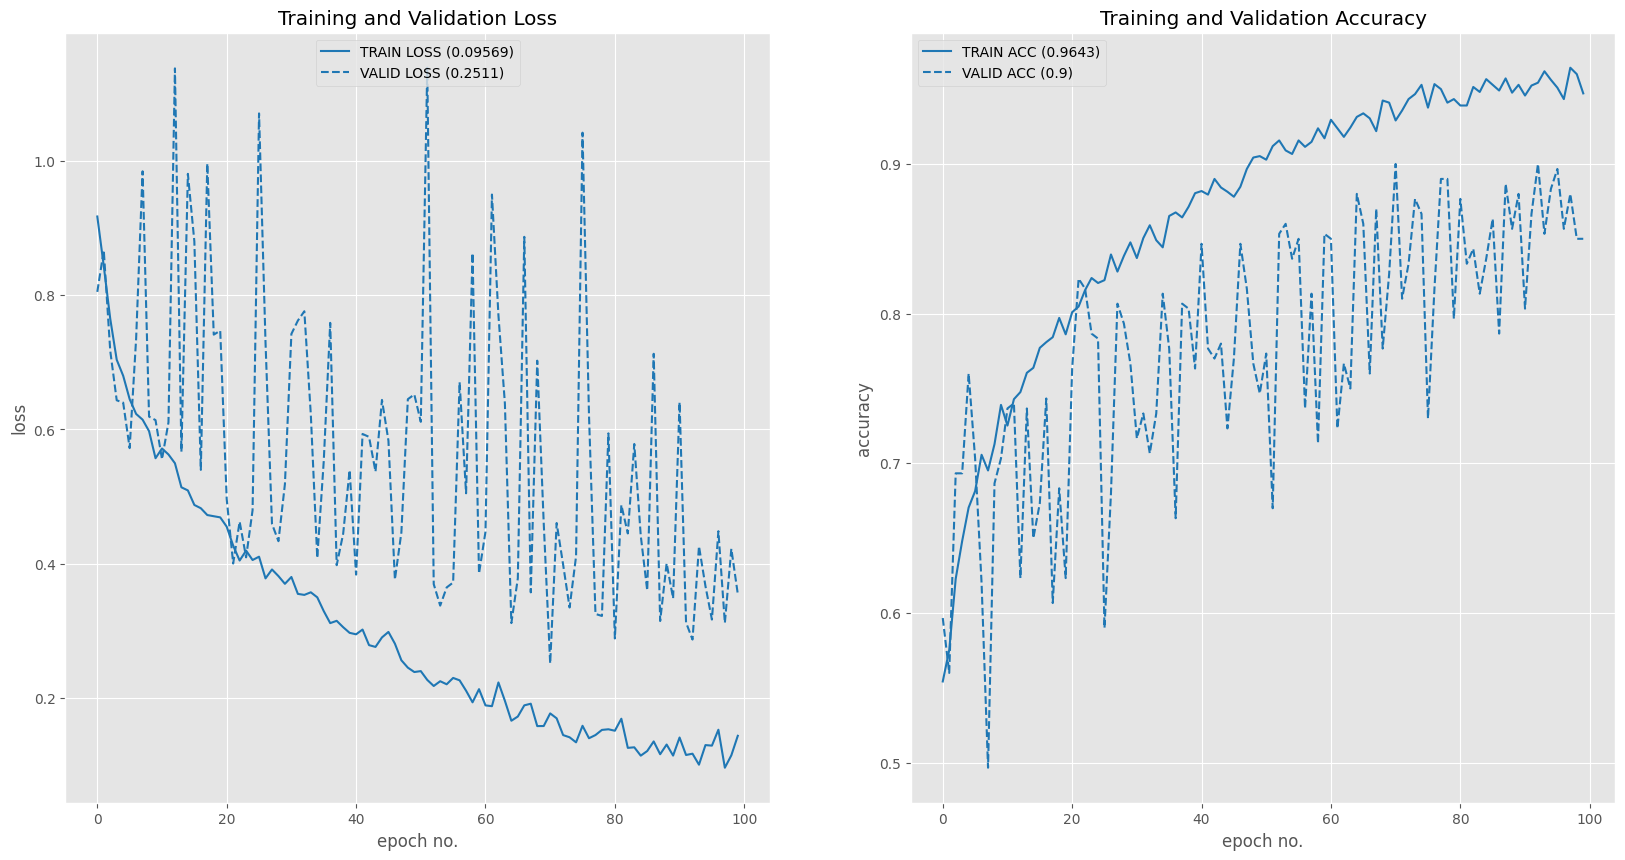

In [32]:
plot_loss_accuracy(
    train_loss=[train_loss],
    val_loss=[val_loss],
    train_acc=[train_acc],
    val_acc=[val_acc],
    colors=["blue"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

## <font style="color:blue">Make Predictions</font>

In [33]:
def prediction(model, device, batch_input):
    data = batch_input.to(device)

    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax.
    prob = F.softmax(output, dim=1)

    # Get the max probability.
    pred_prob = prob.data.max(dim=1)[0]

    # Get the index of the max probability.
    pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">Get Predictions on a Batch</font>

In [34]:
def get_sample_prediction(model, data_root, img_size, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction.
    model.eval()

    # Send model to cpu/cuda according to your system configuration.
    model.to(device)

    # Transformed data
    valid_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(img_size, mean, std))

    # Original image dataset
    valid_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms(img_size))

    data_len = valid_dataset.__len__()

    interval = int(data_len / batch_size)

    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = valid_dataset_trans.__getitem__(index)
        img, _ = valid_dataset.__getitem__(index)

        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()

    for i, target in enumerate(targets):
        plt.subplot(3, 5, i + 1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title(f"P:{valid_dataset.classes[cls[i]]}({prob[i]:.2}), T:{valid_dataset.classes[targets[i]]}")
    plt.show()

    return targets, cls, valid_dataset.classes

## <font style="color:blue">Load Model and Run Inference</font>


<ipython-input-25-4bb1e7806922>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2681, 0.2595, 0.2594])


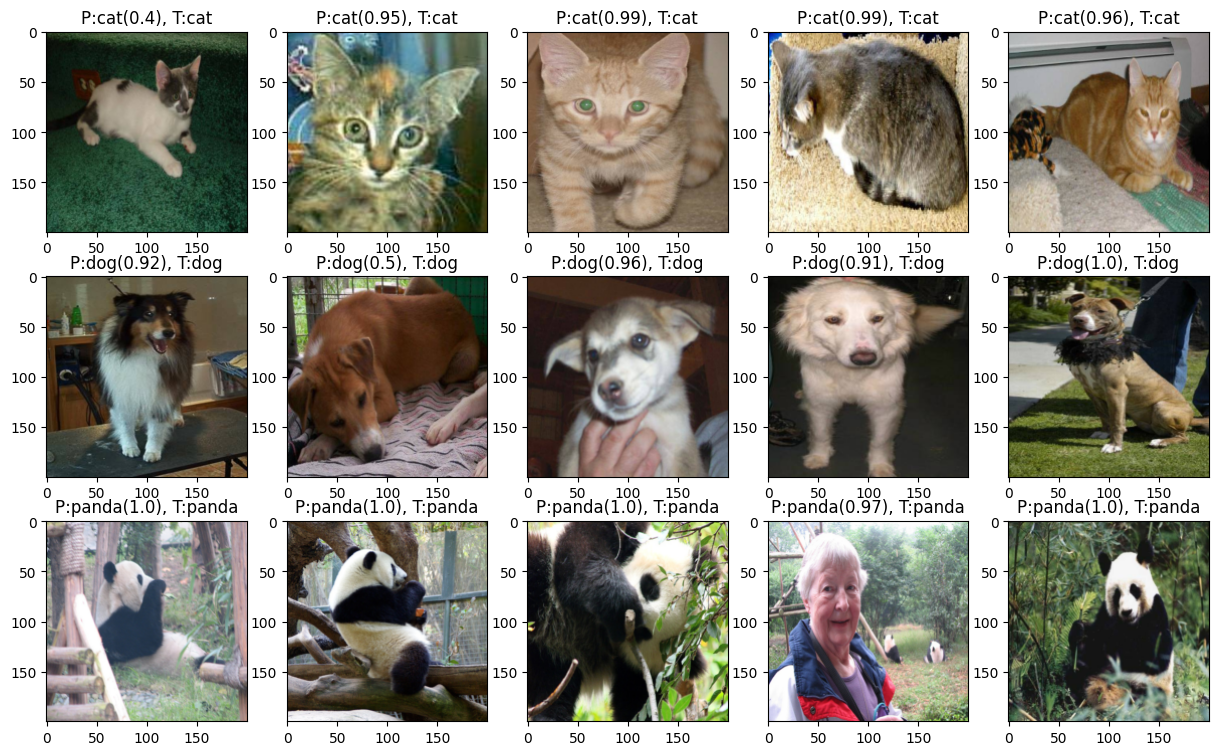

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2] [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2] ['cat', 'dog', 'panda']


In [35]:
trained_model = MyModel()
trained_model = load_model(
    trained_model,
    model_dir=training_config.checkpoint_dir,
    model_file_name=training_config.save_model_name
)

train_data_path = os.path.join(training_config.data_root, "Train")
valid_data_path = os.path.join(training_config.data_root, "Valid")

mean, std = get_mean_std(train_data_path, img_size=training_config.img_size)

y_true, y_pred, labels = get_sample_prediction(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std)
print(y_true, y_pred, labels)

# <font style="color:red">Display Confusion Matrix</font>


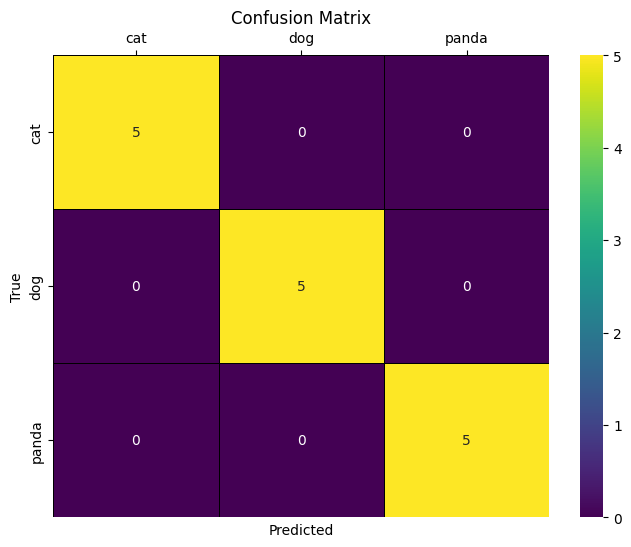

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

numerical_labels = [0, 1, 2]  # Use integer labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=numerical_labels)

# Create a heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels, linecolor='black', linewidths=0.5)

# Move prediction labels to the top
ax.xaxis.tick_top()  # Move x-axis tick labels to the top

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# <font style="color:red">Generate Submission File</font>


In [37]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define Dataset Class for Test Data
class CustomTestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_id)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return img_id, image


# Paths
# test_csv = "/kaggle/input/opencv-pytorch-project-1-classification/test.csv"  # Path to the test.csv file
test_csv = "./dataset/test.csv"
# test_img_dir = "/kaggle/input/opencv-pytorch-project-1-classification/dataset/Test"  # Directory containing test images
test_img_dir = "./dataset/dataset/Test"
submission_csv = "./dataset/submission.csv"  # Output submission file

# Use the existing image_common_transforms function for consistency
transform = image_common_transforms()

# Initialize Dataset and DataLoader for Test Data
test_dataset = CustomTestDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MyModel()
model = load_model(
    trained_model,
    model_dir=training_config.checkpoint_dir,
    model_file_name=training_config.save_model_name
)
model = model.to(device)
model.eval()  # Set the model to evaluation mode


class_labels = ["cat", "dog", "panda"]

# Generate Predictions
predictions = []
with torch.no_grad():
    for img_ids, images in test_loader:
        images = images.to(device)  # Send images to the same device as the model
        outputs = model(images)
        print("outputs: ", outputs)
        _, predicted_classes = torch.max(outputs, 1)  # Get the predicted class indices
        print("predicted_classes: ", predicted_classes)
        predicted_labels = [class_labels[i] for i in predicted_classes.cpu().numpy()]  # Map indices to labels
        predictions.extend(zip(img_ids, predicted_labels))  # Collect predictions


submission_df = pd.DataFrame(predictions, columns=["ID", "CLASS"])
print("submission_df", submission_df)
submission_df.to_csv(submission_csv, index=False)
print(f"Submission file saved to {submission_csv}")

<ipython-input-25-4bb1e7806922>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


outputs:  tensor([[-1.5920e-02, -4.6915e+00, -5.0175e+00],
        [-1.4419e+00, -3.4801e-01, -2.8570e+00],
        [-8.5251e+00, -7.8815e+00, -5.7633e-04],
        [-5.2321e+00, -5.0169e+00, -1.2039e-02],
        [-3.8740e-02, -3.4209e+00, -5.2371e+00],
        [-5.8683e-03, -5.1912e+00, -8.1610e+00],
        [-7.6144e+00, -5.1366e-04, -1.0809e+01],
        [-5.2581e+00, -4.4756e+00, -1.6727e-02],
        [-3.6579e-04, -7.9190e+00, -1.3188e+01],
        [-1.0240e+01, -9.0290e+00, -1.5568e-04],
        [-9.0093e-02, -2.4537e+00, -8.6108e+00],
        [-4.2696e+00, -4.0901e+00, -3.1208e-02],
        [-4.7506e-04, -8.4280e+00, -8.2690e+00],
        [-1.2422e-03, -6.9563e+00, -8.1496e+00],
        [-2.0941e+00, -1.3353e-01, -6.3092e+00],
        [-7.3689e+00, -6.5984e-04, -1.0445e+01],
        [-2.1813e+00, -1.2205e+00, -5.2420e-01],
        [-5.2475e-03, -5.2871e+00, -8.6384e+00],
        [-5.6210e+00, -3.6467e-03, -1.0870e+01],
        [-1.0203e-01, -3.1979e+00, -2.8798e+00],
        [-

In [38]:
submission_df['CLASS'].value_counts()

,count
CLASS,
dog,201
cat,200
panda,199
